In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from functools import wraps
import numpy as np
import copy
import random
import torch
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from utils.utils import *
from utils.training import *
# from utils.training_batch import *
from utils.model import *
from utils.BYOL_models import *
from utils.similarity import *

In [2]:
from logdeep.models.lstm import deeplog, loganomaly, robustlog
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *
from logdeep.dataset.mylog import log_dataset
# from logdeep.dataset.log import log_dataset
from logdeep.dataset.sample import sliding_window, session_window
from logdeep.tools.utils import (save_parameters, seed_everything,
                                 train_val_split)

In [3]:
# ('mnist', 'femnist', 'fmnist', 'cifar10', 'cifar100', 'svhn')
data_path = "./data"
# dataset = "cifar10"
# ('noniid-labeldir', 'noniid-label#2', 'noniid-label#3','iid', 'default') default only for femnist
partition = "iid"
client_num = 5
batch_size = 512
test_batch = 250
sim_weight = False

# Hyperparameters_List (H) = [rounds, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client, aggregation_frequence]

global_epochs = 1000
# global_epochs = 3
lr = 3e-4
dirichlet_beta = 0.4
norm = 'bn'
# every (avg_freq) epochs doing one aggregation
avg_freq = 10
# avg_freq = "exp"

# save_path = f"./model/SplitFSSLMaxpool_resnet18/resnet18Maxpooling_cifar10_{batch_size}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL32_DifAvgtimes_0229/resnet18Maxpooling_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
save_path = f"./model/SplitFSSL_similarity_deeplog/resnet18Maxpooling_sim_weight({sim_weight})_{batch_size}_{avg_freq}_{partition}_{client_num}"
H = [global_epochs, client_num, batch_size, lr, avg_freq]

In [4]:
logoptions = dict()
logoptions['data_dir'] = './data/'
logoptions['window_size'] = 10
# logoptions['device'] = "cpu"

# Smaple
logoptions['sample'] = "sliding_window"
logoptions['window_size'] = 10  # if fix_window

# Features
logoptions['sequentials'] = True
logoptions['quantitatives'] = False
logoptions['semantics'] = False
logoptions['feature_num'] = sum(
    [logoptions['sequentials'], logoptions['quantitatives'], logoptions['semantics']])

In [5]:
if logoptions['sample'] == 'sliding_window':
    train_logs, train_labels = sliding_window(logoptions['data_dir'],
                                              datatype='train',
                                              window_size=logoptions['window_size'],
                                              clientnum = client_num)
    share_logs, share_labels = sliding_window(logoptions['data_dir'],
                                              datatype='share',
                                              window_size=logoptions['window_size'],
                                              clientnum = client_num)
    # val_logs, val_labels = sliding_window(logoptions['data_dir'],
    #                                       datatype='val',
    #                                       window_size=logoptions['window_size'],
    #                                       clientnum = client_num)
elif logoptions['sample'] == 'session_window':
    train_logs, train_labels = session_window(logoptions['data_dir'],
                                              datatype='train')
    # val_logs, val_labels = session_window(logoptions['data_dir'],
    #                                       datatype='val')
else:
    raise NotImplementedError

File ./data/hdfs/hdfs_train, number of sessions 4855
number of client 0 seqs 9548
number of client 1 seqs 9273
number of client 2 seqs 9301
number of client 3 seqs 9272
number of client 4 seqs 9181
Shared data number of seqs 262


In [6]:
train_dataset = []
# valid_dataset = []
for trainlog, label in zip(train_logs, train_labels):
    dataset = log_dataset(logs=trainlog,
                                labels=label,
                                seq=logoptions['sequentials'],
                                quan=logoptions['quantitatives'],
                                sem=logoptions['semantics'])
    train_dataset.append(dataset)
    


shared_dataset = log_dataset(logs=share_logs,
                      labels=share_labels,
                      seq=logoptions['sequentials'],
                      quan=logoptions['quantitatives'],
                      sem=logoptions['semantics'])
    
# for vallog, label in zip(val_logs, val_labels):  
#     dataset = log_dataset(logs=vallog,
#                                 labels=label,
#                                 seq=logoptions['sequentials'],
#                                 quan=logoptions['quantitatives'],
#                                 sem=logoptions['semantics'])
#     valid_dataset.append(dataset)

In [7]:
len(train_dataset[0])

9548

In [8]:
train_loader_list = []
# valid_loader = []
for dataset in train_dataset:
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)
    train_loader_list.append(loader)

shared_data_loader = DataLoader(shared_dataset,
                        batch_size=128,
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)
# for dataset in valid_dataset:
#     loader = DataLoader(dataset,
#                         batch_size=batch_size,
#                         shuffle=False,
#                         pin_memory=True)
#     valid_loader.append(loader)

In [9]:
# cls_count = np.zeros([10,client_num], dtype=int)
# for k in range(client_num):
#     for i in traindata_cls_counts[k]:
#         cls_count[i][k] = traindata_cls_counts[k][i]

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# plt.figure(figsize=(6,6))
# sns.heatmap(cls_count, yticklabels=class_names, square=False,annot=True,fmt='d',linecolor='white',cmap='Blues',linewidths=1.5)
# plt.xlabel('client',fontsize=20)
# plt.ylabel('class',fontsize=20)
# plt.show()

In [10]:
net = deeplog(input_size=1, hidden_size=64, num_layers=2, num_keys=28)
client_model = BYOL_Client(net=net, projection_size=28, projection_hidden_size=64)
server_model = BYOL_Server(projection_size=28, projection_hidden_size=64)
client_model_test = BYOL_Client(net=net, projection_size=28, projection_hidden_size=64)

# client_model = BYOL_Client()
# server_model = BYOL_Server()
server_model.cuda()

client_weights = [1/5 for i in range(client_num)]
client_simweights = [[1 for i in range(client_num)] for i in range(client_num)]
client_models = [copy.deepcopy(client_model).cuda() for idx in range(client_num)]
client_tempmodels = [copy.deepcopy(client_model) for idx in range(client_num)]

# server_models = [copy.deepcopy(server_model).cuda() for idx in range(client_num)]

optimizer_server = torch.optim.Adam(server_model.parameters(), lr = H[3]) 
optimizer_clients = [torch.optim.Adam(client_models[i].parameters(), lr = H[3]) for i in range(len(client_models))]

In [11]:
client_model

BYOL_Client(
  (online_encoder): deeplog(
    (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
    (fc): MLP(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=64, out_features=28, bias=True)
      )
    )
  )
)

In [12]:
# clients_pred_per_label = {idx: [] for idx in range(5)}
# for batch_idx, (data, _, target) in enumerate(shared_data_loader):
#     data, target = data.cuda(), target
#     for idx in range(5): 

#         net = copy.deepcopy(nn.Sequential(*list(clients[idx].online_encoder.children())[:-1]))
#         # net = copy.deepcopy(client_models[idx].online_encoder)
#         net.cuda()
#         net.eval()
#         # clients[idx].eval()
    
#         output = net(data)
#         pred = output.data
        
    
#         clients_pred_per_label[idx].append(pred)

In [13]:
epoch = 0
# checkpath = save_path + "/checkpoint.pth.tar" 
# checkpoint = torch.load(checkpath)
# epoch = checkpoint['glepoch']
# print(epoch)
# optimizer_server.load_state_dict(checkpoint['optimizer'][0])
# if sim_weight:
#     for clientidx in range(client_num):
#         client_models[clientidx].online_encoder.load_state_dict(checkpoint['state_dict'][clientidx])
# else:
#     for localmodel in client_models:
#         localmodel.online_encoder.load_state_dict(checkpoint['state_dict'])

# for clientidx in range(client_num):
#     optimizer_clients[clientidx].load_state_dict(checkpoint['optimizer'][clientidx+1])

In [14]:

def training(client_models, server_model, optimizer_server, optimizer_clients, rounds, batch_size, avg_freq):
   
    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    avg_times = 0
    # measure time
    start = time.time()
    pre_clients_features = None
    feature_sim_dict = {}
    
    
    writer = SummaryWriter(f'logs/SplitFSSL_BYOL32_similarity_feature0423/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}')
    # writer = SummaryWriter(f'logs/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}')
    global_step = 0
    for curr_round in range(epoch, rounds+1):
        metrics = defaultdict(list)
        print(f"Global Round:", curr_round)
        w, local_loss = [], []
        
        num_batch = 0
        for i in train_loader_list:
            if num_batch < len(i):
                num_batch = len(i)
                
        train_iter = []
        for i in train_loader_list:
            train_iter.append(iter(i))
            
        batch_time = AverageMeter()
        data_time = AverageMeter()
        p_bar = tqdm(range(num_batch))

        # 聚合頻率參數成指數成長
        # alpha = expavg_times(curr_round)
        # 聚合頻率參數線性數成長
        # alpha = linear_growth(curr_round)
        # 聚合頻率參數成固定參數
        alpha = avg_freq
        
        for batch in range(num_batch):
            # print("0>", time.time() - start)
            optimizer_zero_grads(optimizer_server, optimizer_clients)
            
            online_proj_one_list = [None for _ in range(client_num)]
            online_proj_two_list = [None for _ in range(client_num)]
            target_proj_one_list = [None for _ in range(client_num)]
            target_proj_two_list = [None for _ in range(client_num)]

            # client forward
            # select 5 client to join training
            s_clients = []
            s_clients = range(client_num)
            # s_clients = random.sample(range(client_num), 6)
            # print("1>", time.time() - start)
            for i, client_id in enumerate(s_clients):
                # print("Client: ",i)
                # Compute a local update
                # print(i, "0>", time.time() - start)
                img1, img2, _ = next_data_batch(train_iter[client_id], train_loader_list[client_id])
                
                img1 = img1.cuda()
                img2 = img2.cuda()
                
                data_time.update(time.time() - start)
                # print(i, "1>", time.time() - start)
                # pass to client model
                # print("pass to client model")
                client_models[client_id].train()
                # print(i, "2>", time.time() - start)
                online_proj_one, online_proj_two, target_proj_one, target_proj_two = client_models[client_id](img1, img2)
                # print(i, "3>", time.time() - start)
                
                # store representations
                online_proj_one_list[i] = online_proj_one
                online_proj_two_list[i] = online_proj_two
                target_proj_one_list[i] = target_proj_one
                target_proj_two_list[i] = target_proj_two
                  

            
            # stack representations
            stack_online_proj_one = torch.cat(online_proj_one_list, dim = 0)
            stack_online_proj_two = torch.cat(online_proj_two_list, dim = 0)
            stack_target_proj_one = torch.cat(target_proj_one_list, dim = 0)
            stack_target_proj_two = torch.cat(target_proj_two_list, dim = 0)

            # print(">", time.time() - start)
            stack_online_proj_one, stack_online_proj_two, stack_target_proj_one, stack_target_proj_two = stack_online_proj_one.cuda(), stack_online_proj_two.cuda(), stack_target_proj_one.cuda(), stack_target_proj_two.cuda()
            
            # server computes
            # print("server computes")
            online_proj_one_grad, online_proj_two_grad, loss = train_server(stack_online_proj_one.detach(), stack_online_proj_two.detach(), stack_target_proj_one, stack_target_proj_two, server_model)
            local_loss.append((loss.item()))
            optimizer_server.step()
            # print(time.time() - start)
            # distribute gradients to clients
            # online_proj_one_grad, online_proj_two_grad = online_proj_one_grad.cpu(), online_proj_two_grad.cpu()
            gradient_dict_one = {key: [] for key in range(client_num)}
            gradient_dict_two = {key: [] for key in range(client_num)}
            
            for j in range(client_num):
                gradient_dict_one[j] = online_proj_one_grad[j*batch_size:(j+1)*batch_size, :]
                gradient_dict_two[j] = online_proj_two_grad[j*batch_size:(j+1)*batch_size, :]
                
            # breakpoint()
            for i, client_id in enumerate(s_clients):
                online_proj_one_list[i].backward(gradient_dict_one[i])
                online_proj_two_list[i].backward(gradient_dict_two[i])
                optimizer_clients[client_id].step()
                client_models[client_id].update_moving_average()
            
            # if (batch+1)%10 == 0:
            #     print(f"Step [{batch}/{num_batch}]:\tLoss: {loss.item()}")
            
            del img1, img2
            writer.add_scalar("Loss/train_step", loss, global_step)
            metrics["Loss/train"].append(loss.item())
            global_step += 1
            
            batch_time.update(time.time() - start)
            start = time.time()
            #=======================================set p_bar description=======================================================
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. alpha: {ep_alpha}. Batch: {bt:.3f}s. Loss: {loss:.4f}.".format(
                    epoch=curr_round,
                    epochs=rounds,
                    batch=batch + 1,
                    iter=num_batch,
                    data=data_time.avg,
                    ep_alpha = alpha,
                    bt=batch_time.avg,
                    loss=loss.item()))
            p_bar.update()
            #=======================================set p_bar description=======================================================
            # in 32 batch size will have 250 batches, if aggregate per 10 batches will have 25 aggerations in one epoch
            # in 64 batch size will have 125 batches, if aggregate per 5 batches will have 25 aggerations in one epoch
            if batch == num_batch - 1 or ((batch+1) % alpha == 0):
                
                # calculate similarity matrix
                if avg_times % 10 == 0:
                    clients_similarity, mat_sim, clients_features = similarity_mat(save_path, curr_round, avg_times, s_clients, client_models, shared_data_loader, 
                                                            nclasses=28, nsamples=256)
                    
                    if pre_clients_features == None:
                        pre_clients_features = clients_features
                    else:
                        # 計算每個client與上次features的相似度
                        # breakpoint()
                        feature_sim_dict[curr_round] = cos_similarity(pre_clients_features, clients_features)
                        pre_clients_features = clients_features
                        print(f"epoch {curr_round} similarity : {feature_sim_dict[curr_round]}")
                    # 用softmax運算
                    # for i in range(client_num):
                    #     w = clients_similarity[i]
                    #     weight = torch.softmax(torch.tensor(w), dim=0)
                    #     client_simweights[i] = weight
                        
                    for i in range(client_num):
                        weights_sum = np.sum(clients_similarity[i])
                        for k, w in enumerate(clients_similarity[i]):
                            client_simweights[i][k] = w / weights_sum

                    # for idx, w in enumerate(client_simweights):
                    #     print(f"client {idx} weight : {w}, sum : {np.sum(w)}")
            
                # print("aggregate batch", batch)
                avg_times += 1
                with torch.no_grad():
                    # aggregate client models
                    # for key, param in model.named_parameters():
                    #     if param.requires_grad:
                    for key in client_model.state_dict().keys():
                        if "running" in key or "num_batches" in key:
                            continue
                        if sim_weight:
                            # 計算每個client的聚合權重
                            for client_idx in s_clients:
                                temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                                for i in s_clients:
                                    temp += client_simweights[client_idx][i] * client_models[i].state_dict()[key]                        
                                client_tempmodels[client_idx].state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                client_models[client_idx].state_dict()[key].data.copy_(client_tempmodels[client_idx].state_dict()[key])
                            
                        
                        else:
                            temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                            for client_idx in s_clients:
                                temp += client_weights[client_idx] * client_models[client_idx].state_dict()[key]                        
                            client_model.state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                # temp = 0.8 * client_model.state_dict()[key].to('cuda') + 0.2 * client_models[client_idx].state_dict()[key]
                                # client_models[client_idx].state_dict()[key].data.copy_(temp)
                                client_models[client_idx].state_dict()[key].data.copy_(client_model.state_dict()[key])
                            
    
        
        p_bar.close()
        # scheduler_server.step()
        for k, v in metrics.items():
            writer.add_scalar(k, np.array(v).mean(), curr_round)


        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)
        if curr_round % 5 == 0:
            optimizer_dict = []
            optimizer_dict.append(optimizer_server.state_dict())            
            for client_idx in range(client_num):
                optimizer_dict.append(optimizer_clients[client_idx].state_dict())
            if sim_weight:
                state_dict = []
                for cid in range(client_num):
                    state_dict.append(client_models[cid].online_encoder.cpu().state_dict())
                    client_models[cid].to('cuda')
            else:
                state_dict = client_model.online_encoder.cpu().state_dict()
            save_checkpoint({
                'glepoch': curr_round+1,
                'state_dict': state_dict,
                'optimizer': optimizer_dict,
                'feature_dict': feature_sim_dict,
            }, save_path)
        if curr_round % 100 == 0:
            if sim_weight:
                if not os.path.exists(save_path + f"/epoch_{curr_round}"):
                    os.makedirs(save_path + f"/epoch_{curr_round}")
                for cid in range(client_num):
                    torch.save(client_models[cid].online_encoder.cpu().state_dict(), save_path + f"/epoch_{curr_round}/client_{cid}.pt")
                    client_models[cid].to('cuda')      
            else:
                torch.save(client_model.online_encoder.cpu().state_dict(), save_path + f"_{curr_round}_epoch.pt")
        
        
        print(f"Global round: {curr_round} | Average loss: {loss_avg}")
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
   
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))
    print(f"Total average times : {avg_times}")

    return client_models, client_model, train_loss

In [15]:
print(save_path)

./model/SplitFSSL_similarity_deeplog/resnet18Maxpooling_sim_weight(False)_512_10_iid_5


In [16]:
client_models, client_model, train_loss = training(client_models, server_model, optimizer_server, optimizer_clients, H[0], H[2], H[4])

Global Round: 0


  0%|                                                                                              | 0/18 [00:00<?, ?it/s]/home/haken/.conda/envs/splitfedssl/lib/python3.7/site-packages/torch/nn/modules/rnn.py:775: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
Train Epoch: 0/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.117s. Loss: 2.6425.: 100%|█| 18/18 [00:02<00:00,  


Global round: 0 | Average loss: 3.238271329138014
Global Round: 1


Train Epoch: 1/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 1.7888.: 100%|█| 18/18 [00:01<00:00,  


Global round: 1 | Average loss: 2.1439544757207236
Global Round: 2


Train Epoch: 2/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 1.4180.: 100%|█| 18/18 [00:02<00:00,  


Global round: 2 | Average loss: 1.5679548581441243
Global Round: 3


Train Epoch: 3/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 1.2930.: 100%|█| 18/18 [00:01<00:00,  


Global round: 3 | Average loss: 1.3383083608415391
Global Round: 4


Train Epoch: 4/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 1.2292.: 100%|█| 18/18 [00:01<00:00,  


Global round: 4 | Average loss: 1.2450635698106554
Global Round: 5


Train Epoch: 5/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.117s. Loss: 1.1783.:  61%|▌| 11/18 [00:01<00:01,  

epoch 5 similarity : [0.14526964724063873, 0.1530669778585434, 0.15901905298233032, 0.1658957600593567, 0.15702879428863525]


Train Epoch: 5/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 1.1975.: 100%|█| 18/18 [00:02<00:00,  


Global round: 5 | Average loss: 1.1959574686156378
Global Round: 6


Train Epoch: 6/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 1.1621.: 100%|█| 18/18 [00:01<00:00,  


Global round: 6 | Average loss: 1.1618798706266615
Global Round: 7


Train Epoch: 7/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.111s. Loss: 1.1437.: 100%|█| 18/18 [00:01<00:00,  


Global round: 7 | Average loss: 1.143316196070777
Global Round: 8


Train Epoch: 8/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 1.1263.: 100%|█| 18/18 [00:02<00:00,  


Global round: 8 | Average loss: 1.1304796073171828
Global Round: 9


Train Epoch: 9/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 1.1440.: 100%|█| 18/18 [00:01<00:00,  


Global round: 9 | Average loss: 1.1210307677586873
Global Round: 10


Train Epoch: 10/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.122s. Loss: 1.1640.:  61%|▌| 11/18 [00:01<00:01, 

epoch 10 similarity : [0.21501842141151428, 0.2162293940782547, 0.23067700862884521, 0.2218872308731079, 0.2194829136133194]


Train Epoch: 10/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 1.0924.: 100%|█| 18/18 [00:02<00:00, 


Global round: 10 | Average loss: 1.1043248640166388
Global Round: 11


Train Epoch: 11/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 1.0586.: 100%|█| 18/18 [00:01<00:00, 


Global round: 11 | Average loss: 1.096914099322425
Global Round: 12


Train Epoch: 12/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 1.0900.: 100%|█| 18/18 [00:01<00:00, 


Global round: 12 | Average loss: 1.0902855926089816
Global Round: 13


Train Epoch: 13/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 1.0800.: 100%|█| 18/18 [00:01<00:00, 


Global round: 13 | Average loss: 1.0761016938421462
Global Round: 14


Train Epoch: 14/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 1.0523.: 100%|█| 18/18 [00:02<00:00, 


Global round: 14 | Average loss: 1.0678544375631545
Global Round: 15


Train Epoch: 15/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 1.0591.:  61%|▌| 11/18 [00:01<00:00, 

epoch 15 similarity : [0.16288502514362335, 0.1665065586566925, 0.17867103219032288, 0.17305584251880646, 0.1640034019947052]


Train Epoch: 15/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 1.0866.: 100%|█| 18/18 [00:02<00:00, 


Global round: 15 | Average loss: 1.0636770327885945
Global Round: 16


Train Epoch: 16/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 1.0491.: 100%|█| 18/18 [00:01<00:00, 


Global round: 16 | Average loss: 1.04763349559572
Global Round: 17


Train Epoch: 17/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 1.0178.: 100%|█| 18/18 [00:01<00:00, 


Global round: 17 | Average loss: 1.045026229487525
Global Round: 18


Train Epoch: 18/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 1.0096.: 100%|█| 18/18 [00:01<00:00, 


Global round: 18 | Average loss: 1.0252361363834805
Global Round: 19


Train Epoch: 19/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 1.0144.: 100%|█| 18/18 [00:01<00:00, 


Global round: 19 | Average loss: 1.0249516699049208
Global Round: 20


Train Epoch: 20/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 1.0339.:  61%|▌| 11/18 [00:01<00:00, 

epoch 20 similarity : [0.2808581590652466, 0.28019171953201294, 0.2885054349899292, 0.2897907793521881, 0.276785284280777]


Train Epoch: 20/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 1.0299.: 100%|█| 18/18 [00:02<00:00, 


Global round: 20 | Average loss: 1.0085083444913228
Global Round: 21


Train Epoch: 21/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.9916.: 100%|█| 18/18 [00:01<00:00, 


Global round: 21 | Average loss: 1.0007966491911147
Global Round: 22


Train Epoch: 22/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 1.0033.: 100%|█| 18/18 [00:01<00:00, 


Global round: 22 | Average loss: 0.9955998924043443
Global Round: 23


Train Epoch: 23/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 1.0013.: 100%|█| 18/18 [00:01<00:00, 


Global round: 23 | Average loss: 0.9894182052877214
Global Round: 24


Train Epoch: 24/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9491.: 100%|█| 18/18 [00:01<00:00, 


Global round: 24 | Average loss: 0.9856169720490774
Global Round: 25


Train Epoch: 25/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 1.0004.:  61%|▌| 11/18 [00:01<00:00, 

epoch 25 similarity : [0.20374815165996552, 0.19292181730270386, 0.19639213383197784, 0.20358681678771973, 0.17905394732952118]


Train Epoch: 25/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.116s. Loss: 0.9367.: 100%|█| 18/18 [00:02<00:00, 


Global round: 25 | Average loss: 0.9774943722618951
Global Round: 26


Train Epoch: 26/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9533.: 100%|█| 18/18 [00:01<00:00, 


Global round: 26 | Average loss: 0.9731492466396756
Global Round: 27


Train Epoch: 27/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.9700.: 100%|█| 18/18 [00:01<00:00, 


Global round: 27 | Average loss: 0.9690379202365875
Global Round: 28


Train Epoch: 28/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9492.: 100%|█| 18/18 [00:01<00:00, 


Global round: 28 | Average loss: 0.9561531709300147
Global Round: 29


Train Epoch: 29/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.9356.: 100%|█| 18/18 [00:01<00:00, 


Global round: 29 | Average loss: 0.9441811641057333
Global Round: 30


Train Epoch: 30/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.120s. Loss: 0.9378.:  61%|▌| 11/18 [00:01<00:00, 

epoch 30 similarity : [0.17062720656394958, 0.17301328480243683, 0.17207463085651398, 0.1670382022857666, 0.16339020431041718]


Train Epoch: 30/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.9108.: 100%|█| 18/18 [00:02<00:00, 


Global round: 30 | Average loss: 0.9477083086967468
Global Round: 31


Train Epoch: 31/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.9340.: 100%|█| 18/18 [00:02<00:00, 


Global round: 31 | Average loss: 0.9439808428287506
Global Round: 32


Train Epoch: 32/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.9315.: 100%|█| 18/18 [00:01<00:00, 


Global round: 32 | Average loss: 0.9389121664894952
Global Round: 33


Train Epoch: 33/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.9371.: 100%|█| 18/18 [00:01<00:00, 


Global round: 33 | Average loss: 0.9291887482007345
Global Round: 34


Train Epoch: 34/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.9115.: 100%|█| 18/18 [00:01<00:00, 


Global round: 34 | Average loss: 0.9202589028411441
Global Round: 35


Train Epoch: 35/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.8948.:  61%|▌| 11/18 [00:01<00:00, 

epoch 35 similarity : [0.2048124074935913, 0.21298393607139587, 0.2129032462835312, 0.21359454095363617, 0.2025981992483139]


Train Epoch: 35/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.9456.: 100%|█| 18/18 [00:02<00:00, 


Global round: 35 | Average loss: 0.9212684333324432
Global Round: 36


Train Epoch: 36/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.9125.: 100%|█| 18/18 [00:01<00:00, 


Global round: 36 | Average loss: 0.915155698855718
Global Round: 37


Train Epoch: 37/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.8873.: 100%|█| 18/18 [00:02<00:00, 


Global round: 37 | Average loss: 0.9175446662637923
Global Round: 38


Train Epoch: 38/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.9337.: 100%|█| 18/18 [00:01<00:00, 


Global round: 38 | Average loss: 0.9231084916326735
Global Round: 39


Train Epoch: 39/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.111s. Loss: 0.9307.: 100%|█| 18/18 [00:01<00:00, 


Global round: 39 | Average loss: 0.9173493948247697
Global Round: 40


Train Epoch: 40/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.9105.:  61%|▌| 11/18 [00:01<00:01, 

epoch 40 similarity : [0.2117423266172409, 0.21140407025814056, 0.21106569468975067, 0.22782737016677856, 0.22171737253665924]


Train Epoch: 40/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.9101.: 100%|█| 18/18 [00:02<00:00, 


Global round: 40 | Average loss: 0.9136899444792006
Global Round: 41


Train Epoch: 41/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.9417.: 100%|█| 18/18 [00:01<00:00, 


Global round: 41 | Average loss: 0.911475247806973
Global Round: 42


Train Epoch: 42/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.9234.: 100%|█| 18/18 [00:01<00:00, 


Global round: 42 | Average loss: 0.9106656544738345
Global Round: 43


Train Epoch: 43/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.9184.: 100%|█| 18/18 [00:02<00:00, 


Global round: 43 | Average loss: 0.9167435235447354
Global Round: 44


Train Epoch: 44/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.9426.: 100%|█| 18/18 [00:01<00:00, 


Global round: 44 | Average loss: 0.9118684033552805
Global Round: 45


Train Epoch: 45/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.9249.:  61%|▌| 11/18 [00:01<00:01, 

epoch 45 similarity : [0.10781993716955185, 0.1130104511976242, 0.12734360992908478, 0.10504185408353806, 0.10548648983240128]


Train Epoch: 45/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.9163.: 100%|█| 18/18 [00:02<00:00, 


Global round: 45 | Average loss: 0.9122602807150947
Global Round: 46


Train Epoch: 46/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.9120.: 100%|█| 18/18 [00:01<00:00, 


Global round: 46 | Average loss: 0.9165904654396905
Global Round: 47


Train Epoch: 47/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9203.: 100%|█| 18/18 [00:01<00:00, 


Global round: 47 | Average loss: 0.9129885832468668
Global Round: 48


Train Epoch: 48/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.9310.: 100%|█| 18/18 [00:01<00:00, 


Global round: 48 | Average loss: 0.9169923232661353
Global Round: 49


Train Epoch: 49/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.9084.: 100%|█| 18/18 [00:01<00:00, 


Global round: 49 | Average loss: 0.9155827164649963
Global Round: 50


Train Epoch: 50/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.9192.:  61%|▌| 11/18 [00:01<00:00, 

epoch 50 similarity : [0.17985396087169647, 0.17877022922039032, 0.1865336000919342, 0.17364636063575745, 0.16886986792087555]


Train Epoch: 50/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.8808.: 100%|█| 18/18 [00:02<00:00, 


Global round: 50 | Average loss: 0.9125464095009698
Global Round: 51


Train Epoch: 51/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.8969.: 100%|█| 18/18 [00:01<00:00, 


Global round: 51 | Average loss: 0.9183360305097368
Global Round: 52


Train Epoch: 52/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9116.: 100%|█| 18/18 [00:01<00:00, 


Global round: 52 | Average loss: 0.9156079755889045
Global Round: 53


Train Epoch: 53/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.9355.: 100%|█| 18/18 [00:01<00:00, 


Global round: 53 | Average loss: 0.9185955491330888
Global Round: 54


Train Epoch: 54/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9096.: 100%|█| 18/18 [00:01<00:00, 


Global round: 54 | Average loss: 0.9134566055403815
Global Round: 55


Train Epoch: 55/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.9455.:  61%|▌| 11/18 [00:01<00:00, 

epoch 55 similarity : [0.13816766440868378, 0.14164966344833374, 0.15656380355358124, 0.1480795294046402, 0.13136671483516693]


Train Epoch: 55/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.9171.: 100%|█| 18/18 [00:02<00:00, 


Global round: 55 | Average loss: 0.9266955388916863
Global Round: 56


Train Epoch: 56/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.9309.: 100%|█| 18/18 [00:01<00:00, 


Global round: 56 | Average loss: 0.9109001755714417
Global Round: 57


Train Epoch: 57/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.9467.: 100%|█| 18/18 [00:01<00:00, 


Global round: 57 | Average loss: 0.9205505384339226
Global Round: 58


Train Epoch: 58/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.9259.: 100%|█| 18/18 [00:01<00:00, 


Global round: 58 | Average loss: 0.9175605343447791
Global Round: 59


Train Epoch: 59/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.9274.: 100%|█| 18/18 [00:01<00:00, 


Global round: 59 | Average loss: 0.9195130666097006
Global Round: 60


Train Epoch: 60/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.8988.:  61%|▌| 11/18 [00:01<00:00, 

epoch 60 similarity : [0.1673627644777298, 0.1734900027513504, 0.17455650866031647, 0.1807039976119995, 0.16845491528511047]


Train Epoch: 60/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.9156.: 100%|█| 18/18 [00:02<00:00, 


Global round: 60 | Average loss: 0.9164340794086456
Global Round: 61


Train Epoch: 61/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.9287.: 100%|█| 18/18 [00:01<00:00, 


Global round: 61 | Average loss: 0.9078393148051368
Global Round: 62


Train Epoch: 62/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.9067.: 100%|█| 18/18 [00:01<00:00, 


Global round: 62 | Average loss: 0.9165249268213908
Global Round: 63


Train Epoch: 63/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.9246.: 100%|█| 18/18 [00:01<00:00, 


Global round: 63 | Average loss: 0.9109869367546506
Global Round: 64


Train Epoch: 64/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.9505.: 100%|█| 18/18 [00:01<00:00, 


Global round: 64 | Average loss: 0.9237801432609558
Global Round: 65


Train Epoch: 65/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.9232.:  61%|▌| 11/18 [00:01<00:00, 

epoch 65 similarity : [0.15558524429798126, 0.16431397199630737, 0.15861442685127258, 0.1619172841310501, 0.15834732353687286]


Train Epoch: 65/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.8862.: 100%|█| 18/18 [00:02<00:00, 


Global round: 65 | Average loss: 0.9194795423083835
Global Round: 66


Train Epoch: 66/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.9311.: 100%|█| 18/18 [00:02<00:00, 


Global round: 66 | Average loss: 0.9086136288113065
Global Round: 67


Train Epoch: 67/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.108s. Loss: 0.9435.: 100%|█| 18/18 [00:01<00:00, 


Global round: 67 | Average loss: 0.9094151159127554
Global Round: 68


Train Epoch: 68/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.9627.: 100%|█| 18/18 [00:01<00:00, 


Global round: 68 | Average loss: 0.9188735087712606
Global Round: 69


Train Epoch: 69/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.8969.: 100%|█| 18/18 [00:01<00:00, 


Global round: 69 | Average loss: 0.912043958902359
Global Round: 70


Train Epoch: 70/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.9153.:  61%|▌| 11/18 [00:01<00:00, 

epoch 70 similarity : [0.13498349487781525, 0.14170101284980774, 0.13734358549118042, 0.13147369027137756, 0.13536503911018372]


Train Epoch: 70/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.8938.: 100%|█| 18/18 [00:02<00:00, 


Global round: 70 | Average loss: 0.9057153960069021
Global Round: 71


Train Epoch: 71/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.9072.: 100%|█| 18/18 [00:01<00:00, 


Global round: 71 | Average loss: 0.9144381748305427
Global Round: 72


Train Epoch: 72/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.9284.: 100%|█| 18/18 [00:02<00:00, 


Global round: 72 | Average loss: 0.9112376305792067
Global Round: 73


Train Epoch: 73/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8897.: 100%|█| 18/18 [00:01<00:00, 


Global round: 73 | Average loss: 0.9049290551079644
Global Round: 74


Train Epoch: 74/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.9276.: 100%|█| 18/18 [00:01<00:00, 


Global round: 74 | Average loss: 0.9048154552777609
Global Round: 75


Train Epoch: 75/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.9088.:  61%|▌| 11/18 [00:01<00:01, 

epoch 75 similarity : [0.21520674228668213, 0.22047902643680573, 0.21514439582824707, 0.2163505256175995, 0.22016359865665436]


Train Epoch: 75/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.8866.: 100%|█| 18/18 [00:02<00:00, 


Global round: 75 | Average loss: 0.8971859647168053
Global Round: 76


Train Epoch: 76/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8666.: 100%|█| 18/18 [00:01<00:00, 


Global round: 76 | Average loss: 0.8998811410533057
Global Round: 77


Train Epoch: 77/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.9028.: 100%|█| 18/18 [00:01<00:00, 


Global round: 77 | Average loss: 0.8979040616088443
Global Round: 78


Train Epoch: 78/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.8824.: 100%|█| 18/18 [00:02<00:00, 


Global round: 78 | Average loss: 0.8988752232657539
Global Round: 79


Train Epoch: 79/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.8866.: 100%|█| 18/18 [00:02<00:00, 


Global round: 79 | Average loss: 0.8984077970186869
Global Round: 80


Train Epoch: 80/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.121s. Loss: 0.8936.:  61%|▌| 11/18 [00:01<00:01, 

epoch 80 similarity : [0.2031150609254837, 0.20602095127105713, 0.2042016088962555, 0.21932509541511536, 0.21943354606628418]


Train Epoch: 80/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.9088.: 100%|█| 18/18 [00:02<00:00, 


Global round: 80 | Average loss: 0.8926889300346375
Global Round: 81


Train Epoch: 81/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.8978.: 100%|█| 18/18 [00:01<00:00, 


Global round: 81 | Average loss: 0.8914946152104272
Global Round: 82


Train Epoch: 82/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.8643.: 100%|█| 18/18 [00:01<00:00, 


Global round: 82 | Average loss: 0.8869150016042922
Global Round: 83


Train Epoch: 83/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8777.: 100%|█| 18/18 [00:01<00:00, 


Global round: 83 | Average loss: 0.8916581273078918
Global Round: 84


Train Epoch: 84/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.8795.: 100%|█| 18/18 [00:02<00:00, 


Global round: 84 | Average loss: 0.88962608244684
Global Round: 85


Train Epoch: 85/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.8690.:  61%|▌| 11/18 [00:01<00:00, 

epoch 85 similarity : [0.19668421149253845, 0.20143158733844757, 0.20343436300754547, 0.2047194540500641, 0.20529811084270477]


Train Epoch: 85/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.116s. Loss: 0.8979.: 100%|█| 18/18 [00:02<00:00, 


Global round: 85 | Average loss: 0.8844681514634026
Global Round: 86


Train Epoch: 86/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.8768.: 100%|█| 18/18 [00:01<00:00, 


Global round: 86 | Average loss: 0.8833341267373827
Global Round: 87


Train Epoch: 87/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.9043.: 100%|█| 18/18 [00:01<00:00, 


Global round: 87 | Average loss: 0.8836377660433451
Global Round: 88


Train Epoch: 88/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.9184.: 100%|█| 18/18 [00:01<00:00, 


Global round: 88 | Average loss: 0.8852258490191566
Global Round: 89


Train Epoch: 89/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.8776.: 100%|█| 18/18 [00:01<00:00, 


Global round: 89 | Average loss: 0.8818911380238004
Global Round: 90


Train Epoch: 90/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.8865.:  61%|▌| 11/18 [00:01<00:00, 

epoch 90 similarity : [0.18047623336315155, 0.1919557750225067, 0.19036920368671417, 0.19752804934978485, 0.19192063808441162]


Train Epoch: 90/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.117s. Loss: 0.8895.: 100%|█| 18/18 [00:02<00:00, 


Global round: 90 | Average loss: 0.8839678400092654
Global Round: 91


Train Epoch: 91/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.8831.: 100%|█| 18/18 [00:01<00:00, 


Global round: 91 | Average loss: 0.8786174952983856
Global Round: 92


Train Epoch: 92/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.8650.: 100%|█| 18/18 [00:01<00:00, 


Global round: 92 | Average loss: 0.8693185018168555
Global Round: 93


Train Epoch: 93/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.8432.: 100%|█| 18/18 [00:01<00:00, 


Global round: 93 | Average loss: 0.8770538369814554
Global Round: 94


Train Epoch: 94/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8912.: 100%|█| 18/18 [00:01<00:00, 


Global round: 94 | Average loss: 0.8726871543460422
Global Round: 95


Train Epoch: 95/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.8570.:  61%|▌| 11/18 [00:01<00:00, 

epoch 95 similarity : [0.15998134016990662, 0.17072035372257233, 0.16828733682632446, 0.16859908401966095, 0.17346522212028503]


Train Epoch: 95/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.8698.: 100%|█| 18/18 [00:02<00:00, 


Global round: 95 | Average loss: 0.8655965891149309
Global Round: 96


Train Epoch: 96/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.8720.: 100%|█| 18/18 [00:01<00:00, 


Global round: 96 | Average loss: 0.8668121496836344
Global Round: 97


Train Epoch: 97/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.8766.: 100%|█| 18/18 [00:02<00:00, 


Global round: 97 | Average loss: 0.863093505303065
Global Round: 98


Train Epoch: 98/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.8654.: 100%|█| 18/18 [00:01<00:00, 


Global round: 98 | Average loss: 0.8645163708262973
Global Round: 99


Train Epoch: 99/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8210.: 100%|█| 18/18 [00:01<00:00, 


Global round: 99 | Average loss: 0.8589935236506991
Global Round: 100


Train Epoch: 100/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.8514.:  61%|▌| 11/18 [00:01<00:00,

epoch 100 similarity : [0.2009507417678833, 0.21389122307300568, 0.21539586782455444, 0.2033151239156723, 0.21582326292991638]


Train Epoch: 100/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.8896.: 100%|█| 18/18 [00:02<00:00,


Global round: 100 | Average loss: 0.8682490852144029
Global Round: 101


Train Epoch: 101/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.8890.: 100%|█| 18/18 [00:02<00:00,


Global round: 101 | Average loss: 0.8616122470961677
Global Round: 102


Train Epoch: 102/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.8849.: 100%|█| 18/18 [00:01<00:00,


Global round: 102 | Average loss: 0.8635288543171353
Global Round: 103


Train Epoch: 103/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.8496.: 100%|█| 18/18 [00:01<00:00,


Global round: 103 | Average loss: 0.8613017665015327
Global Round: 104


Train Epoch: 104/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8518.: 100%|█| 18/18 [00:01<00:00,


Global round: 104 | Average loss: 0.8603454265329573
Global Round: 105


Train Epoch: 105/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.8741.:  61%|▌| 11/18 [00:01<00:00,

epoch 105 similarity : [0.223638653755188, 0.23304635286331177, 0.2323552370071411, 0.23271282017230988, 0.2319817990064621]


Train Epoch: 105/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.8715.: 100%|█| 18/18 [00:02<00:00,


Global round: 105 | Average loss: 0.8577671117252774
Global Round: 106


Train Epoch: 106/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8801.: 100%|█| 18/18 [00:01<00:00,


Global round: 106 | Average loss: 0.856353180276023
Global Round: 107


Train Epoch: 107/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.8432.: 100%|█| 18/18 [00:02<00:00,


Global round: 107 | Average loss: 0.8518165085050795
Global Round: 108


Train Epoch: 108/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8469.: 100%|█| 18/18 [00:01<00:00,


Global round: 108 | Average loss: 0.8526507682270474
Global Round: 109


Train Epoch: 109/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.108s. Loss: 0.8540.: 100%|█| 18/18 [00:01<00:00,


Global round: 109 | Average loss: 0.8521880838606093
Global Round: 110


Train Epoch: 110/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.8761.:  61%|▌| 11/18 [00:01<00:01,

epoch 110 similarity : [0.19585031270980835, 0.20247775316238403, 0.20168529450893402, 0.2060878723859787, 0.21090658009052277]


Train Epoch: 110/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.8571.: 100%|█| 18/18 [00:02<00:00,


Global round: 110 | Average loss: 0.8556918104489645
Global Round: 111


Train Epoch: 111/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8679.: 100%|█| 18/18 [00:01<00:00,


Global round: 111 | Average loss: 0.8493629495302836
Global Round: 112


Train Epoch: 112/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.8865.: 100%|█| 18/18 [00:01<00:00,


Global round: 112 | Average loss: 0.8386691245767806
Global Round: 113


Train Epoch: 113/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.8428.: 100%|█| 18/18 [00:02<00:00,


Global round: 113 | Average loss: 0.8462830351458656
Global Round: 114


Train Epoch: 114/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.7778.: 100%|█| 18/18 [00:02<00:00,


Global round: 114 | Average loss: 0.8378717369503446
Global Round: 115


Train Epoch: 115/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.8312.:  61%|▌| 11/18 [00:01<00:01,

epoch 115 similarity : [0.1883884072303772, 0.18851689994335175, 0.19642814993858337, 0.1914239376783371, 0.20581966638565063]


Train Epoch: 115/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.8499.: 100%|█| 18/18 [00:02<00:00,


Global round: 115 | Average loss: 0.8439824283123016
Global Round: 116


Train Epoch: 116/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.8037.: 100%|█| 18/18 [00:01<00:00,


Global round: 116 | Average loss: 0.8361117674244775
Global Round: 117


Train Epoch: 117/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.8462.: 100%|█| 18/18 [00:01<00:00,


Global round: 117 | Average loss: 0.8387099570698209
Global Round: 118


Train Epoch: 118/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8178.: 100%|█| 18/18 [00:01<00:00,


Global round: 118 | Average loss: 0.835903137922287
Global Round: 119


Train Epoch: 119/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.8196.: 100%|█| 18/18 [00:02<00:00,


Global round: 119 | Average loss: 0.8361747496657901
Global Round: 120


Train Epoch: 120/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.8463.:  61%|▌| 11/18 [00:01<00:00,

epoch 120 similarity : [0.18619275093078613, 0.17459973692893982, 0.18772517144680023, 0.17673026025295258, 0.18299859762191772]


Train Epoch: 120/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.8265.: 100%|█| 18/18 [00:02<00:00,


Global round: 120 | Average loss: 0.8355340196026696
Global Round: 121


Train Epoch: 121/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8219.: 100%|█| 18/18 [00:01<00:00,


Global round: 121 | Average loss: 0.839740965101454
Global Round: 122


Train Epoch: 122/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.8291.: 100%|█| 18/18 [00:01<00:00,


Global round: 122 | Average loss: 0.8316928909884559
Global Round: 123


Train Epoch: 123/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.8183.: 100%|█| 18/18 [00:01<00:00,


Global round: 123 | Average loss: 0.8301658795939552
Global Round: 124


Train Epoch: 124/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.8457.: 100%|█| 18/18 [00:01<00:00,


Global round: 124 | Average loss: 0.8299022614955902
Global Round: 125


Train Epoch: 125/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.7985.:  61%|▌| 11/18 [00:01<00:00,

epoch 125 similarity : [0.21805676817893982, 0.20580558478832245, 0.2128843516111374, 0.21565139293670654, 0.21017737686634064]


Train Epoch: 125/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.8259.: 100%|█| 18/18 [00:02<00:00,


Global round: 125 | Average loss: 0.8314845893118117
Global Round: 126


Train Epoch: 126/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.8361.: 100%|█| 18/18 [00:01<00:00,


Global round: 126 | Average loss: 0.8328455090522766
Global Round: 127


Train Epoch: 127/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8533.: 100%|█| 18/18 [00:01<00:00,


Global round: 127 | Average loss: 0.8231213457054563
Global Round: 128


Train Epoch: 128/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.8226.: 100%|█| 18/18 [00:01<00:00,


Global round: 128 | Average loss: 0.8263169725735983
Global Round: 129


Train Epoch: 129/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.7983.: 100%|█| 18/18 [00:01<00:00,


Global round: 129 | Average loss: 0.8228924406899346
Global Round: 130


Train Epoch: 130/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.121s. Loss: 0.8144.:  61%|▌| 11/18 [00:01<00:00,

epoch 130 similarity : [0.17740267515182495, 0.16246479749679565, 0.17230132222175598, 0.18373245000839233, 0.16862495243549347]


Train Epoch: 130/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.119s. Loss: 0.8254.: 100%|█| 18/18 [00:02<00:00,


Global round: 130 | Average loss: 0.8295857244067721
Global Round: 131


Train Epoch: 131/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.8274.: 100%|█| 18/18 [00:01<00:00,


Global round: 131 | Average loss: 0.8329770598146651
Global Round: 132


Train Epoch: 132/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.8477.: 100%|█| 18/18 [00:01<00:00,


Global round: 132 | Average loss: 0.8279795746008555
Global Round: 133


Train Epoch: 133/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.8352.: 100%|█| 18/18 [00:01<00:00,


Global round: 133 | Average loss: 0.8195771674315134
Global Round: 134


Train Epoch: 134/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8540.: 100%|█| 18/18 [00:01<00:00,


Global round: 134 | Average loss: 0.824520531627867
Global Round: 135


Train Epoch: 135/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.120s. Loss: 0.8145.:  61%|▌| 11/18 [00:01<00:00,

epoch 135 similarity : [0.16452717781066895, 0.17110323905944824, 0.1670626401901245, 0.17453283071517944, 0.1717778742313385]


Train Epoch: 135/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.8170.: 100%|█| 18/18 [00:02<00:00,


Global round: 135 | Average loss: 0.8184895184304979
Global Round: 136


Train Epoch: 136/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.8410.: 100%|█| 18/18 [00:02<00:00,


Global round: 136 | Average loss: 0.8213123612933688
Global Round: 137


Train Epoch: 137/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.8374.: 100%|█| 18/18 [00:01<00:00,


Global round: 137 | Average loss: 0.8259532517857022
Global Round: 138


Train Epoch: 138/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.8235.: 100%|█| 18/18 [00:01<00:00,


Global round: 138 | Average loss: 0.8120622469319237
Global Round: 139


Train Epoch: 139/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.8386.: 100%|█| 18/18 [00:01<00:00,


Global round: 139 | Average loss: 0.8176282511817085
Global Round: 140


Train Epoch: 140/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.8131.:  61%|▌| 11/18 [00:01<00:00,

epoch 140 similarity : [0.1969766765832901, 0.20545192062854767, 0.20528782904148102, 0.19879694283008575, 0.2185005396604538]


Train Epoch: 140/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.8434.: 100%|█| 18/18 [00:02<00:00,


Global round: 140 | Average loss: 0.8205834031105042
Global Round: 141


Train Epoch: 141/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.8264.: 100%|█| 18/18 [00:01<00:00,


Global round: 141 | Average loss: 0.8166300422615476
Global Round: 142


Train Epoch: 142/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.8827.: 100%|█| 18/18 [00:02<00:00,


Global round: 142 | Average loss: 0.8179627027776506
Global Round: 143


Train Epoch: 143/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.7892.: 100%|█| 18/18 [00:01<00:00,


Global round: 143 | Average loss: 0.8175771170192294
Global Round: 144


Train Epoch: 144/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8111.: 100%|█| 18/18 [00:01<00:00,


Global round: 144 | Average loss: 0.816261887550354
Global Round: 145


Train Epoch: 145/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.8322.:  61%|▌| 11/18 [00:01<00:01,

epoch 145 similarity : [0.1729045957326889, 0.1652265191078186, 0.18317976593971252, 0.16837340593338013, 0.1778058409690857]


Train Epoch: 145/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.8115.: 100%|█| 18/18 [00:02<00:00,


Global round: 145 | Average loss: 0.8215934402412839
Global Round: 146


Train Epoch: 146/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7991.: 100%|█| 18/18 [00:01<00:00,


Global round: 146 | Average loss: 0.8130050665802426
Global Round: 147


Train Epoch: 147/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8276.: 100%|█| 18/18 [00:01<00:00,


Global round: 147 | Average loss: 0.8213285075293647
Global Round: 148


Train Epoch: 148/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.8037.: 100%|█| 18/18 [00:01<00:00,


Global round: 148 | Average loss: 0.8193340864446428
Global Round: 149


Train Epoch: 149/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.8531.: 100%|█| 18/18 [00:01<00:00,


Global round: 149 | Average loss: 0.8216578596168094
Global Round: 150


Train Epoch: 150/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.8230.:  61%|▌| 11/18 [00:01<00:01,

epoch 150 similarity : [0.17001740634441376, 0.16591955721378326, 0.18778754770755768, 0.17419487237930298, 0.16106437146663666]


Train Epoch: 150/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.8016.: 100%|█| 18/18 [00:02<00:00,


Global round: 150 | Average loss: 0.8129025730821822
Global Round: 151


Train Epoch: 151/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7919.: 100%|█| 18/18 [00:01<00:00,


Global round: 151 | Average loss: 0.8098008400864072
Global Round: 152


Train Epoch: 152/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.7815.: 100%|█| 18/18 [00:02<00:00,


Global round: 152 | Average loss: 0.8091011908319261
Global Round: 153


Train Epoch: 153/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8155.: 100%|█| 18/18 [00:01<00:00,


Global round: 153 | Average loss: 0.8141232364707522
Global Round: 154


Train Epoch: 154/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.8069.: 100%|█| 18/18 [00:02<00:00,


Global round: 154 | Average loss: 0.8064366214805179
Global Round: 155


Train Epoch: 155/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.8268.:  61%|▌| 11/18 [00:01<00:00,

epoch 155 similarity : [0.17691779136657715, 0.1854565292596817, 0.19606924057006836, 0.18553651869297028, 0.1867809146642685]


Train Epoch: 155/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.7961.: 100%|█| 18/18 [00:02<00:00,


Global round: 155 | Average loss: 0.8083604408635033
Global Round: 156


Train Epoch: 156/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8181.: 100%|█| 18/18 [00:01<00:00,


Global round: 156 | Average loss: 0.8116595844427744
Global Round: 157


Train Epoch: 157/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.8137.: 100%|█| 18/18 [00:01<00:00,


Global round: 157 | Average loss: 0.8055659135182699
Global Round: 158


Train Epoch: 158/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8085.: 100%|█| 18/18 [00:01<00:00,


Global round: 158 | Average loss: 0.8005489971902635
Global Round: 159


Train Epoch: 159/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.7869.: 100%|█| 18/18 [00:01<00:00,


Global round: 159 | Average loss: 0.8118298616674211
Global Round: 160


Train Epoch: 160/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.8284.:  61%|▌| 11/18 [00:01<00:00,

epoch 160 similarity : [0.14675092697143555, 0.14840465784072876, 0.16514553129673004, 0.16115303337574005, 0.16508165001869202]


Train Epoch: 160/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.116s. Loss: 0.8091.: 100%|█| 18/18 [00:02<00:00,


Global round: 160 | Average loss: 0.8117683198716905
Global Round: 161


Train Epoch: 161/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.8339.: 100%|█| 18/18 [00:01<00:00,


Global round: 161 | Average loss: 0.8091258274184333
Global Round: 162


Train Epoch: 162/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7906.: 100%|█| 18/18 [00:01<00:00,


Global round: 162 | Average loss: 0.8098725312285953
Global Round: 163


Train Epoch: 163/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.8166.: 100%|█| 18/18 [00:01<00:00,


Global round: 163 | Average loss: 0.8073117799229093
Global Round: 164


Train Epoch: 164/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7820.: 100%|█| 18/18 [00:01<00:00,


Global round: 164 | Average loss: 0.8021574450863732
Global Round: 165


Train Epoch: 165/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.121s. Loss: 0.8257.:  61%|▌| 11/18 [00:01<00:00,

epoch 165 similarity : [0.1880263388156891, 0.17686845362186432, 0.18678489327430725, 0.1842942237854004, 0.19039545953273773]


Train Epoch: 165/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.119s. Loss: 0.8078.: 100%|█| 18/18 [00:02<00:00,


Global round: 165 | Average loss: 0.805018424987793
Global Round: 166


Train Epoch: 166/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.7915.: 100%|█| 18/18 [00:01<00:00,


Global round: 166 | Average loss: 0.8012868728902605
Global Round: 167


Train Epoch: 167/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.8175.: 100%|█| 18/18 [00:01<00:00,


Global round: 167 | Average loss: 0.8027024269104004
Global Round: 168


Train Epoch: 168/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.7984.: 100%|█| 18/18 [00:01<00:00,


Global round: 168 | Average loss: 0.8000728454854753
Global Round: 169


Train Epoch: 169/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7801.: 100%|█| 18/18 [00:01<00:00,


Global round: 169 | Average loss: 0.7949111097388797
Global Round: 170


Train Epoch: 170/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.121s. Loss: 0.7871.:  61%|▌| 11/18 [00:01<00:00,

epoch 170 similarity : [0.21210387349128723, 0.20395371317863464, 0.2079417109489441, 0.20149430632591248, 0.2087099701166153]


Train Epoch: 170/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.8158.: 100%|█| 18/18 [00:02<00:00,


Global round: 170 | Average loss: 0.8000361555152469
Global Round: 171


Train Epoch: 171/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7938.: 100%|█| 18/18 [00:02<00:00,


Global round: 171 | Average loss: 0.7919301920466952
Global Round: 172


Train Epoch: 172/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.8169.: 100%|█| 18/18 [00:01<00:00,


Global round: 172 | Average loss: 0.7921281556288401
Global Round: 173


Train Epoch: 173/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.7746.: 100%|█| 18/18 [00:01<00:00,


Global round: 173 | Average loss: 0.7879360814889272
Global Round: 174


Train Epoch: 174/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7783.: 100%|█| 18/18 [00:01<00:00,


Global round: 174 | Average loss: 0.7917418777942657
Global Round: 175


Train Epoch: 175/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.7887.:  61%|▌| 11/18 [00:01<00:00,

epoch 175 similarity : [0.1952166110277176, 0.20168931782245636, 0.2086409628391266, 0.20555028319358826, 0.200215682387352]


Train Epoch: 175/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.7806.: 100%|█| 18/18 [00:02<00:00,


Global round: 175 | Average loss: 0.7918559047910902
Global Round: 176


Train Epoch: 176/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7561.: 100%|█| 18/18 [00:01<00:00,


Global round: 176 | Average loss: 0.790940072801378
Global Round: 177


Train Epoch: 177/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7639.: 100%|█| 18/18 [00:02<00:00,


Global round: 177 | Average loss: 0.7878330250581106
Global Round: 178


Train Epoch: 178/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.7662.: 100%|█| 18/18 [00:01<00:00,


Global round: 178 | Average loss: 0.791314164797465
Global Round: 179


Train Epoch: 179/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7864.: 100%|█| 18/18 [00:01<00:00,


Global round: 179 | Average loss: 0.7817254000239902
Global Round: 180


Train Epoch: 180/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.7909.:  61%|▌| 11/18 [00:01<00:01,

epoch 180 similarity : [0.2449679672718048, 0.2453872561454773, 0.2621505558490753, 0.2459971308708191, 0.2582676112651825]


Train Epoch: 180/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7721.: 100%|█| 18/18 [00:02<00:00,


Global round: 180 | Average loss: 0.7838537163204617
Global Round: 181


Train Epoch: 181/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8306.: 100%|█| 18/18 [00:01<00:00,


Global round: 181 | Average loss: 0.7868534425894419
Global Round: 182


Train Epoch: 182/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7355.: 100%|█| 18/18 [00:01<00:00,


Global round: 182 | Average loss: 0.785227421257231
Global Round: 183


Train Epoch: 183/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.7781.: 100%|█| 18/18 [00:02<00:00,


Global round: 183 | Average loss: 0.7820128566688962
Global Round: 184


Train Epoch: 184/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7797.: 100%|█| 18/18 [00:01<00:00,


Global round: 184 | Average loss: 0.7821958462397257
Global Round: 185


Train Epoch: 185/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.7580.:  61%|▌| 11/18 [00:01<00:01,

epoch 185 similarity : [0.1439245194196701, 0.1413506418466568, 0.15302446484565735, 0.13779953122138977, 0.14366544783115387]


Train Epoch: 185/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.7803.: 100%|█| 18/18 [00:02<00:00,


Global round: 185 | Average loss: 0.7859988080130683
Global Round: 186


Train Epoch: 186/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.8075.: 100%|█| 18/18 [00:01<00:00,


Global round: 186 | Average loss: 0.7802424960666232
Global Round: 187


Train Epoch: 187/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.110s. Loss: 0.7787.: 100%|█| 18/18 [00:01<00:00,


Global round: 187 | Average loss: 0.781208465496699
Global Round: 188


Train Epoch: 188/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7794.: 100%|█| 18/18 [00:01<00:00,


Global round: 188 | Average loss: 0.7838848100768195
Global Round: 189


Train Epoch: 189/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.7480.: 100%|█| 18/18 [00:02<00:00,


Global round: 189 | Average loss: 0.7802451021141477
Global Round: 190


Train Epoch: 190/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7699.:  61%|▌| 11/18 [00:01<00:00,

epoch 190 similarity : [0.19446887075901031, 0.21184541285037994, 0.20948085188865662, 0.19801510870456696, 0.20889733731746674]


Train Epoch: 190/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7605.: 100%|█| 18/18 [00:02<00:00,


Global round: 190 | Average loss: 0.7811249163415697
Global Round: 191


Train Epoch: 191/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7629.: 100%|█| 18/18 [00:01<00:00,


Global round: 191 | Average loss: 0.7810278866026137
Global Round: 192


Train Epoch: 192/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7576.: 100%|█| 18/18 [00:01<00:00,


Global round: 192 | Average loss: 0.7749868631362915
Global Round: 193


Train Epoch: 193/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7543.: 100%|█| 18/18 [00:01<00:00,


Global round: 193 | Average loss: 0.7750085923406813
Global Round: 194


Train Epoch: 194/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7710.: 100%|█| 18/18 [00:01<00:00,


Global round: 194 | Average loss: 0.7749374210834503
Global Round: 195


Train Epoch: 195/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.7555.:  61%|▌| 11/18 [00:01<00:00,

epoch 195 similarity : [0.15196923911571503, 0.14453783631324768, 0.1595744490623474, 0.1380195915699005, 0.1422850489616394]


Train Epoch: 195/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.7891.: 100%|█| 18/18 [00:02<00:00,


Global round: 195 | Average loss: 0.7750317222542233
Global Round: 196


Train Epoch: 196/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7577.: 100%|█| 18/18 [00:01<00:00,


Global round: 196 | Average loss: 0.7733706302113004
Global Round: 197


Train Epoch: 197/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.7659.: 100%|█| 18/18 [00:01<00:00,


Global round: 197 | Average loss: 0.7734217345714569
Global Round: 198


Train Epoch: 198/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7702.: 100%|█| 18/18 [00:01<00:00,


Global round: 198 | Average loss: 0.770076205333074
Global Round: 199


Train Epoch: 199/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7663.: 100%|█| 18/18 [00:01<00:00,


Global round: 199 | Average loss: 0.7671991255548265
Global Round: 200


Train Epoch: 200/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.7767.:  61%|▌| 11/18 [00:01<00:00,

epoch 200 similarity : [0.22472363710403442, 0.21844692528247833, 0.23817668855190277, 0.21778862178325653, 0.21858805418014526]


Train Epoch: 200/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.116s. Loss: 0.7455.: 100%|█| 18/18 [00:02<00:00,


Global round: 200 | Average loss: 0.7657883399062686
Global Round: 201


Train Epoch: 201/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7575.: 100%|█| 18/18 [00:01<00:00,


Global round: 201 | Average loss: 0.76891314652231
Global Round: 202


Train Epoch: 202/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7791.: 100%|█| 18/18 [00:01<00:00,


Global round: 202 | Average loss: 0.7643779251310561
Global Round: 203


Train Epoch: 203/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7683.: 100%|█| 18/18 [00:01<00:00,


Global round: 203 | Average loss: 0.7666606605052948
Global Round: 204


Train Epoch: 204/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7596.: 100%|█| 18/18 [00:01<00:00,


Global round: 204 | Average loss: 0.7678794430361854
Global Round: 205


Train Epoch: 205/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.7574.:  61%|▌| 11/18 [00:01<00:00,

epoch 205 similarity : [0.10307937860488892, 0.08858075737953186, 0.10949122905731201, 0.0976266860961914, 0.112075574696064]


Train Epoch: 205/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.7725.: 100%|█| 18/18 [00:02<00:00,


Global round: 205 | Average loss: 0.7700974278979831
Global Round: 206


Train Epoch: 206/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.112s. Loss: 0.7719.: 100%|█| 18/18 [00:02<00:00,


Global round: 206 | Average loss: 0.7639098034964668
Global Round: 207


Train Epoch: 207/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7928.: 100%|█| 18/18 [00:01<00:00,


Global round: 207 | Average loss: 0.7726551989714304
Global Round: 208


Train Epoch: 208/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7719.: 100%|█| 18/18 [00:01<00:00,


Global round: 208 | Average loss: 0.76808762550354
Global Round: 209


Train Epoch: 209/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7706.: 100%|█| 18/18 [00:01<00:00,


Global round: 209 | Average loss: 0.7639976011382209
Global Round: 210


Train Epoch: 210/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.7633.:  61%|▌| 11/18 [00:01<00:00,

epoch 210 similarity : [0.1535668522119522, 0.14426811039447784, 0.1702156811952591, 0.16829343140125275, 0.165998175740242]


Train Epoch: 210/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.8069.: 100%|█| 18/18 [00:02<00:00,


Global round: 210 | Average loss: 0.7677067915598551
Global Round: 211


Train Epoch: 211/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.7636.: 100%|█| 18/18 [00:01<00:00,


Global round: 211 | Average loss: 0.7648861342006259
Global Round: 212


Train Epoch: 212/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.7533.: 100%|█| 18/18 [00:02<00:00,


Global round: 212 | Average loss: 0.7655759288205041
Global Round: 213


Train Epoch: 213/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7703.: 100%|█| 18/18 [00:01<00:00,


Global round: 213 | Average loss: 0.7611107495095994
Global Round: 214


Train Epoch: 214/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7837.: 100%|█| 18/18 [00:01<00:00,


Global round: 214 | Average loss: 0.7629649738470713
Global Round: 215


Train Epoch: 215/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.7879.:  61%|▌| 11/18 [00:01<00:01,

epoch 215 similarity : [0.20023757219314575, 0.19987685978412628, 0.21867673099040985, 0.20271123945713043, 0.20789098739624023]


Train Epoch: 215/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.7465.: 100%|█| 18/18 [00:02<00:00,


Global round: 215 | Average loss: 0.762164615922504
Global Round: 216


Train Epoch: 216/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7484.: 100%|█| 18/18 [00:01<00:00,


Global round: 216 | Average loss: 0.7585189441839854
Global Round: 217


Train Epoch: 217/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.7628.: 100%|█| 18/18 [00:01<00:00,


Global round: 217 | Average loss: 0.7565142777231004
Global Round: 218


Train Epoch: 218/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.7629.: 100%|█| 18/18 [00:02<00:00,


Global round: 218 | Average loss: 0.7655778328577677
Global Round: 219


Train Epoch: 219/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.107s. Loss: 0.7653.: 100%|█| 18/18 [00:01<00:00,


Global round: 219 | Average loss: 0.7611560722192129
Global Round: 220


Train Epoch: 220/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.7586.:  61%|▌| 11/18 [00:01<00:01,

epoch 220 similarity : [0.21878598630428314, 0.22234489023685455, 0.23033306002616882, 0.21369697153568268, 0.22497569024562836]


Train Epoch: 220/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.7821.: 100%|█| 18/18 [00:02<00:00,


Global round: 220 | Average loss: 0.7624354064464569
Global Round: 221


Train Epoch: 221/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7274.: 100%|█| 18/18 [00:01<00:00,


Global round: 221 | Average loss: 0.7571735911899142
Global Round: 222


Train Epoch: 222/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7582.: 100%|█| 18/18 [00:01<00:00,


Global round: 222 | Average loss: 0.7611307005087534
Global Round: 223


Train Epoch: 223/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.7468.: 100%|█| 18/18 [00:01<00:00,


Global round: 223 | Average loss: 0.753745824098587
Global Round: 224


Train Epoch: 224/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.7339.: 100%|█| 18/18 [00:02<00:00,


Global round: 224 | Average loss: 0.7592214081022475
Global Round: 225


Train Epoch: 225/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.7462.:  61%|▌| 11/18 [00:01<00:00,

epoch 225 similarity : [0.15635403990745544, 0.14915624260902405, 0.17447558045387268, 0.15250325202941895, 0.16530324518680573]


Train Epoch: 225/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7763.: 100%|█| 18/18 [00:02<00:00,


Global round: 225 | Average loss: 0.7564442190859053
Global Round: 226


Train Epoch: 226/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7403.: 100%|█| 18/18 [00:01<00:00,


Global round: 226 | Average loss: 0.7487868699762557
Global Round: 227


Train Epoch: 227/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7397.: 100%|█| 18/18 [00:01<00:00,


Global round: 227 | Average loss: 0.7568269305759006
Global Round: 228


Train Epoch: 228/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7443.: 100%|█| 18/18 [00:01<00:00,


Global round: 228 | Average loss: 0.7547825872898102
Global Round: 229


Train Epoch: 229/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.7405.: 100%|█| 18/18 [00:01<00:00,


Global round: 229 | Average loss: 0.7466332349512312
Global Round: 230


Train Epoch: 230/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.7420.:  61%|▌| 11/18 [00:01<00:00,

epoch 230 similarity : [0.13824574649333954, 0.14856596291065216, 0.17651815712451935, 0.15834252536296844, 0.1654057800769806]


Train Epoch: 230/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.116s. Loss: 0.7565.: 100%|█| 18/18 [00:02<00:00,


Global round: 230 | Average loss: 0.7493962248166403
Global Round: 231


Train Epoch: 231/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7679.: 100%|█| 18/18 [00:01<00:00,


Global round: 231 | Average loss: 0.7533047596613566
Global Round: 232


Train Epoch: 232/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7200.: 100%|█| 18/18 [00:01<00:00,


Global round: 232 | Average loss: 0.753710561328464
Global Round: 233


Train Epoch: 233/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.7268.: 100%|█| 18/18 [00:01<00:00,


Global round: 233 | Average loss: 0.7462677326467302
Global Round: 234


Train Epoch: 234/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7527.: 100%|█| 18/18 [00:01<00:00,


Global round: 234 | Average loss: 0.7488100926081339
Global Round: 235


Train Epoch: 235/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.7568.:  61%|▌| 11/18 [00:01<00:00,

epoch 235 similarity : [0.14125463366508484, 0.14975857734680176, 0.169975146651268, 0.14702783524990082, 0.16612422466278076]


Train Epoch: 235/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.7374.: 100%|█| 18/18 [00:02<00:00,


Global round: 235 | Average loss: 0.7518212331665887
Global Round: 236


Train Epoch: 236/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7415.: 100%|█| 18/18 [00:01<00:00,


Global round: 236 | Average loss: 0.7481999430391524
Global Round: 237


Train Epoch: 237/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7376.: 100%|█| 18/18 [00:01<00:00,


Global round: 237 | Average loss: 0.7500438888867696
Global Round: 238


Train Epoch: 238/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7488.: 100%|█| 18/18 [00:01<00:00,


Global round: 238 | Average loss: 0.7503979106744131
Global Round: 239


Train Epoch: 239/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7531.: 100%|█| 18/18 [00:01<00:00,


Global round: 239 | Average loss: 0.7521909905804528
Global Round: 240


Train Epoch: 240/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.117s. Loss: 0.7504.:  61%|▌| 11/18 [00:01<00:00,

epoch 240 similarity : [0.08152751624584198, 0.06556132435798645, 0.0838744193315506, 0.06170886382460594, 0.09843159466981888]


Train Epoch: 240/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.7580.: 100%|█| 18/18 [00:02<00:00,


Global round: 240 | Average loss: 0.7503063281377157
Global Round: 241


Train Epoch: 241/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.116s. Loss: 0.7356.: 100%|█| 18/18 [00:02<00:00,


Global round: 241 | Average loss: 0.7480669054720137
Global Round: 242


Train Epoch: 242/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.7551.: 100%|█| 18/18 [00:02<00:00,


Global round: 242 | Average loss: 0.7429850697517395
Global Round: 243


Train Epoch: 243/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7673.: 100%|█| 18/18 [00:02<00:00,


Global round: 243 | Average loss: 0.752074744966295
Global Round: 244


Train Epoch: 244/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7659.: 100%|█| 18/18 [00:01<00:00,


Global round: 244 | Average loss: 0.7429015702671475
Global Round: 245


Train Epoch: 245/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.7510.:  61%|▌| 11/18 [00:01<00:00,

epoch 245 similarity : [0.13833054900169373, 0.13546837866306305, 0.13130435347557068, 0.139322429895401, 0.1570834368467331]


Train Epoch: 245/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.7337.: 100%|█| 18/18 [00:02<00:00,


Global round: 245 | Average loss: 0.7497617999712626
Global Round: 246


Train Epoch: 246/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7625.: 100%|█| 18/18 [00:01<00:00,


Global round: 246 | Average loss: 0.7546448442671034
Global Round: 247


Train Epoch: 247/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7429.: 100%|█| 18/18 [00:02<00:00,


Global round: 247 | Average loss: 0.7480357355541654
Global Round: 248


Train Epoch: 248/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.7471.: 100%|█| 18/18 [00:01<00:00,


Global round: 248 | Average loss: 0.7459383242660098
Global Round: 249


Train Epoch: 249/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.7386.: 100%|█| 18/18 [00:01<00:00,


Global round: 249 | Average loss: 0.741627014345593
Global Round: 250


Train Epoch: 250/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.7557.:  61%|▌| 11/18 [00:01<00:01,

epoch 250 similarity : [0.13122595846652985, 0.13443638384342194, 0.13389813899993896, 0.13439519703388214, 0.142035111784935]


Train Epoch: 250/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7641.: 100%|█| 18/18 [00:02<00:00,


Global round: 250 | Average loss: 0.7461143003569709
Global Round: 251


Train Epoch: 251/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.7241.: 100%|█| 18/18 [00:01<00:00,


Global round: 251 | Average loss: 0.7435557709799873
Global Round: 252


Train Epoch: 252/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7579.: 100%|█| 18/18 [00:01<00:00,


Global round: 252 | Average loss: 0.7430238558186425
Global Round: 253


Train Epoch: 253/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.7478.: 100%|█| 18/18 [00:02<00:00,


Global round: 253 | Average loss: 0.7410225205951266
Global Round: 254


Train Epoch: 254/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7495.: 100%|█| 18/18 [00:01<00:00,


Global round: 254 | Average loss: 0.7449196411503686
Global Round: 255


Train Epoch: 255/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.7323.:  61%|▌| 11/18 [00:01<00:01,

epoch 255 similarity : [0.17203345894813538, 0.15820841491222382, 0.16830119490623474, 0.1699533760547638, 0.17016729712486267]


Train Epoch: 255/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7486.: 100%|█| 18/18 [00:02<00:00,


Global round: 255 | Average loss: 0.7400402757856581
Global Round: 256


Train Epoch: 256/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7294.: 100%|█| 18/18 [00:01<00:00,


Global round: 256 | Average loss: 0.7345111204518212
Global Round: 257


Train Epoch: 257/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.107s. Loss: 0.7432.: 100%|█| 18/18 [00:01<00:00,


Global round: 257 | Average loss: 0.7346289091640048
Global Round: 258


Train Epoch: 258/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.7665.: 100%|█| 18/18 [00:01<00:00,


Global round: 258 | Average loss: 0.7365893423557281
Global Round: 259


Train Epoch: 259/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7106.: 100%|█| 18/18 [00:01<00:00,


Global round: 259 | Average loss: 0.7395367390579648
Global Round: 260


Train Epoch: 260/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.7215.:  61%|▌| 11/18 [00:01<00:00,

epoch 260 similarity : [0.1411406695842743, 0.13258600234985352, 0.14663377404212952, 0.15079037845134735, 0.14585469663143158]


Train Epoch: 260/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.7722.: 100%|█| 18/18 [00:02<00:00,


Global round: 260 | Average loss: 0.7327761318948534
Global Round: 261


Train Epoch: 261/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.6975.: 100%|█| 18/18 [00:01<00:00,


Global round: 261 | Average loss: 0.7323409484492408
Global Round: 262


Train Epoch: 262/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.7273.: 100%|█| 18/18 [00:02<00:00,


Global round: 262 | Average loss: 0.735842314031389
Global Round: 263


Train Epoch: 263/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.7472.: 100%|█| 18/18 [00:01<00:00,


Global round: 263 | Average loss: 0.732806964053048
Global Round: 264


Train Epoch: 264/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7335.: 100%|█| 18/18 [00:01<00:00,


Global round: 264 | Average loss: 0.7362273302343156
Global Round: 265


Train Epoch: 265/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.7509.:  61%|▌| 11/18 [00:01<00:00,

epoch 265 similarity : [0.14624343812465668, 0.14038003981113434, 0.16139376163482666, 0.1427386850118637, 0.15392601490020752]


Train Epoch: 265/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.7119.: 100%|█| 18/18 [00:02<00:00,


Global round: 265 | Average loss: 0.7311858601040311
Global Round: 266


Train Epoch: 266/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7102.: 100%|█| 18/18 [00:01<00:00,


Global round: 266 | Average loss: 0.729088564713796
Global Round: 267


Train Epoch: 267/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.7480.: 100%|█| 18/18 [00:02<00:00,


Global round: 267 | Average loss: 0.7325107322798835
Global Round: 268


Train Epoch: 268/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.7233.: 100%|█| 18/18 [00:01<00:00,


Global round: 268 | Average loss: 0.7358382874064975
Global Round: 269


Train Epoch: 269/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.7283.: 100%|█| 18/18 [00:01<00:00,


Global round: 269 | Average loss: 0.7268154786692725
Global Round: 270


Train Epoch: 270/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.7197.:  61%|▌| 11/18 [00:01<00:00,

epoch 270 similarity : [0.1644425392150879, 0.1708233803510666, 0.18774864077568054, 0.1623239666223526, 0.17600293457508087]


Train Epoch: 270/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.7401.: 100%|█| 18/18 [00:02<00:00,


Global round: 270 | Average loss: 0.7291865150133768
Global Round: 271


Train Epoch: 271/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7234.: 100%|█| 18/18 [00:01<00:00,


Global round: 271 | Average loss: 0.7262929280598959
Global Round: 272


Train Epoch: 272/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7327.: 100%|█| 18/18 [00:01<00:00,


Global round: 272 | Average loss: 0.7286322249306573
Global Round: 273


Train Epoch: 273/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.7271.: 100%|█| 18/18 [00:01<00:00,


Global round: 273 | Average loss: 0.7330847084522247
Global Round: 274


Train Epoch: 274/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.7254.: 100%|█| 18/18 [00:01<00:00,


Global round: 274 | Average loss: 0.726916210518943
Global Round: 275


Train Epoch: 275/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.120s. Loss: 0.7239.:  61%|▌| 11/18 [00:01<00:00,

epoch 275 similarity : [0.10333026945590973, 0.11462506651878357, 0.11720279604196548, 0.12294996529817581, 0.11042305082082748]


Train Epoch: 275/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.7261.: 100%|█| 18/18 [00:02<00:00,


Global round: 275 | Average loss: 0.7321476141611735
Global Round: 276


Train Epoch: 276/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7091.: 100%|█| 18/18 [00:02<00:00,


Global round: 276 | Average loss: 0.7285117937458886
Global Round: 277


Train Epoch: 277/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.7178.: 100%|█| 18/18 [00:01<00:00,


Global round: 277 | Average loss: 0.7232385940021939
Global Round: 278


Train Epoch: 278/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.7036.: 100%|█| 18/18 [00:01<00:00,


Global round: 278 | Average loss: 0.7240917980670929
Global Round: 279


Train Epoch: 279/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7160.: 100%|█| 18/18 [00:01<00:00,


Global round: 279 | Average loss: 0.7231560713715024
Global Round: 280


Train Epoch: 280/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.7304.:  61%|▌| 11/18 [00:01<00:00,

epoch 280 similarity : [0.11515875160694122, 0.1253836303949356, 0.1263980269432068, 0.12759387493133545, 0.12859758734703064]


Train Epoch: 280/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.7116.: 100%|█| 18/18 [00:02<00:00,


Global round: 280 | Average loss: 0.7278166876898872
Global Round: 281


Train Epoch: 281/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7356.: 100%|█| 18/18 [00:01<00:00,


Global round: 281 | Average loss: 0.7283476293087006
Global Round: 282


Train Epoch: 282/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.111s. Loss: 0.7229.: 100%|█| 18/18 [00:01<00:00,


Global round: 282 | Average loss: 0.7228945659266578
Global Round: 283


Train Epoch: 283/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6990.: 100%|█| 18/18 [00:01<00:00,


Global round: 283 | Average loss: 0.7209814124637179
Global Round: 284


Train Epoch: 284/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7235.: 100%|█| 18/18 [00:01<00:00,


Global round: 284 | Average loss: 0.7195735706223382
Global Round: 285


Train Epoch: 285/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.7076.:  61%|▌| 11/18 [00:01<00:01,

epoch 285 similarity : [0.2360524833202362, 0.24596551060676575, 0.25481149554252625, 0.24020172655582428, 0.24518170952796936]


Train Epoch: 285/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7181.: 100%|█| 18/18 [00:02<00:00,


Global round: 285 | Average loss: 0.7186391154925028
Global Round: 286


Train Epoch: 286/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6992.: 100%|█| 18/18 [00:01<00:00,


Global round: 286 | Average loss: 0.722059451871448
Global Round: 287


Train Epoch: 287/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7280.: 100%|█| 18/18 [00:01<00:00,


Global round: 287 | Average loss: 0.7204599347379472
Global Round: 288


Train Epoch: 288/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.6949.: 100%|█| 18/18 [00:02<00:00,


Global round: 288 | Average loss: 0.7194932897885641
Global Round: 289


Train Epoch: 289/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7096.: 100%|█| 18/18 [00:01<00:00,


Global round: 289 | Average loss: 0.714555005232493
Global Round: 290


Train Epoch: 290/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.7175.:  61%|▌| 11/18 [00:01<00:01,

epoch 290 similarity : [0.12905390560626984, 0.12470093369483948, 0.13847187161445618, 0.1261949986219406, 0.12660588324069977]


Train Epoch: 290/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7377.: 100%|█| 18/18 [00:02<00:00,


Global round: 290 | Average loss: 0.7214006880919138
Global Round: 291


Train Epoch: 291/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6907.: 100%|█| 18/18 [00:01<00:00,


Global round: 291 | Average loss: 0.716896653175354
Global Round: 292


Train Epoch: 292/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7165.: 100%|█| 18/18 [00:01<00:00,


Global round: 292 | Average loss: 0.7166172630257077
Global Round: 293


Train Epoch: 293/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7096.: 100%|█| 18/18 [00:01<00:00,


Global round: 293 | Average loss: 0.7168329192532433
Global Round: 294


Train Epoch: 294/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.7018.: 100%|█| 18/18 [00:02<00:00,


Global round: 294 | Average loss: 0.7146506210168203
Global Round: 295


Train Epoch: 295/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.7138.:  61%|▌| 11/18 [00:01<00:00,

epoch 295 similarity : [0.1612475961446762, 0.16641512513160706, 0.17873413860797882, 0.16429929435253143, 0.1656087189912796]


Train Epoch: 295/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.7042.: 100%|█| 18/18 [00:02<00:00,


Global round: 295 | Average loss: 0.7093750437100729
Global Round: 296


Train Epoch: 296/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.7109.: 100%|█| 18/18 [00:01<00:00,


Global round: 296 | Average loss: 0.7181113229857551
Global Round: 297


Train Epoch: 297/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6945.: 100%|█| 18/18 [00:01<00:00,


Global round: 297 | Average loss: 0.7169469098250071
Global Round: 298


Train Epoch: 298/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6972.: 100%|█| 18/18 [00:01<00:00,


Global round: 298 | Average loss: 0.7097349464893341
Global Round: 299


Train Epoch: 299/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.7066.: 100%|█| 18/18 [00:01<00:00,


Global round: 299 | Average loss: 0.71356134613355
Global Round: 300


Train Epoch: 300/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.7351.:  61%|▌| 11/18 [00:01<00:00,

epoch 300 similarity : [0.19361330568790436, 0.19364389777183533, 0.20185919106006622, 0.19333475828170776, 0.1924007087945938]


Train Epoch: 300/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.6983.: 100%|█| 18/18 [00:02<00:00,


Global round: 300 | Average loss: 0.7102371652921041
Global Round: 301


Train Epoch: 301/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.7077.: 100%|█| 18/18 [00:01<00:00,


Global round: 301 | Average loss: 0.7096450858645968
Global Round: 302


Train Epoch: 302/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6992.: 100%|█| 18/18 [00:01<00:00,


Global round: 302 | Average loss: 0.7071544031302134
Global Round: 303


Train Epoch: 303/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.7075.: 100%|█| 18/18 [00:01<00:00,


Global round: 303 | Average loss: 0.7112056281831529
Global Round: 304


Train Epoch: 304/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.7199.: 100%|█| 18/18 [00:01<00:00,


Global round: 304 | Average loss: 0.7071161833074358
Global Round: 305


Train Epoch: 305/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.7214.:  61%|▌| 11/18 [00:01<00:00,

epoch 305 similarity : [0.18071629106998444, 0.1845708191394806, 0.20191872119903564, 0.19967606663703918, 0.19305254518985748]


Train Epoch: 305/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6943.: 100%|█| 18/18 [00:02<00:00,


Global round: 305 | Average loss: 0.7103065351645151
Global Round: 306


Train Epoch: 306/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6701.: 100%|█| 18/18 [00:01<00:00,


Global round: 306 | Average loss: 0.7077996035416921
Global Round: 307


Train Epoch: 307/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.7282.: 100%|█| 18/18 [00:01<00:00,


Global round: 307 | Average loss: 0.7071587443351746
Global Round: 308


Train Epoch: 308/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6815.: 100%|█| 18/18 [00:01<00:00,


Global round: 308 | Average loss: 0.7037763098875681
Global Round: 309


Train Epoch: 309/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6845.: 100%|█| 18/18 [00:01<00:00,


Global round: 309 | Average loss: 0.7077664037545522
Global Round: 310


Train Epoch: 310/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.7342.:  61%|▌| 11/18 [00:01<00:00,

epoch 310 similarity : [0.12840907275676727, 0.1311519593000412, 0.14859409630298615, 0.13727861642837524, 0.13398036360740662]


Train Epoch: 310/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.7032.: 100%|█| 18/18 [00:02<00:00,


Global round: 310 | Average loss: 0.7011930843194326
Global Round: 311


Train Epoch: 311/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6886.: 100%|█| 18/18 [00:02<00:00,


Global round: 311 | Average loss: 0.7061795790990194
Global Round: 312


Train Epoch: 312/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6940.: 100%|█| 18/18 [00:01<00:00,


Global round: 312 | Average loss: 0.6998179290029738
Global Round: 313


Train Epoch: 313/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.7105.: 100%|█| 18/18 [00:01<00:00,


Global round: 313 | Average loss: 0.701026976108551
Global Round: 314


Train Epoch: 314/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6898.: 100%|█| 18/18 [00:01<00:00,


Global round: 314 | Average loss: 0.6956667966312833
Global Round: 315


Train Epoch: 315/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.7411.:  61%|▌| 11/18 [00:01<00:00,

epoch 315 similarity : [0.13890381157398224, 0.14464059472084045, 0.16039133071899414, 0.16066189110279083, 0.15602654218673706]


Train Epoch: 315/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.7249.: 100%|█| 18/18 [00:02<00:00,


Global round: 315 | Average loss: 0.6990892224841647
Global Round: 316


Train Epoch: 316/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.7190.: 100%|█| 18/18 [00:01<00:00,


Global round: 316 | Average loss: 0.700405607620875
Global Round: 317


Train Epoch: 317/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.7122.: 100%|█| 18/18 [00:02<00:00,


Global round: 317 | Average loss: 0.698109530740314
Global Round: 318


Train Epoch: 318/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.7000.: 100%|█| 18/18 [00:01<00:00,


Global round: 318 | Average loss: 0.699166112475925
Global Round: 319


Train Epoch: 319/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.7050.: 100%|█| 18/18 [00:01<00:00,


Global round: 319 | Average loss: 0.6972306006484561
Global Round: 320


Train Epoch: 320/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6680.:  61%|▌| 11/18 [00:01<00:01,

epoch 320 similarity : [0.16462184488773346, 0.16921687126159668, 0.18966363370418549, 0.17730523645877838, 0.17904169857501984]


Train Epoch: 320/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6784.: 100%|█| 18/18 [00:02<00:00,


Global round: 320 | Average loss: 0.6936635606818728
Global Round: 321


Train Epoch: 321/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.7323.: 100%|█| 18/18 [00:01<00:00,


Global round: 321 | Average loss: 0.6981973085138533
Global Round: 322


Train Epoch: 322/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6711.: 100%|█| 18/18 [00:01<00:00,


Global round: 322 | Average loss: 0.6961481471856436
Global Round: 323


Train Epoch: 323/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.6902.: 100%|█| 18/18 [00:02<00:00,


Global round: 323 | Average loss: 0.6970538993676504
Global Round: 324


Train Epoch: 324/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.7077.: 100%|█| 18/18 [00:02<00:00,


Global round: 324 | Average loss: 0.695023215479321
Global Round: 325


Train Epoch: 325/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.123s. Loss: 0.6693.:  61%|▌| 11/18 [00:01<00:01,

epoch 325 similarity : [0.16006501019001007, 0.16721399128437042, 0.1807721108198166, 0.17298923432826996, 0.1744057536125183]


Train Epoch: 325/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.6947.: 100%|█| 18/18 [00:02<00:00,


Global round: 325 | Average loss: 0.6949313547876146
Global Round: 326


Train Epoch: 326/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6837.: 100%|█| 18/18 [00:01<00:00,


Global round: 326 | Average loss: 0.6931776569949256
Global Round: 327


Train Epoch: 327/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6855.: 100%|█| 18/18 [00:01<00:00,


Global round: 327 | Average loss: 0.6940827601485782
Global Round: 328


Train Epoch: 328/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6740.: 100%|█| 18/18 [00:01<00:00,


Global round: 328 | Average loss: 0.6882658302783966
Global Round: 329


Train Epoch: 329/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.6890.: 100%|█| 18/18 [00:02<00:00,


Global round: 329 | Average loss: 0.6902791129218208
Global Round: 330


Train Epoch: 330/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6746.:  61%|▌| 11/18 [00:01<00:00,

epoch 330 similarity : [0.12009427696466446, 0.1258547306060791, 0.13053874671459198, 0.13145288825035095, 0.12684904038906097]


Train Epoch: 330/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6887.: 100%|█| 18/18 [00:02<00:00,


Global round: 330 | Average loss: 0.6896693143579695
Global Round: 331


Train Epoch: 331/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6865.: 100%|█| 18/18 [00:01<00:00,


Global round: 331 | Average loss: 0.69121543235249
Global Round: 332


Train Epoch: 332/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6997.: 100%|█| 18/18 [00:01<00:00,


Global round: 332 | Average loss: 0.6849203606446584
Global Round: 333


Train Epoch: 333/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6797.: 100%|█| 18/18 [00:01<00:00,


Global round: 333 | Average loss: 0.6910337441497378
Global Round: 334


Train Epoch: 334/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6698.: 100%|█| 18/18 [00:01<00:00,


Global round: 334 | Average loss: 0.6841190854708353
Global Round: 335


Train Epoch: 335/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.6898.:  61%|▌| 11/18 [00:01<00:00,

epoch 335 similarity : [0.17138855159282684, 0.1880211979150772, 0.18241748213768005, 0.1767958402633667, 0.1787397861480713]


Train Epoch: 335/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.6852.: 100%|█| 18/18 [00:02<00:00,


Global round: 335 | Average loss: 0.6865275601545969
Global Round: 336


Train Epoch: 336/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6625.: 100%|█| 18/18 [00:01<00:00,


Global round: 336 | Average loss: 0.6847888264391158
Global Round: 337


Train Epoch: 337/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6663.: 100%|█| 18/18 [00:01<00:00,


Global round: 337 | Average loss: 0.6776801711983151
Global Round: 338


Train Epoch: 338/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6704.: 100%|█| 18/18 [00:01<00:00,


Global round: 338 | Average loss: 0.6821230053901672
Global Round: 339


Train Epoch: 339/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6830.: 100%|█| 18/18 [00:01<00:00,


Global round: 339 | Average loss: 0.6826208465629153
Global Round: 340


Train Epoch: 340/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.6684.:  61%|▌| 11/18 [00:01<00:00,

epoch 340 similarity : [0.18764212727546692, 0.1909235268831253, 0.19897964596748352, 0.19459833204746246, 0.18789184093475342]


Train Epoch: 340/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6913.: 100%|█| 18/18 [00:02<00:00,


Global round: 340 | Average loss: 0.6828674938943651
Global Round: 341


Train Epoch: 341/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6754.: 100%|█| 18/18 [00:01<00:00,


Global round: 341 | Average loss: 0.6829713947243161
Global Round: 342


Train Epoch: 342/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6977.: 100%|█| 18/18 [00:01<00:00,


Global round: 342 | Average loss: 0.6802641981177859
Global Round: 343


Train Epoch: 343/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6605.: 100%|█| 18/18 [00:01<00:00,


Global round: 343 | Average loss: 0.6772168013784621
Global Round: 344


Train Epoch: 344/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6664.: 100%|█| 18/18 [00:01<00:00,


Global round: 344 | Average loss: 0.6805991894669003
Global Round: 345


Train Epoch: 345/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.119s. Loss: 0.6744.:  61%|▌| 11/18 [00:01<00:00,

epoch 345 similarity : [0.12676991522312164, 0.13773173093795776, 0.14695139229297638, 0.13661713898181915, 0.1206652820110321]


Train Epoch: 345/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.6795.: 100%|█| 18/18 [00:02<00:00,


Global round: 345 | Average loss: 0.6805276870727539
Global Round: 346


Train Epoch: 346/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.6824.: 100%|█| 18/18 [00:02<00:00,


Global round: 346 | Average loss: 0.6820062597592672
Global Round: 347


Train Epoch: 347/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.7015.: 100%|█| 18/18 [00:01<00:00,


Global round: 347 | Average loss: 0.6808712383111318
Global Round: 348


Train Epoch: 348/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6875.: 100%|█| 18/18 [00:01<00:00,


Global round: 348 | Average loss: 0.6801871491803063
Global Round: 349


Train Epoch: 349/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6954.: 100%|█| 18/18 [00:01<00:00,


Global round: 349 | Average loss: 0.675938198963801
Global Round: 350


Train Epoch: 350/1000. Iter:   11/  18. Data: 0.072s. alpha: 10. Batch: 0.121s. Loss: 0.6796.:  61%|▌| 11/18 [00:01<00:00,

epoch 350 similarity : [0.17267785966396332, 0.1820247769355774, 0.18991219997406006, 0.17618288099765778, 0.17468447983264923]


Train Epoch: 350/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.6829.: 100%|█| 18/18 [00:02<00:00,


Global round: 350 | Average loss: 0.6759180658393436
Global Round: 351


Train Epoch: 351/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6954.: 100%|█| 18/18 [00:01<00:00,


Global round: 351 | Average loss: 0.6760711934831407
Global Round: 352


Train Epoch: 352/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6757.: 100%|█| 18/18 [00:02<00:00,


Global round: 352 | Average loss: 0.6777729524506463
Global Round: 353


Train Epoch: 353/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6659.: 100%|█| 18/18 [00:01<00:00,


Global round: 353 | Average loss: 0.6697788569662306
Global Round: 354


Train Epoch: 354/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6692.: 100%|█| 18/18 [00:01<00:00,


Global round: 354 | Average loss: 0.6785351004865434
Global Round: 355


Train Epoch: 355/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.6640.:  61%|▌| 11/18 [00:01<00:01,

epoch 355 similarity : [0.15770581364631653, 0.17198793590068817, 0.17002147436141968, 0.16985349357128143, 0.16012510657310486]


Train Epoch: 355/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6895.: 100%|█| 18/18 [00:02<00:00,


Global round: 355 | Average loss: 0.6744722988870409
Global Round: 356


Train Epoch: 356/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6632.: 100%|█| 18/18 [00:01<00:00,


Global round: 356 | Average loss: 0.6688487761550479
Global Round: 357


Train Epoch: 357/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6560.: 100%|█| 18/18 [00:01<00:00,


Global round: 357 | Average loss: 0.6726694570647346
Global Round: 358


Train Epoch: 358/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6682.: 100%|█| 18/18 [00:02<00:00,


Global round: 358 | Average loss: 0.6715395053227743
Global Round: 359


Train Epoch: 359/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.6744.: 100%|█| 18/18 [00:02<00:00,


Global round: 359 | Average loss: 0.6699124574661255
Global Round: 360


Train Epoch: 360/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.122s. Loss: 0.6780.:  61%|▌| 11/18 [00:01<00:01,

epoch 360 similarity : [0.12256234884262085, 0.134673073887825, 0.13808557391166687, 0.13861611485481262, 0.11875852197408676]


Train Epoch: 360/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.6487.: 100%|█| 18/18 [00:02<00:00,


Global round: 360 | Average loss: 0.6697276168399386
Global Round: 361


Train Epoch: 361/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6927.: 100%|█| 18/18 [00:01<00:00,


Global round: 361 | Average loss: 0.6705467965867784
Global Round: 362


Train Epoch: 362/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.6588.: 100%|█| 18/18 [00:01<00:00,


Global round: 362 | Average loss: 0.6720867090755038
Global Round: 363


Train Epoch: 363/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6553.: 100%|█| 18/18 [00:01<00:00,


Global round: 363 | Average loss: 0.6710798839728037
Global Round: 364


Train Epoch: 364/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6725.: 100%|█| 18/18 [00:02<00:00,


Global round: 364 | Average loss: 0.6687939067681631
Global Round: 365


Train Epoch: 365/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6838.:  61%|▌| 11/18 [00:01<00:00,

epoch 365 similarity : [0.15297560393810272, 0.16320031881332397, 0.16527307033538818, 0.16176818311214447, 0.15451829135417938]


Train Epoch: 365/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.6925.: 100%|█| 18/18 [00:02<00:00,


Global round: 365 | Average loss: 0.6669335265954336
Global Round: 366


Train Epoch: 366/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6522.: 100%|█| 18/18 [00:01<00:00,


Global round: 366 | Average loss: 0.6649239096376631
Global Round: 367


Train Epoch: 367/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6637.: 100%|█| 18/18 [00:01<00:00,


Global round: 367 | Average loss: 0.6675187415546842
Global Round: 368


Train Epoch: 368/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6583.: 100%|█| 18/18 [00:02<00:00,


Global round: 368 | Average loss: 0.6660289631949531
Global Round: 369


Train Epoch: 369/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.6705.: 100%|█| 18/18 [00:02<00:00,


Global round: 369 | Average loss: 0.6695839431550767
Global Round: 370


Train Epoch: 370/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.6544.:  61%|▌| 11/18 [00:01<00:00,

epoch 370 similarity : [0.08931156247854233, 0.09938235580921173, 0.11790356785058975, 0.10344869643449783, 0.09824148565530777]


Train Epoch: 370/1000. Iter:   18/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.6569.: 100%|█| 18/18 [00:02<00:00,


Global round: 370 | Average loss: 0.664084275563558
Global Round: 371


Train Epoch: 371/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6706.: 100%|█| 18/18 [00:01<00:00,


Global round: 371 | Average loss: 0.6672070191966163
Global Round: 372


Train Epoch: 372/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6805.: 100%|█| 18/18 [00:01<00:00,


Global round: 372 | Average loss: 0.6694430708885193
Global Round: 373


Train Epoch: 373/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6544.: 100%|█| 18/18 [00:01<00:00,


Global round: 373 | Average loss: 0.6640531520048777
Global Round: 374


Train Epoch: 374/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6969.: 100%|█| 18/18 [00:01<00:00,


Global round: 374 | Average loss: 0.6673237714502547
Global Round: 375


Train Epoch: 375/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.6637.:  61%|▌| 11/18 [00:01<00:00,

epoch 375 similarity : [0.11214598268270493, 0.13031764328479767, 0.14183537662029266, 0.12813986837863922, 0.12828658521175385]


Train Epoch: 375/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6698.: 100%|█| 18/18 [00:02<00:00,


Global round: 375 | Average loss: 0.6675829291343689
Global Round: 376


Train Epoch: 376/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6653.: 100%|█| 18/18 [00:01<00:00,


Global round: 376 | Average loss: 0.6644634140862359
Global Round: 377


Train Epoch: 377/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6799.: 100%|█| 18/18 [00:01<00:00,


Global round: 377 | Average loss: 0.6622569097412957
Global Round: 378


Train Epoch: 378/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6554.: 100%|█| 18/18 [00:01<00:00,


Global round: 378 | Average loss: 0.6623399489455752
Global Round: 379


Train Epoch: 379/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6499.: 100%|█| 18/18 [00:01<00:00,


Global round: 379 | Average loss: 0.6677391992674934
Global Round: 380


Train Epoch: 380/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.121s. Loss: 0.6832.:  61%|▌| 11/18 [00:01<00:00,

epoch 380 similarity : [0.20592057704925537, 0.20960496366024017, 0.22882850468158722, 0.21971771121025085, 0.22045046091079712]


Train Epoch: 380/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.6689.: 100%|█| 18/18 [00:02<00:00,


Global round: 380 | Average loss: 0.6665375232696533
Global Round: 381


Train Epoch: 381/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.6680.: 100%|█| 18/18 [00:02<00:00,


Global round: 381 | Average loss: 0.660904950565762
Global Round: 382


Train Epoch: 382/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6901.: 100%|█| 18/18 [00:01<00:00,


Global round: 382 | Average loss: 0.6613209247589111
Global Round: 383


Train Epoch: 383/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6758.: 100%|█| 18/18 [00:01<00:00,


Global round: 383 | Average loss: 0.6637689173221588
Global Round: 384


Train Epoch: 384/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6939.: 100%|█| 18/18 [00:01<00:00,


Global round: 384 | Average loss: 0.665015654431449
Global Round: 385


Train Epoch: 385/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.6313.:  61%|▌| 11/18 [00:01<00:00,

epoch 385 similarity : [0.16265591979026794, 0.1470934897661209, 0.16298474371433258, 0.1546178013086319, 0.15608856081962585]


Train Epoch: 385/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6520.: 100%|█| 18/18 [00:02<00:00,


Global round: 385 | Average loss: 0.661471833785375
Global Round: 386


Train Epoch: 386/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6635.: 100%|█| 18/18 [00:01<00:00,


Global round: 386 | Average loss: 0.6627179450458951
Global Round: 387


Train Epoch: 387/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6714.: 100%|█| 18/18 [00:02<00:00,


Global round: 387 | Average loss: 0.6631016598807441
Global Round: 388


Train Epoch: 388/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6492.: 100%|█| 18/18 [00:01<00:00,


Global round: 388 | Average loss: 0.6601637866761949
Global Round: 389


Train Epoch: 389/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.6522.: 100%|█| 18/18 [00:01<00:00,


Global round: 389 | Average loss: 0.6593535509374406
Global Round: 390


Train Epoch: 390/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6421.:  61%|▌| 11/18 [00:01<00:01,

epoch 390 similarity : [0.18695460259914398, 0.17689262330532074, 0.18636035919189453, 0.18403223156929016, 0.18697971105575562]


Train Epoch: 390/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6709.: 100%|█| 18/18 [00:02<00:00,


Global round: 390 | Average loss: 0.6585126916567484
Global Round: 391


Train Epoch: 391/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6308.: 100%|█| 18/18 [00:01<00:00,


Global round: 391 | Average loss: 0.6568974355856577
Global Round: 392


Train Epoch: 392/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6514.: 100%|█| 18/18 [00:01<00:00,


Global round: 392 | Average loss: 0.6613967484898038
Global Round: 393


Train Epoch: 393/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.6607.: 100%|█| 18/18 [00:02<00:00,


Global round: 393 | Average loss: 0.6581664317184024
Global Round: 394


Train Epoch: 394/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6585.: 100%|█| 18/18 [00:01<00:00,


Global round: 394 | Average loss: 0.6582522226704491
Global Round: 395


Train Epoch: 395/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.6558.:  61%|▌| 11/18 [00:01<00:01,

epoch 395 similarity : [0.17833846807479858, 0.19258861243724823, 0.20750175416469574, 0.18667908012866974, 0.19281050562858582]


Train Epoch: 395/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6529.: 100%|█| 18/18 [00:02<00:00,


Global round: 395 | Average loss: 0.6596541669633653
Global Round: 396


Train Epoch: 396/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6355.: 100%|█| 18/18 [00:01<00:00,


Global round: 396 | Average loss: 0.6587852736314138
Global Round: 397


Train Epoch: 397/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6491.: 100%|█| 18/18 [00:01<00:00,


Global round: 397 | Average loss: 0.6575432982709672
Global Round: 398


Train Epoch: 398/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6628.: 100%|█| 18/18 [00:01<00:00,


Global round: 398 | Average loss: 0.6533794071939256
Global Round: 399


Train Epoch: 399/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6509.: 100%|█| 18/18 [00:02<00:00,


Global round: 399 | Average loss: 0.6578123437033759
Global Round: 400


Train Epoch: 400/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.6474.:  61%|▌| 11/18 [00:01<00:00,

epoch 400 similarity : [0.16431592404842377, 0.1731976419687271, 0.17954041063785553, 0.17964480817317963, 0.1715226024389267]


Train Epoch: 400/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6483.: 100%|█| 18/18 [00:02<00:00,


Global round: 400 | Average loss: 0.6563328736358218
Global Round: 401


Train Epoch: 401/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6422.: 100%|█| 18/18 [00:01<00:00,


Global round: 401 | Average loss: 0.6533801787429385
Global Round: 402


Train Epoch: 402/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6737.: 100%|█| 18/18 [00:01<00:00,


Global round: 402 | Average loss: 0.654065685139762
Global Round: 403


Train Epoch: 403/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6584.: 100%|█| 18/18 [00:01<00:00,


Global round: 403 | Average loss: 0.652089559369617
Global Round: 404


Train Epoch: 404/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6607.: 100%|█| 18/18 [00:01<00:00,


Global round: 404 | Average loss: 0.6555085645781623
Global Round: 405


Train Epoch: 405/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.6511.:  61%|▌| 11/18 [00:01<00:00,

epoch 405 similarity : [0.17631447315216064, 0.1816379874944687, 0.1855812966823578, 0.1883380115032196, 0.19112645089626312]


Train Epoch: 405/1000. Iter:   18/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.6412.: 100%|█| 18/18 [00:02<00:00,


Global round: 405 | Average loss: 0.6510327027903663
Global Round: 406


Train Epoch: 406/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6546.: 100%|█| 18/18 [00:01<00:00,


Global round: 406 | Average loss: 0.6532919075753953
Global Round: 407


Train Epoch: 407/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6648.: 100%|█| 18/18 [00:01<00:00,


Global round: 407 | Average loss: 0.6539279719193777
Global Round: 408


Train Epoch: 408/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6426.: 100%|█| 18/18 [00:01<00:00,


Global round: 408 | Average loss: 0.6544042196538713
Global Round: 409


Train Epoch: 409/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6573.: 100%|█| 18/18 [00:01<00:00,


Global round: 409 | Average loss: 0.6539324223995209
Global Round: 410


Train Epoch: 410/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.6562.:  61%|▌| 11/18 [00:01<00:00,

epoch 410 similarity : [0.08782164752483368, 0.10641377419233322, 0.11715862900018692, 0.10569319874048233, 0.11014789342880249]


Train Epoch: 410/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6690.: 100%|█| 18/18 [00:02<00:00,


Global round: 410 | Average loss: 0.652911040518019
Global Round: 411


Train Epoch: 411/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.6464.: 100%|█| 18/18 [00:01<00:00,


Global round: 411 | Average loss: 0.6529875099658966
Global Round: 412


Train Epoch: 412/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6544.: 100%|█| 18/18 [00:01<00:00,


Global round: 412 | Average loss: 0.6525405678484175
Global Round: 413


Train Epoch: 413/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6526.: 100%|█| 18/18 [00:01<00:00,


Global round: 413 | Average loss: 0.6463881797260709
Global Round: 414


Train Epoch: 414/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6595.: 100%|█| 18/18 [00:01<00:00,


Global round: 414 | Average loss: 0.6494323843055301
Global Round: 415


Train Epoch: 415/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.119s. Loss: 0.6359.:  61%|▌| 11/18 [00:01<00:00,

epoch 415 similarity : [0.18141324818134308, 0.17824362218379974, 0.18207299709320068, 0.17816048860549927, 0.17578700184822083]


Train Epoch: 415/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.6192.: 100%|█| 18/18 [00:02<00:00,


Global round: 415 | Average loss: 0.6505522264374627
Global Round: 416


Train Epoch: 416/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.6532.: 100%|█| 18/18 [00:02<00:00,


Global round: 416 | Average loss: 0.6517808039983114
Global Round: 417


Train Epoch: 417/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.111s. Loss: 0.6356.: 100%|█| 18/18 [00:01<00:00,


Global round: 417 | Average loss: 0.6516298088762495
Global Round: 418


Train Epoch: 418/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6288.: 100%|█| 18/18 [00:01<00:00,


Global round: 418 | Average loss: 0.6493271523051791
Global Round: 419


Train Epoch: 419/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6396.: 100%|█| 18/18 [00:01<00:00,


Global round: 419 | Average loss: 0.6511391599973043
Global Round: 420


Train Epoch: 420/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.6451.:  61%|▌| 11/18 [00:01<00:00,

epoch 420 similarity : [0.2298397421836853, 0.2139383852481842, 0.22682054340839386, 0.2216322273015976, 0.21080803871154785]


Train Epoch: 420/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.6209.: 100%|█| 18/18 [00:02<00:00,


Global round: 420 | Average loss: 0.651843421989017
Global Round: 421


Train Epoch: 421/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6503.: 100%|█| 18/18 [00:01<00:00,


Global round: 421 | Average loss: 0.6501653790473938
Global Round: 422


Train Epoch: 422/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.6424.: 100%|█| 18/18 [00:02<00:00,


Global round: 422 | Average loss: 0.649862117237515
Global Round: 423


Train Epoch: 423/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6712.: 100%|█| 18/18 [00:01<00:00,


Global round: 423 | Average loss: 0.6509343650605943
Global Round: 424


Train Epoch: 424/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6492.: 100%|█| 18/18 [00:01<00:00,


Global round: 424 | Average loss: 0.6459477908081479
Global Round: 425


Train Epoch: 425/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6371.:  61%|▌| 11/18 [00:01<00:01,

epoch 425 similarity : [0.16566680371761322, 0.15916243195533752, 0.17639490962028503, 0.1761305183172226, 0.16107051074504852]


Train Epoch: 425/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6537.: 100%|█| 18/18 [00:02<00:00,


Global round: 425 | Average loss: 0.6467330091529422
Global Round: 426


Train Epoch: 426/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6261.: 100%|█| 18/18 [00:01<00:00,


Global round: 426 | Average loss: 0.6496927274598016
Global Round: 427


Train Epoch: 427/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6704.: 100%|█| 18/18 [00:01<00:00,


Global round: 427 | Average loss: 0.6526161233584086
Global Round: 428


Train Epoch: 428/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.6352.: 100%|█| 18/18 [00:02<00:00,


Global round: 428 | Average loss: 0.6462124784787496
Global Round: 429


Train Epoch: 429/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6467.: 100%|█| 18/18 [00:01<00:00,


Global round: 429 | Average loss: 0.6504570609993405
Global Round: 430


Train Epoch: 430/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6259.:  61%|▌| 11/18 [00:01<00:01,

epoch 430 similarity : [0.1764339953660965, 0.18011729419231415, 0.18772800266742706, 0.19783705472946167, 0.18436112999916077]


Train Epoch: 430/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6479.: 100%|█| 18/18 [00:02<00:00,


Global round: 430 | Average loss: 0.6510060992505815
Global Round: 431


Train Epoch: 431/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6438.: 100%|█| 18/18 [00:01<00:00,


Global round: 431 | Average loss: 0.6469293567869399
Global Round: 432


Train Epoch: 432/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6514.: 100%|█| 18/18 [00:01<00:00,


Global round: 432 | Average loss: 0.6459823780589633
Global Round: 433


Train Epoch: 433/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6306.: 100%|█| 18/18 [00:01<00:00,


Global round: 433 | Average loss: 0.6472665667533875
Global Round: 434


Train Epoch: 434/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.6561.: 100%|█| 18/18 [00:02<00:00,


Global round: 434 | Average loss: 0.6443479590945773
Global Round: 435


Train Epoch: 435/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.117s. Loss: 0.6463.:  61%|▌| 11/18 [00:01<00:00,

epoch 435 similarity : [0.14146021008491516, 0.1391414850950241, 0.14646823704242706, 0.14433297514915466, 0.14146991074085236]


Train Epoch: 435/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.6403.: 100%|█| 18/18 [00:02<00:00,


Global round: 435 | Average loss: 0.645775642659929
Global Round: 436


Train Epoch: 436/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.6122.: 100%|█| 18/18 [00:01<00:00,


Global round: 436 | Average loss: 0.6450365020169152
Global Round: 437


Train Epoch: 437/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6554.: 100%|█| 18/18 [00:01<00:00,


Global round: 437 | Average loss: 0.643583807680342
Global Round: 438


Train Epoch: 438/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6614.: 100%|█| 18/18 [00:01<00:00,


Global round: 438 | Average loss: 0.6451300217045678
Global Round: 439


Train Epoch: 439/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6309.: 100%|█| 18/18 [00:01<00:00,


Global round: 439 | Average loss: 0.6434064308802286
Global Round: 440


Train Epoch: 440/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.6573.:  61%|▌| 11/18 [00:01<00:00,

epoch 440 similarity : [0.13157252967357635, 0.13437704741954803, 0.14862608909606934, 0.1463063806295395, 0.13969163596630096]


Train Epoch: 440/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.6290.: 100%|█| 18/18 [00:02<00:00,


Global round: 440 | Average loss: 0.6419699324501885
Global Round: 441


Train Epoch: 441/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6396.: 100%|█| 18/18 [00:01<00:00,


Global round: 441 | Average loss: 0.6432483096917471
Global Round: 442


Train Epoch: 442/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6487.: 100%|█| 18/18 [00:01<00:00,


Global round: 442 | Average loss: 0.6420765850279067
Global Round: 443


Train Epoch: 443/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6545.: 100%|█| 18/18 [00:01<00:00,


Global round: 443 | Average loss: 0.6436698304282295
Global Round: 444


Train Epoch: 444/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6303.: 100%|█| 18/18 [00:02<00:00,


Global round: 444 | Average loss: 0.6436558597617679
Global Round: 445


Train Epoch: 445/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.6655.:  61%|▌| 11/18 [00:01<00:00,

epoch 445 similarity : [0.1514439582824707, 0.16933169960975647, 0.16714999079704285, 0.16711339354515076, 0.1769288331270218]


Train Epoch: 445/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.118s. Loss: 0.6456.: 100%|█| 18/18 [00:02<00:00,


Global round: 445 | Average loss: 0.6442829734749265
Global Round: 446


Train Epoch: 446/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6727.: 100%|█| 18/18 [00:01<00:00,


Global round: 446 | Average loss: 0.6436233189370897
Global Round: 447


Train Epoch: 447/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6463.: 100%|█| 18/18 [00:01<00:00,


Global round: 447 | Average loss: 0.6389925744798448
Global Round: 448


Train Epoch: 448/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.6240.: 100%|█| 18/18 [00:01<00:00,


Global round: 448 | Average loss: 0.6418150100443099
Global Round: 449


Train Epoch: 449/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6486.: 100%|█| 18/18 [00:01<00:00,


Global round: 449 | Average loss: 0.6418240898185306
Global Round: 450


Train Epoch: 450/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.119s. Loss: 0.6469.:  61%|▌| 11/18 [00:01<00:00,

epoch 450 similarity : [0.1775817573070526, 0.18905550241470337, 0.18390385806560516, 0.1780761033296585, 0.18706193566322327]


Train Epoch: 450/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.6382.: 100%|█| 18/18 [00:02<00:00,


Global round: 450 | Average loss: 0.6420589851008521
Global Round: 451


Train Epoch: 451/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.6689.: 100%|█| 18/18 [00:02<00:00,


Global round: 451 | Average loss: 0.6434194346268972
Global Round: 452


Train Epoch: 452/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6427.: 100%|█| 18/18 [00:01<00:00,


Global round: 452 | Average loss: 0.643024742603302
Global Round: 453


Train Epoch: 453/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.6502.: 100%|█| 18/18 [00:01<00:00,


Global round: 453 | Average loss: 0.6383050117227766
Global Round: 454


Train Epoch: 454/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6332.: 100%|█| 18/18 [00:01<00:00,


Global round: 454 | Average loss: 0.6394886506928338
Global Round: 455


Train Epoch: 455/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.6618.:  61%|▌| 11/18 [00:01<00:00,

epoch 455 similarity : [0.116055428981781, 0.1267462968826294, 0.1279984414577484, 0.1170026957988739, 0.1175399124622345]


Train Epoch: 455/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.6752.: 100%|█| 18/18 [00:02<00:00,


Global round: 455 | Average loss: 0.6447109149561988
Global Round: 456


Train Epoch: 456/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6280.: 100%|█| 18/18 [00:01<00:00,


Global round: 456 | Average loss: 0.6344203551610311
Global Round: 457


Train Epoch: 457/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6425.: 100%|█| 18/18 [00:02<00:00,


Global round: 457 | Average loss: 0.6384905444251167
Global Round: 458


Train Epoch: 458/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6267.: 100%|█| 18/18 [00:01<00:00,


Global round: 458 | Average loss: 0.6424745553069644
Global Round: 459


Train Epoch: 459/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6413.: 100%|█| 18/18 [00:01<00:00,


Global round: 459 | Average loss: 0.6385771698421903
Global Round: 460


Train Epoch: 460/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6219.:  61%|▌| 11/18 [00:01<00:01,

epoch 460 similarity : [0.1808348298072815, 0.18159423768520355, 0.20012910664081573, 0.1809045374393463, 0.18078075349330902]


Train Epoch: 460/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6318.: 100%|█| 18/18 [00:02<00:00,


Global round: 460 | Average loss: 0.6357027424706353
Global Round: 461


Train Epoch: 461/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6130.: 100%|█| 18/18 [00:01<00:00,


Global round: 461 | Average loss: 0.6331982745064629
Global Round: 462


Train Epoch: 462/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6057.: 100%|█| 18/18 [00:02<00:00,


Global round: 462 | Average loss: 0.6354631748464372
Global Round: 463


Train Epoch: 463/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.6559.: 100%|█| 18/18 [00:02<00:00,


Global round: 463 | Average loss: 0.6329118145836724
Global Round: 464


Train Epoch: 464/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.6370.: 100%|█| 18/18 [00:02<00:00,


Global round: 464 | Average loss: 0.6364376809861925
Global Round: 465


Train Epoch: 465/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.122s. Loss: 0.6467.:  61%|▌| 11/18 [00:01<00:01,

epoch 465 similarity : [0.16605737805366516, 0.16310864686965942, 0.17374475300312042, 0.1702413707971573, 0.16100364923477173]


Train Epoch: 465/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.6471.: 100%|█| 18/18 [00:02<00:00,


Global round: 465 | Average loss: 0.6328529980447557
Global Round: 466


Train Epoch: 466/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6429.: 100%|█| 18/18 [00:01<00:00,


Global round: 466 | Average loss: 0.6354978117677901
Global Round: 467


Train Epoch: 467/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6607.: 100%|█| 18/18 [00:01<00:00,


Global round: 467 | Average loss: 0.6348042090733846
Global Round: 468


Train Epoch: 468/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6397.: 100%|█| 18/18 [00:01<00:00,


Global round: 468 | Average loss: 0.6340948243935903
Global Round: 469


Train Epoch: 469/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6255.: 100%|█| 18/18 [00:02<00:00,


Global round: 469 | Average loss: 0.6350677311420441
Global Round: 470


Train Epoch: 470/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6027.:  61%|▌| 11/18 [00:01<00:00,

epoch 470 similarity : [0.145919069647789, 0.15244819223880768, 0.1555795520544052, 0.15445883572101593, 0.1551893651485443]


Train Epoch: 470/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6426.: 100%|█| 18/18 [00:02<00:00,


Global round: 470 | Average loss: 0.6341478625933329
Global Round: 471


Train Epoch: 471/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6218.: 100%|█| 18/18 [00:01<00:00,


Global round: 471 | Average loss: 0.6351586083571116
Global Round: 472


Train Epoch: 472/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6373.: 100%|█| 18/18 [00:01<00:00,


Global round: 472 | Average loss: 0.6335726711485121
Global Round: 473


Train Epoch: 473/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6430.: 100%|█| 18/18 [00:01<00:00,


Global round: 473 | Average loss: 0.6339472168021731
Global Round: 474


Train Epoch: 474/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6367.: 100%|█| 18/18 [00:01<00:00,


Global round: 474 | Average loss: 0.6330444746547275
Global Round: 475


Train Epoch: 475/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.6542.:  61%|▌| 11/18 [00:01<00:00,

epoch 475 similarity : [0.13346907496452332, 0.1376091092824936, 0.15377217531204224, 0.14026136696338654, 0.1425469070672989]


Train Epoch: 475/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.6204.: 100%|█| 18/18 [00:02<00:00,


Global round: 475 | Average loss: 0.6342399583922492
Global Round: 476


Train Epoch: 476/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6296.: 100%|█| 18/18 [00:01<00:00,


Global round: 476 | Average loss: 0.62900443871816
Global Round: 477


Train Epoch: 477/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6147.: 100%|█| 18/18 [00:01<00:00,


Global round: 477 | Average loss: 0.6335362924469842
Global Round: 478


Train Epoch: 478/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6291.: 100%|█| 18/18 [00:01<00:00,


Global round: 478 | Average loss: 0.6329968273639679
Global Round: 479


Train Epoch: 479/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6047.: 100%|█| 18/18 [00:01<00:00,


Global round: 479 | Average loss: 0.6305762628714243
Global Round: 480


Train Epoch: 480/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.122s. Loss: 0.6435.:  61%|▌| 11/18 [00:01<00:00,

epoch 480 similarity : [0.14093706011772156, 0.15456387400627136, 0.1399136483669281, 0.14121651649475098, 0.14249491691589355]


Train Epoch: 480/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6332.: 100%|█| 18/18 [00:02<00:00,


Global round: 480 | Average loss: 0.6324121885829501
Global Round: 481


Train Epoch: 481/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6209.: 100%|█| 18/18 [00:01<00:00,


Global round: 481 | Average loss: 0.6302866306569841
Global Round: 482


Train Epoch: 482/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6196.: 100%|█| 18/18 [00:01<00:00,


Global round: 482 | Average loss: 0.6280352142122057
Global Round: 483


Train Epoch: 483/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6408.: 100%|█| 18/18 [00:01<00:00,


Global round: 483 | Average loss: 0.6300409336884817
Global Round: 484


Train Epoch: 484/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6392.: 100%|█| 18/18 [00:01<00:00,


Global round: 484 | Average loss: 0.628886706299252
Global Round: 485


Train Epoch: 485/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.120s. Loss: 0.6291.:  61%|▌| 11/18 [00:01<00:00,

epoch 485 similarity : [0.14794448018074036, 0.17066600918769836, 0.16998320817947388, 0.1474592387676239, 0.154392808675766]


Train Epoch: 485/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.6297.: 100%|█| 18/18 [00:02<00:00,


Global round: 485 | Average loss: 0.6281543572743734
Global Round: 486


Train Epoch: 486/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6225.: 100%|█| 18/18 [00:02<00:00,


Global round: 486 | Average loss: 0.6290929317474365
Global Round: 487


Train Epoch: 487/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6129.: 100%|█| 18/18 [00:01<00:00,


Global round: 487 | Average loss: 0.6279962062835693
Global Round: 488


Train Epoch: 488/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.6138.: 100%|█| 18/18 [00:01<00:00,


Global round: 488 | Average loss: 0.6299551957183414
Global Round: 489


Train Epoch: 489/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6248.: 100%|█| 18/18 [00:01<00:00,


Global round: 489 | Average loss: 0.627559502919515
Global Round: 490


Train Epoch: 490/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.6369.:  61%|▌| 11/18 [00:01<00:00,

epoch 490 similarity : [0.12191277742385864, 0.13906486332416534, 0.13232168555259705, 0.1260906606912613, 0.145736426115036]


Train Epoch: 490/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6097.: 100%|█| 18/18 [00:02<00:00,


Global round: 490 | Average loss: 0.6310438281959958
Global Round: 491


Train Epoch: 491/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6183.: 100%|█| 18/18 [00:01<00:00,


Global round: 491 | Average loss: 0.6298263569672903
Global Round: 492


Train Epoch: 492/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.6445.: 100%|█| 18/18 [00:02<00:00,


Global round: 492 | Average loss: 0.6272364060084025
Global Round: 493


Train Epoch: 493/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6459.: 100%|█| 18/18 [00:01<00:00,


Global round: 493 | Average loss: 0.62936888800727
Global Round: 494


Train Epoch: 494/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6357.: 100%|█| 18/18 [00:01<00:00,


Global round: 494 | Average loss: 0.6293668614493476
Global Round: 495


Train Epoch: 495/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.6217.:  61%|▌| 11/18 [00:01<00:01,

epoch 495 similarity : [0.20139485597610474, 0.21907325088977814, 0.2191534787416458, 0.21598608791828156, 0.20619256794452667]


Train Epoch: 495/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.6390.: 100%|█| 18/18 [00:02<00:00,


Global round: 495 | Average loss: 0.6306312448448606
Global Round: 496


Train Epoch: 496/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6225.: 100%|█| 18/18 [00:01<00:00,


Global round: 496 | Average loss: 0.6273832619190216
Global Round: 497


Train Epoch: 497/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6087.: 100%|█| 18/18 [00:01<00:00,


Global round: 497 | Average loss: 0.6271703574392531
Global Round: 498


Train Epoch: 498/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.6422.: 100%|█| 18/18 [00:02<00:00,


Global round: 498 | Average loss: 0.6251198053359985
Global Round: 499


Train Epoch: 499/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.6357.: 100%|█| 18/18 [00:01<00:00,


Global round: 499 | Average loss: 0.630013538731469
Global Round: 500


Train Epoch: 500/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6390.:  61%|▌| 11/18 [00:01<00:01,

epoch 500 similarity : [0.10686249285936356, 0.11923544108867645, 0.11006531864404678, 0.1104397401213646, 0.1068957969546318]


Train Epoch: 500/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5990.: 100%|█| 18/18 [00:02<00:00,


Global round: 500 | Average loss: 0.6217554608980814
Global Round: 501


Train Epoch: 501/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6231.: 100%|█| 18/18 [00:01<00:00,


Global round: 501 | Average loss: 0.6231733825471666
Global Round: 502


Train Epoch: 502/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6360.: 100%|█| 18/18 [00:01<00:00,


Global round: 502 | Average loss: 0.6260954141616821
Global Round: 503


Train Epoch: 503/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6307.: 100%|█| 18/18 [00:01<00:00,


Global round: 503 | Average loss: 0.627751479546229
Global Round: 504


Train Epoch: 504/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.6344.: 100%|█| 18/18 [00:02<00:00,


Global round: 504 | Average loss: 0.6255033413569132
Global Round: 505


Train Epoch: 505/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.6139.:  61%|▌| 11/18 [00:01<00:00,

epoch 505 similarity : [0.11049271374940872, 0.11453696340322495, 0.1225426122546196, 0.11417815834283829, 0.11646407842636108]


Train Epoch: 505/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.6372.: 100%|█| 18/18 [00:02<00:00,


Global round: 505 | Average loss: 0.6229501697752211
Global Round: 506


Train Epoch: 506/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6168.: 100%|█| 18/18 [00:01<00:00,


Global round: 506 | Average loss: 0.6251981291506026
Global Round: 507


Train Epoch: 507/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6431.: 100%|█| 18/18 [00:01<00:00,


Global round: 507 | Average loss: 0.6205829812420739
Global Round: 508


Train Epoch: 508/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6355.: 100%|█| 18/18 [00:01<00:00,


Global round: 508 | Average loss: 0.6280272139443291
Global Round: 509


Train Epoch: 509/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6253.: 100%|█| 18/18 [00:01<00:00,


Global round: 509 | Average loss: 0.621122744348314
Global Round: 510


Train Epoch: 510/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.6055.:  61%|▌| 11/18 [00:01<00:00,

epoch 510 similarity : [0.10611595213413239, 0.10143890231847763, 0.1303321123123169, 0.11485350877046585, 0.1207854151725769]


Train Epoch: 510/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.116s. Loss: 0.5975.: 100%|█| 18/18 [00:02<00:00,


Global round: 510 | Average loss: 0.6235414246718088
Global Round: 511


Train Epoch: 511/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6342.: 100%|█| 18/18 [00:01<00:00,


Global round: 511 | Average loss: 0.6211576461791992
Global Round: 512


Train Epoch: 512/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.6282.: 100%|█| 18/18 [00:01<00:00,


Global round: 512 | Average loss: 0.6221447885036469
Global Round: 513


Train Epoch: 513/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6206.: 100%|█| 18/18 [00:01<00:00,


Global round: 513 | Average loss: 0.6204682224326663
Global Round: 514


Train Epoch: 514/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.6234.: 100%|█| 18/18 [00:01<00:00,


Global round: 514 | Average loss: 0.623194052113427
Global Round: 515


Train Epoch: 515/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.119s. Loss: 0.6419.:  61%|▌| 11/18 [00:01<00:00,

epoch 515 similarity : [0.15698593854904175, 0.148827463388443, 0.17825748026371002, 0.16837753355503082, 0.16170676052570343]


Train Epoch: 515/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.6175.: 100%|█| 18/18 [00:02<00:00,


Global round: 515 | Average loss: 0.623363024658627
Global Round: 516


Train Epoch: 516/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6462.: 100%|█| 18/18 [00:01<00:00,


Global round: 516 | Average loss: 0.621657927831014
Global Round: 517


Train Epoch: 517/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6152.: 100%|█| 18/18 [00:01<00:00,


Global round: 517 | Average loss: 0.6156778832276663
Global Round: 518


Train Epoch: 518/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6076.: 100%|█| 18/18 [00:01<00:00,


Global round: 518 | Average loss: 0.620624903175566
Global Round: 519


Train Epoch: 519/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6308.: 100%|█| 18/18 [00:01<00:00,


Global round: 519 | Average loss: 0.6183739205201467
Global Round: 520


Train Epoch: 520/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.119s. Loss: 0.6156.:  61%|▌| 11/18 [00:01<00:00,

epoch 520 similarity : [0.13755840063095093, 0.12693141400814056, 0.14966624975204468, 0.13616278767585754, 0.14083044230937958]


Train Epoch: 520/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.6316.: 100%|█| 18/18 [00:02<00:00,


Global round: 520 | Average loss: 0.6188287933667501
Global Round: 521


Train Epoch: 521/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.6266.: 100%|█| 18/18 [00:02<00:00,


Global round: 521 | Average loss: 0.6272530423270332
Global Round: 522


Train Epoch: 522/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.6143.: 100%|█| 18/18 [00:02<00:00,


Global round: 522 | Average loss: 0.616758171055052
Global Round: 523


Train Epoch: 523/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5972.: 100%|█| 18/18 [00:01<00:00,


Global round: 523 | Average loss: 0.6219049228562249
Global Round: 524


Train Epoch: 524/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6031.: 100%|█| 18/18 [00:01<00:00,


Global round: 524 | Average loss: 0.6182476017210219
Global Round: 525


Train Epoch: 525/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.118s. Loss: 0.6137.:  61%|▌| 11/18 [00:01<00:00,

epoch 525 similarity : [0.12211798876523972, 0.12205668538808823, 0.1282907873392105, 0.12159322947263718, 0.11637534201145172]


Train Epoch: 525/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.6123.: 100%|█| 18/18 [00:02<00:00,


Global round: 525 | Average loss: 0.6175503896342384
Global Round: 526


Train Epoch: 526/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6068.: 100%|█| 18/18 [00:01<00:00,


Global round: 526 | Average loss: 0.6164883408281538
Global Round: 527


Train Epoch: 527/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6240.: 100%|█| 18/18 [00:02<00:00,


Global round: 527 | Average loss: 0.6165528860357072
Global Round: 528


Train Epoch: 528/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.112s. Loss: 0.6226.: 100%|█| 18/18 [00:02<00:00,


Global round: 528 | Average loss: 0.6174726453092363
Global Round: 529


Train Epoch: 529/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6389.: 100%|█| 18/18 [00:01<00:00,


Global round: 529 | Average loss: 0.6224053932560815
Global Round: 530


Train Epoch: 530/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.6051.:  61%|▌| 11/18 [00:01<00:01,

epoch 530 similarity : [0.14149096608161926, 0.15635892748832703, 0.15213052928447723, 0.14836977422237396, 0.1512150913476944]


Train Epoch: 530/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6227.: 100%|█| 18/18 [00:02<00:00,


Global round: 530 | Average loss: 0.615336130062739
Global Round: 531


Train Epoch: 531/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6140.: 100%|█| 18/18 [00:01<00:00,


Global round: 531 | Average loss: 0.61729520228174
Global Round: 532


Train Epoch: 532/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6066.: 100%|█| 18/18 [00:01<00:00,


Global round: 532 | Average loss: 0.611444377236896
Global Round: 533


Train Epoch: 533/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.6188.: 100%|█| 18/18 [00:02<00:00,


Global round: 533 | Average loss: 0.6180487109555138
Global Round: 534


Train Epoch: 534/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5946.: 100%|█| 18/18 [00:01<00:00,


Global round: 534 | Average loss: 0.6112225751082102
Global Round: 535


Train Epoch: 535/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.6130.:  61%|▌| 11/18 [00:01<00:01,

epoch 535 similarity : [0.1418502926826477, 0.16063611209392548, 0.15040653944015503, 0.1584128737449646, 0.1535652130842209]


Train Epoch: 535/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.6236.: 100%|█| 18/18 [00:02<00:00,


Global round: 535 | Average loss: 0.613323860698276
Global Round: 536


Train Epoch: 536/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6103.: 100%|█| 18/18 [00:01<00:00,


Global round: 536 | Average loss: 0.6151163677374522
Global Round: 537


Train Epoch: 537/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6032.: 100%|█| 18/18 [00:01<00:00,


Global round: 537 | Average loss: 0.6120607621139951
Global Round: 538


Train Epoch: 538/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6342.: 100%|█| 18/18 [00:01<00:00,


Global round: 538 | Average loss: 0.6194146838453081
Global Round: 539


Train Epoch: 539/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6084.: 100%|█| 18/18 [00:01<00:00,


Global round: 539 | Average loss: 0.6073242326577505
Global Round: 540


Train Epoch: 540/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.6314.:  61%|▌| 11/18 [00:01<00:00,

epoch 540 similarity : [0.1623663306236267, 0.1618446558713913, 0.16256338357925415, 0.1678425371646881, 0.15970641374588013]


Train Epoch: 540/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5915.: 100%|█| 18/18 [00:02<00:00,


Global round: 540 | Average loss: 0.6091550721062554
Global Round: 541


Train Epoch: 541/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6108.: 100%|█| 18/18 [00:01<00:00,


Global round: 541 | Average loss: 0.6106056504779391
Global Round: 542


Train Epoch: 542/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6276.: 100%|█| 18/18 [00:01<00:00,


Global round: 542 | Average loss: 0.6114256978034973
Global Round: 543


Train Epoch: 543/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.5983.: 100%|█| 18/18 [00:01<00:00,


Global round: 543 | Average loss: 0.6104603244198693
Global Round: 544


Train Epoch: 544/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.6057.: 100%|█| 18/18 [00:01<00:00,


Global round: 544 | Average loss: 0.6099752022160424
Global Round: 545


Train Epoch: 545/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.121s. Loss: 0.6253.:  61%|▌| 11/18 [00:01<00:00,

epoch 545 similarity : [0.13593871891498566, 0.15373443067073822, 0.14829564094543457, 0.15232697129249573, 0.14287661015987396]


Train Epoch: 545/1000. Iter:   18/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.6213.: 100%|█| 18/18 [00:02<00:00,


Global round: 545 | Average loss: 0.6117402480708228
Global Round: 546


Train Epoch: 546/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.6056.: 100%|█| 18/18 [00:02<00:00,


Global round: 546 | Average loss: 0.6077297164334191
Global Round: 547


Train Epoch: 547/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.6004.: 100%|█| 18/18 [00:01<00:00,


Global round: 547 | Average loss: 0.6118677225377824
Global Round: 548


Train Epoch: 548/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6089.: 100%|█| 18/18 [00:01<00:00,


Global round: 548 | Average loss: 0.6063800123002794
Global Round: 549


Train Epoch: 549/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6166.: 100%|█| 18/18 [00:01<00:00,


Global round: 549 | Average loss: 0.6109324461883969
Global Round: 550


Train Epoch: 550/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.5961.:  61%|▌| 11/18 [00:01<00:00,

epoch 550 similarity : [0.21467767655849457, 0.22097693383693695, 0.22139297425746918, 0.22106009721755981, 0.2235678732395172]


Train Epoch: 550/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.6191.: 100%|█| 18/18 [00:02<00:00,


Global round: 550 | Average loss: 0.6096065706676908
Global Round: 551


Train Epoch: 551/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6054.: 100%|█| 18/18 [00:01<00:00,


Global round: 551 | Average loss: 0.6052642928229438
Global Round: 552


Train Epoch: 552/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6177.: 100%|█| 18/18 [00:01<00:00,


Global round: 552 | Average loss: 0.6035379237598844
Global Round: 553


Train Epoch: 553/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6169.: 100%|█| 18/18 [00:01<00:00,


Global round: 553 | Average loss: 0.6091213623682658
Global Round: 554


Train Epoch: 554/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6088.: 100%|█| 18/18 [00:01<00:00,


Global round: 554 | Average loss: 0.607245233323839
Global Round: 555


Train Epoch: 555/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.121s. Loss: 0.6063.:  61%|▌| 11/18 [00:01<00:00,

epoch 555 similarity : [0.1854122132062912, 0.19023443758487701, 0.19132502377033234, 0.19259925186634064, 0.18900591135025024]


Train Epoch: 555/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.5971.: 100%|█| 18/18 [00:02<00:00,


Global round: 555 | Average loss: 0.6048300266265869
Global Round: 556


Train Epoch: 556/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.6301.: 100%|█| 18/18 [00:02<00:00,


Global round: 556 | Average loss: 0.6084037820498148
Global Round: 557


Train Epoch: 557/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6039.: 100%|█| 18/18 [00:01<00:00,


Global round: 557 | Average loss: 0.6036060452461243
Global Round: 558


Train Epoch: 558/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5981.: 100%|█| 18/18 [00:01<00:00,


Global round: 558 | Average loss: 0.6063429050975375
Global Round: 559


Train Epoch: 559/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6147.: 100%|█| 18/18 [00:01<00:00,


Global round: 559 | Average loss: 0.6058680944972568
Global Round: 560


Train Epoch: 560/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.6119.:  61%|▌| 11/18 [00:01<00:00,

epoch 560 similarity : [0.21567553281784058, 0.2289910614490509, 0.22706973552703857, 0.2243584543466568, 0.22048214077949524]


Train Epoch: 560/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.5995.: 100%|█| 18/18 [00:02<00:00,


Global round: 560 | Average loss: 0.605145083533393
Global Round: 561


Train Epoch: 561/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.6076.: 100%|█| 18/18 [00:01<00:00,


Global round: 561 | Average loss: 0.5995999276638031
Global Round: 562


Train Epoch: 562/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5949.: 100%|█| 18/18 [00:02<00:00,


Global round: 562 | Average loss: 0.6038242677847544
Global Round: 563


Train Epoch: 563/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6204.: 100%|█| 18/18 [00:01<00:00,


Global round: 563 | Average loss: 0.6039401292800903
Global Round: 564


Train Epoch: 564/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.6176.: 100%|█| 18/18 [00:01<00:00,


Global round: 564 | Average loss: 0.6014270848698087
Global Round: 565


Train Epoch: 565/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.117s. Loss: 0.5846.:  61%|▌| 11/18 [00:01<00:01,

epoch 565 similarity : [0.219533771276474, 0.23057004809379578, 0.2320663183927536, 0.22177264094352722, 0.22764642536640167]


Train Epoch: 565/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6180.: 100%|█| 18/18 [00:02<00:00,


Global round: 565 | Average loss: 0.6031103399064806
Global Round: 566


Train Epoch: 566/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.6068.: 100%|█| 18/18 [00:01<00:00,


Global round: 566 | Average loss: 0.6024277243349287
Global Round: 567


Train Epoch: 567/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5988.: 100%|█| 18/18 [00:01<00:00,


Global round: 567 | Average loss: 0.6018055114481184
Global Round: 568


Train Epoch: 568/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6171.: 100%|█| 18/18 [00:01<00:00,


Global round: 568 | Average loss: 0.6007042129834493
Global Round: 569


Train Epoch: 569/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5883.: 100%|█| 18/18 [00:01<00:00,


Global round: 569 | Average loss: 0.5985127521885766
Global Round: 570


Train Epoch: 570/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.6075.:  61%|▌| 11/18 [00:01<00:01,

epoch 570 similarity : [0.1665339320898056, 0.16523964703083038, 0.17557165026664734, 0.17557252943515778, 0.17864029109477997]


Train Epoch: 570/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.6008.: 100%|█| 18/18 [00:02<00:00,


Global round: 570 | Average loss: 0.6014697651068369
Global Round: 571


Train Epoch: 571/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6277.: 100%|█| 18/18 [00:01<00:00,


Global round: 571 | Average loss: 0.6057421598169539
Global Round: 572


Train Epoch: 572/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5825.: 100%|█| 18/18 [00:01<00:00,


Global round: 572 | Average loss: 0.6035205721855164
Global Round: 573


Train Epoch: 573/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5939.: 100%|█| 18/18 [00:01<00:00,


Global round: 573 | Average loss: 0.5971474150816599
Global Round: 574


Train Epoch: 574/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.6033.: 100%|█| 18/18 [00:02<00:00,


Global round: 574 | Average loss: 0.6043415069580078
Global Round: 575


Train Epoch: 575/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.6051.:  61%|▌| 11/18 [00:01<00:00,

epoch 575 similarity : [0.19380654394626617, 0.1969958245754242, 0.20196126401424408, 0.19571223855018616, 0.1986699104309082]


Train Epoch: 575/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5813.: 100%|█| 18/18 [00:02<00:00,


Global round: 575 | Average loss: 0.6018876996305254
Global Round: 576


Train Epoch: 576/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6065.: 100%|█| 18/18 [00:01<00:00,


Global round: 576 | Average loss: 0.60101960433854
Global Round: 577


Train Epoch: 577/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.6053.: 100%|█| 18/18 [00:02<00:00,


Global round: 577 | Average loss: 0.60150436229176
Global Round: 578


Train Epoch: 578/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6039.: 100%|█| 18/18 [00:01<00:00,


Global round: 578 | Average loss: 0.6020288566748301
Global Round: 579


Train Epoch: 579/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5894.: 100%|█| 18/18 [00:01<00:00,


Global round: 579 | Average loss: 0.5991192724969652
Global Round: 580


Train Epoch: 580/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.5927.:  61%|▌| 11/18 [00:01<00:00,

epoch 580 similarity : [0.19439248740673065, 0.20233534276485443, 0.2078274041414261, 0.1995687037706375, 0.19744819402694702]


Train Epoch: 580/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5998.: 100%|█| 18/18 [00:02<00:00,


Global round: 580 | Average loss: 0.5996661451127794
Global Round: 581


Train Epoch: 581/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5565.: 100%|█| 18/18 [00:01<00:00,


Global round: 581 | Average loss: 0.5982401669025421
Global Round: 582


Train Epoch: 582/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.6015.: 100%|█| 18/18 [00:01<00:00,


Global round: 582 | Average loss: 0.5988551245795356
Global Round: 583


Train Epoch: 583/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5955.: 100%|█| 18/18 [00:01<00:00,


Global round: 583 | Average loss: 0.598235074016783
Global Round: 584


Train Epoch: 584/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.6034.: 100%|█| 18/18 [00:02<00:00,


Global round: 584 | Average loss: 0.6000126567151811
Global Round: 585


Train Epoch: 585/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.122s. Loss: 0.5778.:  61%|▌| 11/18 [00:01<00:00,

epoch 585 similarity : [0.18469880521297455, 0.18629036843776703, 0.19933739304542542, 0.19792583584785461, 0.19438548386096954]


Train Epoch: 585/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.120s. Loss: 0.5659.: 100%|█| 18/18 [00:02<00:00,


Global round: 585 | Average loss: 0.5950444936752319
Global Round: 586


Train Epoch: 586/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5832.: 100%|█| 18/18 [00:01<00:00,


Global round: 586 | Average loss: 0.5972137550512949
Global Round: 587


Train Epoch: 587/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5847.: 100%|█| 18/18 [00:01<00:00,


Global round: 587 | Average loss: 0.5948212775919173
Global Round: 588


Train Epoch: 588/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6208.: 100%|█| 18/18 [00:01<00:00,


Global round: 588 | Average loss: 0.6005440718597836
Global Round: 589


Train Epoch: 589/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5930.: 100%|█| 18/18 [00:01<00:00,


Global round: 589 | Average loss: 0.5993856655226814
Global Round: 590


Train Epoch: 590/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.117s. Loss: 0.5985.:  61%|▌| 11/18 [00:01<00:00,

epoch 590 similarity : [0.15866757929325104, 0.15570388734340668, 0.1628272384405136, 0.1676105409860611, 0.1569272130727768]


Train Epoch: 590/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.5903.: 100%|█| 18/18 [00:02<00:00,


Global round: 590 | Average loss: 0.5902588268121084
Global Round: 591


Train Epoch: 591/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.6316.: 100%|█| 18/18 [00:02<00:00,


Global round: 591 | Average loss: 0.5986041261090173
Global Round: 592


Train Epoch: 592/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.6103.: 100%|█| 18/18 [00:01<00:00,


Global round: 592 | Average loss: 0.5951016611523099
Global Round: 593


Train Epoch: 593/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.6048.: 100%|█| 18/18 [00:01<00:00,


Global round: 593 | Average loss: 0.5988231930467818
Global Round: 594


Train Epoch: 594/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5900.: 100%|█| 18/18 [00:01<00:00,


Global round: 594 | Average loss: 0.5940319067902036
Global Round: 595


Train Epoch: 595/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.122s. Loss: 0.5964.:  61%|▌| 11/18 [00:01<00:00,

epoch 595 similarity : [0.13039647042751312, 0.14895033836364746, 0.14118865132331848, 0.14960654079914093, 0.13343775272369385]


Train Epoch: 595/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.116s. Loss: 0.5998.: 100%|█| 18/18 [00:02<00:00,


Global round: 595 | Average loss: 0.596998542547226
Global Round: 596


Train Epoch: 596/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.6002.: 100%|█| 18/18 [00:01<00:00,


Global round: 596 | Average loss: 0.5939138730367025
Global Round: 597


Train Epoch: 597/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.111s. Loss: 0.5898.: 100%|█| 18/18 [00:01<00:00,


Global round: 597 | Average loss: 0.5943698419464959
Global Round: 598


Train Epoch: 598/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5725.: 100%|█| 18/18 [00:01<00:00,


Global round: 598 | Average loss: 0.5900609427028232
Global Round: 599


Train Epoch: 599/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.5857.: 100%|█| 18/18 [00:01<00:00,


Global round: 599 | Average loss: 0.5953965418868594
Global Round: 600


Train Epoch: 600/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.5889.:  61%|▌| 11/18 [00:01<00:01,

epoch 600 similarity : [0.12182305753231049, 0.13653352856636047, 0.1427755206823349, 0.13872338831424713, 0.1279696226119995]


Train Epoch: 600/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5948.: 100%|█| 18/18 [00:02<00:00,


Global round: 600 | Average loss: 0.5953683522012498
Global Round: 601


Train Epoch: 601/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5714.: 100%|█| 18/18 [00:01<00:00,


Global round: 601 | Average loss: 0.5934324098957909
Global Round: 602


Train Epoch: 602/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5914.: 100%|█| 18/18 [00:01<00:00,


Global round: 602 | Average loss: 0.5920680993133121
Global Round: 603


Train Epoch: 603/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5900.: 100%|█| 18/18 [00:02<00:00,


Global round: 603 | Average loss: 0.5932313634289635
Global Round: 604


Train Epoch: 604/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5733.: 100%|█| 18/18 [00:01<00:00,


Global round: 604 | Average loss: 0.5930076175265842
Global Round: 605


Train Epoch: 605/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5966.:  61%|▌| 11/18 [00:01<00:01,

epoch 605 similarity : [0.08296894282102585, 0.09148680418729782, 0.11049898713827133, 0.0911668911576271, 0.09203315526247025]


Train Epoch: 605/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5914.: 100%|█| 18/18 [00:02<00:00,


Global round: 605 | Average loss: 0.595400893025928
Global Round: 606


Train Epoch: 606/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5995.: 100%|█| 18/18 [00:01<00:00,


Global round: 606 | Average loss: 0.5955295794539981
Global Round: 607


Train Epoch: 607/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5902.: 100%|█| 18/18 [00:01<00:00,


Global round: 607 | Average loss: 0.5903347531954447
Global Round: 608


Train Epoch: 608/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6334.: 100%|█| 18/18 [00:01<00:00,


Global round: 608 | Average loss: 0.5935598545604281
Global Round: 609


Train Epoch: 609/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5995.: 100%|█| 18/18 [00:01<00:00,


Global round: 609 | Average loss: 0.5894001225630442
Global Round: 610


Train Epoch: 610/1000. Iter:   11/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.5908.:  61%|▌| 11/18 [00:01<00:00,

epoch 610 similarity : [0.188663512468338, 0.19273553788661957, 0.21287408471107483, 0.1909981369972229, 0.1932755410671234]


Train Epoch: 610/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.112s. Loss: 0.5901.: 100%|█| 18/18 [00:02<00:00,


Global round: 610 | Average loss: 0.5907433099216886
Global Round: 611


Train Epoch: 611/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5808.: 100%|█| 18/18 [00:01<00:00,


Global round: 611 | Average loss: 0.5890647570292155
Global Round: 612


Train Epoch: 612/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6055.: 100%|█| 18/18 [00:01<00:00,


Global round: 612 | Average loss: 0.5911910997496711
Global Round: 613


Train Epoch: 613/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5952.: 100%|█| 18/18 [00:01<00:00,


Global round: 613 | Average loss: 0.586436884270774
Global Round: 614


Train Epoch: 614/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.6034.: 100%|█| 18/18 [00:01<00:00,


Global round: 614 | Average loss: 0.5908064444859823
Global Round: 615


Train Epoch: 615/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.6010.:  61%|▌| 11/18 [00:01<00:00,

epoch 615 similarity : [0.11888466775417328, 0.11791171133518219, 0.1292833536863327, 0.1273285448551178, 0.11682780086994171]


Train Epoch: 615/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.116s. Loss: 0.5969.: 100%|█| 18/18 [00:02<00:00,


Global round: 615 | Average loss: 0.5894653929604424
Global Round: 616


Train Epoch: 616/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5853.: 100%|█| 18/18 [00:01<00:00,


Global round: 616 | Average loss: 0.5908670226732889
Global Round: 617


Train Epoch: 617/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5748.: 100%|█| 18/18 [00:01<00:00,


Global round: 617 | Average loss: 0.5887157056066725
Global Round: 618


Train Epoch: 618/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.6012.: 100%|█| 18/18 [00:01<00:00,


Global round: 618 | Average loss: 0.5905397203233507
Global Round: 619


Train Epoch: 619/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5866.: 100%|█| 18/18 [00:01<00:00,


Global round: 619 | Average loss: 0.5853512750731574
Global Round: 620


Train Epoch: 620/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.117s. Loss: 0.5815.:  61%|▌| 11/18 [00:01<00:00,

epoch 620 similarity : [0.1782141774892807, 0.18237051367759705, 0.1788892149925232, 0.18621453642845154, 0.1803237795829773]


Train Epoch: 620/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.5995.: 100%|█| 18/18 [00:02<00:00,


Global round: 620 | Average loss: 0.5861728290716807
Global Round: 621


Train Epoch: 621/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.6049.: 100%|█| 18/18 [00:01<00:00,


Global round: 621 | Average loss: 0.5879778265953064
Global Round: 622


Train Epoch: 622/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.6141.: 100%|█| 18/18 [00:01<00:00,


Global round: 622 | Average loss: 0.5910211304823557
Global Round: 623


Train Epoch: 623/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5671.: 100%|█| 18/18 [00:01<00:00,


Global round: 623 | Average loss: 0.5836898419592116
Global Round: 624


Train Epoch: 624/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5898.: 100%|█| 18/18 [00:01<00:00,


Global round: 624 | Average loss: 0.5853085749679141
Global Round: 625


Train Epoch: 625/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.117s. Loss: 0.5988.:  61%|▌| 11/18 [00:01<00:00,

epoch 625 similarity : [0.1701539158821106, 0.18477697670459747, 0.18231140077114105, 0.18208076059818268, 0.175152987241745]


Train Epoch: 625/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5808.: 100%|█| 18/18 [00:02<00:00,


Global round: 625 | Average loss: 0.5876773297786713
Global Round: 626


Train Epoch: 626/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.5868.: 100%|█| 18/18 [00:02<00:00,


Global round: 626 | Average loss: 0.5871230959892273
Global Round: 627


Train Epoch: 627/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5960.: 100%|█| 18/18 [00:01<00:00,


Global round: 627 | Average loss: 0.582421236568027
Global Round: 628


Train Epoch: 628/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5938.: 100%|█| 18/18 [00:01<00:00,


Global round: 628 | Average loss: 0.5833330220646329
Global Round: 629


Train Epoch: 629/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5950.: 100%|█| 18/18 [00:02<00:00,


Global round: 629 | Average loss: 0.5876130296124352
Global Round: 630


Train Epoch: 630/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.122s. Loss: 0.6059.:  61%|▌| 11/18 [00:01<00:00,

epoch 630 similarity : [0.14765502512454987, 0.1544172316789627, 0.1743931621313095, 0.16103026270866394, 0.16127271950244904]


Train Epoch: 630/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.116s. Loss: 0.5837.: 100%|█| 18/18 [00:02<00:00,


Global round: 630 | Average loss: 0.5872625046306186
Global Round: 631


Train Epoch: 631/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5963.: 100%|█| 18/18 [00:01<00:00,


Global round: 631 | Average loss: 0.5876188410653008
Global Round: 632


Train Epoch: 632/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.5999.: 100%|█| 18/18 [00:02<00:00,


Global round: 632 | Average loss: 0.5889715419875251
Global Round: 633


Train Epoch: 633/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.5704.: 100%|█| 18/18 [00:01<00:00,


Global round: 633 | Average loss: 0.5860154198275672
Global Round: 634


Train Epoch: 634/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.5912.: 100%|█| 18/18 [00:01<00:00,


Global round: 634 | Average loss: 0.5863821605841318
Global Round: 635


Train Epoch: 635/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.5796.:  61%|▌| 11/18 [00:01<00:01,

epoch 635 similarity : [0.15736141800880432, 0.16126945614814758, 0.1857423633337021, 0.1740349978208542, 0.16673532128334045]


Train Epoch: 635/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5626.: 100%|█| 18/18 [00:02<00:00,


Global round: 635 | Average loss: 0.584358231888877
Global Round: 636


Train Epoch: 636/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5627.: 100%|█| 18/18 [00:01<00:00,


Global round: 636 | Average loss: 0.5859013762738969
Global Round: 637


Train Epoch: 637/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.6029.: 100%|█| 18/18 [00:01<00:00,


Global round: 637 | Average loss: 0.5886582169267867
Global Round: 638


Train Epoch: 638/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.114s. Loss: 0.5774.: 100%|█| 18/18 [00:02<00:00,


Global round: 638 | Average loss: 0.5843294163544973
Global Round: 639


Train Epoch: 639/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5688.: 100%|█| 18/18 [00:01<00:00,


Global round: 639 | Average loss: 0.5818981462054782
Global Round: 640


Train Epoch: 640/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5956.:  61%|▌| 11/18 [00:01<00:01,

epoch 640 similarity : [0.18032027781009674, 0.18451136350631714, 0.19614426791667938, 0.19591417908668518, 0.18470972776412964]


Train Epoch: 640/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5632.: 100%|█| 18/18 [00:02<00:00,


Global round: 640 | Average loss: 0.5836805601914724
Global Round: 641


Train Epoch: 641/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5870.: 100%|█| 18/18 [00:01<00:00,


Global round: 641 | Average loss: 0.5803618795341916
Global Round: 642


Train Epoch: 642/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5890.: 100%|█| 18/18 [00:01<00:00,


Global round: 642 | Average loss: 0.5865069594648149
Global Round: 643


Train Epoch: 643/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.5774.: 100%|█| 18/18 [00:01<00:00,


Global round: 643 | Average loss: 0.5853355626265208
Global Round: 644


Train Epoch: 644/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.114s. Loss: 0.5804.: 100%|█| 18/18 [00:02<00:00,


Global round: 644 | Average loss: 0.5801042219003042
Global Round: 645


Train Epoch: 645/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5965.:  61%|▌| 11/18 [00:01<00:00,

epoch 645 similarity : [0.16135573387145996, 0.17542007565498352, 0.17866764962673187, 0.17206208407878876, 0.16757406294345856]


Train Epoch: 645/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.5693.: 100%|█| 18/18 [00:02<00:00,


Global round: 645 | Average loss: 0.5840404298570421
Global Round: 646


Train Epoch: 646/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5830.: 100%|█| 18/18 [00:01<00:00,


Global round: 646 | Average loss: 0.5830824540721046
Global Round: 647


Train Epoch: 647/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5842.: 100%|█| 18/18 [00:01<00:00,


Global round: 647 | Average loss: 0.58224023381869
Global Round: 648


Train Epoch: 648/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5857.: 100%|█| 18/18 [00:01<00:00,


Global round: 648 | Average loss: 0.5795208877987332
Global Round: 649


Train Epoch: 649/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5957.: 100%|█| 18/18 [00:01<00:00,


Global round: 649 | Average loss: 0.5820591019259559
Global Round: 650


Train Epoch: 650/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.5841.:  61%|▌| 11/18 [00:01<00:00,

epoch 650 similarity : [0.20891505479812622, 0.23146852850914001, 0.22479857504367828, 0.22455419600009918, 0.21598997712135315]


Train Epoch: 650/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.6102.: 100%|█| 18/18 [00:02<00:00,


Global round: 650 | Average loss: 0.5875074730979072
Global Round: 651


Train Epoch: 651/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5859.: 100%|█| 18/18 [00:01<00:00,


Global round: 651 | Average loss: 0.5808674097061157
Global Round: 652


Train Epoch: 652/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5775.: 100%|█| 18/18 [00:02<00:00,


Global round: 652 | Average loss: 0.5856201218234168
Global Round: 653


Train Epoch: 653/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6026.: 100%|█| 18/18 [00:01<00:00,


Global round: 653 | Average loss: 0.5826856891314188
Global Round: 654


Train Epoch: 654/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5892.: 100%|█| 18/18 [00:01<00:00,


Global round: 654 | Average loss: 0.5872360567251841
Global Round: 655


Train Epoch: 655/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.121s. Loss: 0.5998.:  61%|▌| 11/18 [00:01<00:00,

epoch 655 similarity : [0.12611442804336548, 0.1429557353258133, 0.14893002808094025, 0.1456838697195053, 0.1350446343421936]


Train Epoch: 655/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.119s. Loss: 0.5659.: 100%|█| 18/18 [00:02<00:00,


Global round: 655 | Average loss: 0.581039180358251
Global Round: 656


Train Epoch: 656/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5673.: 100%|█| 18/18 [00:02<00:00,


Global round: 656 | Average loss: 0.5806960264841715
Global Round: 657


Train Epoch: 657/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.6025.: 100%|█| 18/18 [00:01<00:00,


Global round: 657 | Average loss: 0.5811846454938253
Global Round: 658


Train Epoch: 658/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.6113.: 100%|█| 18/18 [00:01<00:00,


Global round: 658 | Average loss: 0.5837216907077365
Global Round: 659


Train Epoch: 659/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5784.: 100%|█| 18/18 [00:01<00:00,


Global round: 659 | Average loss: 0.5839103791448805
Global Round: 660


Train Epoch: 660/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.119s. Loss: 0.5851.:  61%|▌| 11/18 [00:01<00:00,

epoch 660 similarity : [0.07265624403953552, 0.0868050828576088, 0.09837962687015533, 0.09033332765102386, 0.0797397643327713]


Train Epoch: 660/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.5880.: 100%|█| 18/18 [00:02<00:00,


Global round: 660 | Average loss: 0.5828028619289398
Global Round: 661


Train Epoch: 661/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5769.: 100%|█| 18/18 [00:02<00:00,


Global round: 661 | Average loss: 0.5771375099817911
Global Round: 662


Train Epoch: 662/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5740.: 100%|█| 18/18 [00:01<00:00,


Global round: 662 | Average loss: 0.5841270552741157
Global Round: 663


Train Epoch: 663/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5765.: 100%|█| 18/18 [00:01<00:00,


Global round: 663 | Average loss: 0.5809381405512491
Global Round: 664


Train Epoch: 664/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5567.: 100%|█| 18/18 [00:01<00:00,


Global round: 664 | Average loss: 0.5798388322194418
Global Round: 665


Train Epoch: 665/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.121s. Loss: 0.5756.:  61%|▌| 11/18 [00:01<00:00,

epoch 665 similarity : [0.15908338129520416, 0.16536983847618103, 0.1778290718793869, 0.16496381163597107, 0.16195900738239288]


Train Epoch: 665/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5957.: 100%|█| 18/18 [00:02<00:00,


Global round: 665 | Average loss: 0.5791876282956865
Global Round: 666


Train Epoch: 666/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5537.: 100%|█| 18/18 [00:01<00:00,


Global round: 666 | Average loss: 0.5798811117808024
Global Round: 667


Train Epoch: 667/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.111s. Loss: 0.5898.: 100%|█| 18/18 [00:02<00:00,


Global round: 667 | Average loss: 0.5811070965396034
Global Round: 668


Train Epoch: 668/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5836.: 100%|█| 18/18 [00:01<00:00,


Global round: 668 | Average loss: 0.5786898765299056
Global Round: 669


Train Epoch: 669/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5754.: 100%|█| 18/18 [00:01<00:00,


Global round: 669 | Average loss: 0.5806017816066742
Global Round: 670


Train Epoch: 670/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5843.:  61%|▌| 11/18 [00:01<00:01,

epoch 670 similarity : [0.17344845831394196, 0.17387938499450684, 0.18814042210578918, 0.18056297302246094, 0.1627698689699173]


Train Epoch: 670/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5644.: 100%|█| 18/18 [00:02<00:00,


Global round: 670 | Average loss: 0.5770589709281921
Global Round: 671


Train Epoch: 671/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5810.: 100%|█| 18/18 [00:01<00:00,


Global round: 671 | Average loss: 0.5776521133051978
Global Round: 672


Train Epoch: 672/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.6077.: 100%|█| 18/18 [00:01<00:00,


Global round: 672 | Average loss: 0.5810288588205973
Global Round: 673


Train Epoch: 673/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.5650.: 100%|█| 18/18 [00:02<00:00,


Global round: 673 | Average loss: 0.579367114437951
Global Round: 674


Train Epoch: 674/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5683.: 100%|█| 18/18 [00:01<00:00,


Global round: 674 | Average loss: 0.577022006114324
Global Round: 675


Train Epoch: 675/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5786.:  61%|▌| 11/18 [00:01<00:01,

epoch 675 similarity : [0.1631825715303421, 0.16332170367240906, 0.17859303951263428, 0.16475020349025726, 0.15655632317066193]


Train Epoch: 675/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5655.: 100%|█| 18/18 [00:02<00:00,


Global round: 675 | Average loss: 0.5836239755153656
Global Round: 676


Train Epoch: 676/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5974.: 100%|█| 18/18 [00:01<00:00,


Global round: 676 | Average loss: 0.5825577775637308
Global Round: 677


Train Epoch: 677/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5816.: 100%|█| 18/18 [00:01<00:00,


Global round: 677 | Average loss: 0.5835872226291232
Global Round: 678


Train Epoch: 678/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5619.: 100%|█| 18/18 [00:01<00:00,


Global round: 678 | Average loss: 0.577590200636122
Global Round: 679


Train Epoch: 679/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.6020.: 100%|█| 18/18 [00:02<00:00,


Global round: 679 | Average loss: 0.5836462941434648
Global Round: 680


Train Epoch: 680/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.113s. Loss: 0.5948.:  61%|▌| 11/18 [00:01<00:00,

epoch 680 similarity : [0.15435318648815155, 0.16052435338497162, 0.17486357688903809, 0.1585802435874939, 0.15305665135383606]


Train Epoch: 680/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5854.: 100%|█| 18/18 [00:02<00:00,


Global round: 680 | Average loss: 0.5816315412521362
Global Round: 681


Train Epoch: 681/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5866.: 100%|█| 18/18 [00:01<00:00,


Global round: 681 | Average loss: 0.5777900781896379
Global Round: 682


Train Epoch: 682/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.6019.: 100%|█| 18/18 [00:01<00:00,


Global round: 682 | Average loss: 0.5767984622054629
Global Round: 683


Train Epoch: 683/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5728.: 100%|█| 18/18 [00:01<00:00,


Global round: 683 | Average loss: 0.5727514227231344
Global Round: 684


Train Epoch: 684/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.110s. Loss: 0.5743.: 100%|█| 18/18 [00:01<00:00,


Global round: 684 | Average loss: 0.5780795978175269
Global Round: 685


Train Epoch: 685/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5837.:  61%|▌| 11/18 [00:01<00:00,

epoch 685 similarity : [0.18188239634037018, 0.18559503555297852, 0.19780805706977844, 0.19850598275661469, 0.17794516682624817]


Train Epoch: 685/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5873.: 100%|█| 18/18 [00:02<00:00,


Global round: 685 | Average loss: 0.5758621195952097
Global Round: 686


Train Epoch: 686/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5870.: 100%|█| 18/18 [00:01<00:00,


Global round: 686 | Average loss: 0.5765689048502181
Global Round: 687


Train Epoch: 687/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5916.: 100%|█| 18/18 [00:01<00:00,


Global round: 687 | Average loss: 0.5760828024811215
Global Round: 688


Train Epoch: 688/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5550.: 100%|█| 18/18 [00:01<00:00,


Global round: 688 | Average loss: 0.5753756662209829
Global Round: 689


Train Epoch: 689/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5998.: 100%|█| 18/18 [00:01<00:00,


Global round: 689 | Average loss: 0.5750120116604699
Global Round: 690


Train Epoch: 690/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.5650.:  61%|▌| 11/18 [00:01<00:00,

epoch 690 similarity : [0.13437417149543762, 0.15725456178188324, 0.16595008969306946, 0.15886172652244568, 0.14016032218933105]


Train Epoch: 690/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.5710.: 100%|█| 18/18 [00:02<00:00,


Global round: 690 | Average loss: 0.5736689567565918
Global Round: 691


Train Epoch: 691/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5898.: 100%|█| 18/18 [00:01<00:00,


Global round: 691 | Average loss: 0.5771446559164259
Global Round: 692


Train Epoch: 692/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5543.: 100%|█| 18/18 [00:01<00:00,


Global round: 692 | Average loss: 0.5705093012915717
Global Round: 693


Train Epoch: 693/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.111s. Loss: 0.5698.: 100%|█| 18/18 [00:02<00:00,


Global round: 693 | Average loss: 0.5705045958360037
Global Round: 694


Train Epoch: 694/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.113s. Loss: 0.5587.: 100%|█| 18/18 [00:02<00:00,


Global round: 694 | Average loss: 0.5750981370608012
Global Round: 695


Train Epoch: 695/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.123s. Loss: 0.5825.:  61%|▌| 11/18 [00:01<00:00,

epoch 695 similarity : [0.16052383184432983, 0.17406170070171356, 0.17660729587078094, 0.1730537712574005, 0.16112640500068665]


Train Epoch: 695/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.117s. Loss: 0.5962.: 100%|█| 18/18 [00:02<00:00,


Global round: 695 | Average loss: 0.5696999596224891
Global Round: 696


Train Epoch: 696/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.112s. Loss: 0.5445.: 100%|█| 18/18 [00:02<00:00,


Global round: 696 | Average loss: 0.5737145245075226
Global Round: 697


Train Epoch: 697/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5660.: 100%|█| 18/18 [00:01<00:00,


Global round: 697 | Average loss: 0.573911170164744
Global Round: 698


Train Epoch: 698/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5416.: 100%|█| 18/18 [00:01<00:00,


Global round: 698 | Average loss: 0.5676005946265327
Global Round: 699


Train Epoch: 699/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5858.: 100%|█| 18/18 [00:01<00:00,


Global round: 699 | Average loss: 0.5691630707846748
Global Round: 700


Train Epoch: 700/1000. Iter:   11/  18. Data: 0.072s. alpha: 10. Batch: 0.121s. Loss: 0.5831.:  61%|▌| 11/18 [00:01<00:00,

epoch 700 similarity : [0.15549670159816742, 0.15912635624408722, 0.16623573005199432, 0.16116231679916382, 0.15399639308452606]


Train Epoch: 700/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.5610.: 100%|█| 18/18 [00:02<00:00,


Global round: 700 | Average loss: 0.5720371471510993
Global Round: 701


Train Epoch: 701/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5408.: 100%|█| 18/18 [00:01<00:00,


Global round: 701 | Average loss: 0.5738260083728366
Global Round: 702


Train Epoch: 702/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.111s. Loss: 0.5696.: 100%|█| 18/18 [00:02<00:00,


Global round: 702 | Average loss: 0.5716822577847375
Global Round: 703


Train Epoch: 703/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5803.: 100%|█| 18/18 [00:01<00:00,


Global round: 703 | Average loss: 0.5689969691965315
Global Round: 704


Train Epoch: 704/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5652.: 100%|█| 18/18 [00:01<00:00,


Global round: 704 | Average loss: 0.569809486468633
Global Round: 705


Train Epoch: 705/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5820.:  61%|▌| 11/18 [00:01<00:01,

epoch 705 similarity : [0.1830412596464157, 0.18661747872829437, 0.17670096457004547, 0.17158977687358856, 0.1772720366716385]


Train Epoch: 705/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5566.: 100%|█| 18/18 [00:02<00:00,


Global round: 705 | Average loss: 0.5710668133364784
Global Round: 706


Train Epoch: 706/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5513.: 100%|█| 18/18 [00:01<00:00,


Global round: 706 | Average loss: 0.5652970108720992
Global Round: 707


Train Epoch: 707/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.111s. Loss: 0.5886.: 100%|█| 18/18 [00:01<00:00,


Global round: 707 | Average loss: 0.5722486509217156
Global Round: 708


Train Epoch: 708/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5673.: 100%|█| 18/18 [00:02<00:00,


Global round: 708 | Average loss: 0.5738208625051711
Global Round: 709


Train Epoch: 709/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5714.: 100%|█| 18/18 [00:02<00:00,


Global round: 709 | Average loss: 0.573411699798372
Global Round: 710


Train Epoch: 710/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5716.:  61%|▌| 11/18 [00:01<00:01,

epoch 710 similarity : [0.14915595948696136, 0.15981870889663696, 0.1630590260028839, 0.1580650955438614, 0.17342917621135712]


Train Epoch: 710/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5810.: 100%|█| 18/18 [00:02<00:00,


Global round: 710 | Average loss: 0.5726636085245345
Global Round: 711


Train Epoch: 711/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5809.: 100%|█| 18/18 [00:01<00:00,


Global round: 711 | Average loss: 0.5751509401533339
Global Round: 712


Train Epoch: 712/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5728.: 100%|█| 18/18 [00:01<00:00,


Global round: 712 | Average loss: 0.5745321479108598
Global Round: 713


Train Epoch: 713/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5786.: 100%|█| 18/18 [00:01<00:00,


Global round: 713 | Average loss: 0.5735475454065535
Global Round: 714


Train Epoch: 714/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5634.: 100%|█| 18/18 [00:02<00:00,


Global round: 714 | Average loss: 0.5687770843505859
Global Round: 715


Train Epoch: 715/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5545.:  61%|▌| 11/18 [00:01<00:00,

epoch 715 similarity : [0.1262023001909256, 0.12748339772224426, 0.14376972615718842, 0.13703010976314545, 0.13786664605140686]


Train Epoch: 715/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5654.: 100%|█| 18/18 [00:02<00:00,


Global round: 715 | Average loss: 0.5675642424159579
Global Round: 716


Train Epoch: 716/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5372.: 100%|█| 18/18 [00:01<00:00,


Global round: 716 | Average loss: 0.5682317680782742
Global Round: 717


Train Epoch: 717/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5921.: 100%|█| 18/18 [00:01<00:00,


Global round: 717 | Average loss: 0.5732413199212816
Global Round: 718


Train Epoch: 718/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5868.: 100%|█| 18/18 [00:01<00:00,


Global round: 718 | Average loss: 0.5689374572700925
Global Round: 719


Train Epoch: 719/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5841.: 100%|█| 18/18 [00:01<00:00,


Global round: 719 | Average loss: 0.5685244864887662
Global Round: 720


Train Epoch: 720/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.5586.:  61%|▌| 11/18 [00:01<00:00,

epoch 720 similarity : [0.2080395668745041, 0.20365941524505615, 0.21466700732707977, 0.21711671352386475, 0.2028924822807312]


Train Epoch: 720/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.5934.: 100%|█| 18/18 [00:02<00:00,


Global round: 720 | Average loss: 0.5669320821762085
Global Round: 721


Train Epoch: 721/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5435.: 100%|█| 18/18 [00:01<00:00,


Global round: 721 | Average loss: 0.563719587193595
Global Round: 722


Train Epoch: 722/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5515.: 100%|█| 18/18 [00:01<00:00,


Global round: 722 | Average loss: 0.5688315000798967
Global Round: 723


Train Epoch: 723/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5638.: 100%|█| 18/18 [00:01<00:00,


Global round: 723 | Average loss: 0.5634370446205139
Global Round: 724


Train Epoch: 724/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5731.: 100%|█| 18/18 [00:01<00:00,


Global round: 724 | Average loss: 0.5669036077128516
Global Round: 725


Train Epoch: 725/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.5762.:  61%|▌| 11/18 [00:01<00:00,

epoch 725 similarity : [0.17611947655677795, 0.18129169940948486, 0.1900104135274887, 0.1927640587091446, 0.1802738755941391]


Train Epoch: 725/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.5553.: 100%|█| 18/18 [00:02<00:00,


Global round: 725 | Average loss: 0.5654834310213724
Global Round: 726


Train Epoch: 726/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5715.: 100%|█| 18/18 [00:01<00:00,


Global round: 726 | Average loss: 0.5661925673484802
Global Round: 727


Train Epoch: 727/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5758.: 100%|█| 18/18 [00:01<00:00,


Global round: 727 | Average loss: 0.5651731060610877
Global Round: 728


Train Epoch: 728/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5706.: 100%|█| 18/18 [00:01<00:00,


Global round: 728 | Average loss: 0.5681232412656149
Global Round: 729


Train Epoch: 729/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5556.: 100%|█| 18/18 [00:01<00:00,


Global round: 729 | Average loss: 0.561776750617557
Global Round: 730


Train Epoch: 730/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.119s. Loss: 0.5539.:  61%|▌| 11/18 [00:01<00:00,

epoch 730 similarity : [0.23235011100769043, 0.2319904863834381, 0.23318053781986237, 0.23074665665626526, 0.2301749587059021]


Train Epoch: 730/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.5877.: 100%|█| 18/18 [00:02<00:00,


Global round: 730 | Average loss: 0.5639966428279877
Global Round: 731


Train Epoch: 731/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5665.: 100%|█| 18/18 [00:02<00:00,


Global round: 731 | Average loss: 0.5653753611776564
Global Round: 732


Train Epoch: 732/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5593.: 100%|█| 18/18 [00:01<00:00,


Global round: 732 | Average loss: 0.562747683789995
Global Round: 733


Train Epoch: 733/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5329.: 100%|█| 18/18 [00:01<00:00,


Global round: 733 | Average loss: 0.5622196826669905
Global Round: 734


Train Epoch: 734/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5469.: 100%|█| 18/18 [00:01<00:00,


Global round: 734 | Average loss: 0.5632515119181739
Global Round: 735


Train Epoch: 735/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.5875.:  61%|▌| 11/18 [00:01<00:00,

epoch 735 similarity : [0.19761988520622253, 0.20605826377868652, 0.19914348423480988, 0.18744179606437683, 0.19919952750205994]


Train Epoch: 735/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5695.: 100%|█| 18/18 [00:02<00:00,


Global round: 735 | Average loss: 0.5598483681678772
Global Round: 736


Train Epoch: 736/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.5688.: 100%|█| 18/18 [00:02<00:00,


Global round: 736 | Average loss: 0.5643680128786299
Global Round: 737


Train Epoch: 737/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5449.: 100%|█| 18/18 [00:02<00:00,


Global round: 737 | Average loss: 0.5660083327028487
Global Round: 738


Train Epoch: 738/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5551.: 100%|█| 18/18 [00:01<00:00,


Global round: 738 | Average loss: 0.5614708463350931
Global Round: 739


Train Epoch: 739/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.111s. Loss: 0.5502.: 100%|█| 18/18 [00:02<00:00,


Global round: 739 | Average loss: 0.560724159081777
Global Round: 740


Train Epoch: 740/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.5480.:  61%|▌| 11/18 [00:01<00:01,

epoch 740 similarity : [0.15326069295406342, 0.16062767803668976, 0.15367461740970612, 0.14454592764377594, 0.15245631337165833]


Train Epoch: 740/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5535.: 100%|█| 18/18 [00:02<00:00,


Global round: 740 | Average loss: 0.5613263183169894
Global Round: 741


Train Epoch: 741/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5833.: 100%|█| 18/18 [00:01<00:00,


Global round: 741 | Average loss: 0.5625146561198764
Global Round: 742


Train Epoch: 742/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5646.: 100%|█| 18/18 [00:01<00:00,


Global round: 742 | Average loss: 0.5603586071067386
Global Round: 743


Train Epoch: 743/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5667.: 100%|█| 18/18 [00:02<00:00,


Global round: 743 | Average loss: 0.5539142621888055
Global Round: 744


Train Epoch: 744/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5416.: 100%|█| 18/18 [00:01<00:00,


Global round: 744 | Average loss: 0.5586008926232656
Global Round: 745


Train Epoch: 745/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.117s. Loss: 0.5538.:  61%|▌| 11/18 [00:01<00:01,

epoch 745 similarity : [0.16822203993797302, 0.16852839291095734, 0.16946668922901154, 0.15615279972553253, 0.15501439571380615]


Train Epoch: 745/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.5385.: 100%|█| 18/18 [00:02<00:00,


Global round: 745 | Average loss: 0.5580503476990594
Global Round: 746


Train Epoch: 746/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5387.: 100%|█| 18/18 [00:01<00:00,


Global round: 746 | Average loss: 0.5554608636432223
Global Round: 747


Train Epoch: 747/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5582.: 100%|█| 18/18 [00:01<00:00,


Global round: 747 | Average loss: 0.5564312802420722
Global Round: 748


Train Epoch: 748/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5480.: 100%|█| 18/18 [00:01<00:00,


Global round: 748 | Average loss: 0.5597117708788978
Global Round: 749


Train Epoch: 749/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.5460.: 100%|█| 18/18 [00:02<00:00,


Global round: 749 | Average loss: 0.5566800038019816
Global Round: 750


Train Epoch: 750/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5546.:  61%|▌| 11/18 [00:01<00:00,

epoch 750 similarity : [0.18714305758476257, 0.18841783702373505, 0.20528504252433777, 0.18828830122947693, 0.18156524002552032]


Train Epoch: 750/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5675.: 100%|█| 18/18 [00:02<00:00,


Global round: 750 | Average loss: 0.5594325727886624
Global Round: 751


Train Epoch: 751/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5753.: 100%|█| 18/18 [00:01<00:00,


Global round: 751 | Average loss: 0.5620728499359555
Global Round: 752


Train Epoch: 752/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5670.: 100%|█| 18/18 [00:01<00:00,


Global round: 752 | Average loss: 0.5597940882047018
Global Round: 753


Train Epoch: 753/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5575.: 100%|█| 18/18 [00:01<00:00,


Global round: 753 | Average loss: 0.5564937823348575
Global Round: 754


Train Epoch: 754/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.110s. Loss: 0.5623.: 100%|█| 18/18 [00:01<00:00,


Global round: 754 | Average loss: 0.5629867050382826
Global Round: 755


Train Epoch: 755/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.5518.:  61%|▌| 11/18 [00:01<00:00,

epoch 755 similarity : [0.17531512677669525, 0.17527392506599426, 0.1878574788570404, 0.18274573981761932, 0.1797737181186676]


Train Epoch: 755/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.5360.: 100%|█| 18/18 [00:02<00:00,


Global round: 755 | Average loss: 0.5551562541060977
Global Round: 756


Train Epoch: 756/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5590.: 100%|█| 18/18 [00:01<00:00,


Global round: 756 | Average loss: 0.5568600131405724
Global Round: 757


Train Epoch: 757/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5719.: 100%|█| 18/18 [00:01<00:00,


Global round: 757 | Average loss: 0.5562365783585442
Global Round: 758


Train Epoch: 758/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5339.: 100%|█| 18/18 [00:01<00:00,


Global round: 758 | Average loss: 0.5567969977855682
Global Round: 759


Train Epoch: 759/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5594.: 100%|█| 18/18 [00:01<00:00,


Global round: 759 | Average loss: 0.5562564035256704
Global Round: 760


Train Epoch: 760/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.5465.:  61%|▌| 11/18 [00:01<00:00,

epoch 760 similarity : [0.1776336431503296, 0.18375755846500397, 0.18532921373844147, 0.1826586127281189, 0.18954814970493317]


Train Epoch: 760/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.5620.: 100%|█| 18/18 [00:02<00:00,


Global round: 760 | Average loss: 0.55178212457233
Global Round: 761


Train Epoch: 761/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5374.: 100%|█| 18/18 [00:01<00:00,


Global round: 761 | Average loss: 0.5566824277242025
Global Round: 762


Train Epoch: 762/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5510.: 100%|█| 18/18 [00:01<00:00,


Global round: 762 | Average loss: 0.555841949250963
Global Round: 763


Train Epoch: 763/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5570.: 100%|█| 18/18 [00:01<00:00,


Global round: 763 | Average loss: 0.5531783435079787
Global Round: 764


Train Epoch: 764/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5637.: 100%|█| 18/18 [00:01<00:00,


Global round: 764 | Average loss: 0.558054784933726
Global Round: 765


Train Epoch: 765/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.120s. Loss: 0.5601.:  61%|▌| 11/18 [00:01<00:00,

epoch 765 similarity : [0.19491182267665863, 0.20452384650707245, 0.20251503586769104, 0.19778327643871307, 0.19533401727676392]


Train Epoch: 765/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.115s. Loss: 0.5477.: 100%|█| 18/18 [00:02<00:00,


Global round: 765 | Average loss: 0.5514645410908593
Global Round: 766


Train Epoch: 766/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5512.: 100%|█| 18/18 [00:02<00:00,


Global round: 766 | Average loss: 0.5556945436530643
Global Round: 767


Train Epoch: 767/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5368.: 100%|█| 18/18 [00:01<00:00,


Global round: 767 | Average loss: 0.55687415599823
Global Round: 768


Train Epoch: 768/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5462.: 100%|█| 18/18 [00:01<00:00,


Global round: 768 | Average loss: 0.5566871662934622
Global Round: 769


Train Epoch: 769/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5585.: 100%|█| 18/18 [00:01<00:00,


Global round: 769 | Average loss: 0.5550864537556967
Global Round: 770


Train Epoch: 770/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.118s. Loss: 0.5418.:  61%|▌| 11/18 [00:01<00:00,

epoch 770 similarity : [0.0930870771408081, 0.09733254462480545, 0.10190670937299728, 0.08853743225336075, 0.0923733189702034]


Train Epoch: 770/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5356.: 100%|█| 18/18 [00:02<00:00,


Global round: 770 | Average loss: 0.5525017844306098
Global Round: 771


Train Epoch: 771/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5583.: 100%|█| 18/18 [00:01<00:00,


Global round: 771 | Average loss: 0.5566036204497019
Global Round: 772


Train Epoch: 772/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5431.: 100%|█| 18/18 [00:02<00:00,


Global round: 772 | Average loss: 0.5556033419238197
Global Round: 773


Train Epoch: 773/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5496.: 100%|█| 18/18 [00:01<00:00,


Global round: 773 | Average loss: 0.5568512479464213
Global Round: 774


Train Epoch: 774/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5452.: 100%|█| 18/18 [00:01<00:00,


Global round: 774 | Average loss: 0.5552709897359213
Global Round: 775


Train Epoch: 775/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.5393.:  61%|▌| 11/18 [00:01<00:01,

epoch 775 similarity : [0.2016454041004181, 0.20133426785469055, 0.20186617970466614, 0.19717423617839813, 0.20741432905197144]


Train Epoch: 775/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5688.: 100%|█| 18/18 [00:02<00:00,


Global round: 775 | Average loss: 0.5557543734709421
Global Round: 776


Train Epoch: 776/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5780.: 100%|█| 18/18 [00:01<00:00,


Global round: 776 | Average loss: 0.5545801156096988
Global Round: 777


Train Epoch: 777/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5779.: 100%|█| 18/18 [00:01<00:00,


Global round: 777 | Average loss: 0.5538559589121077
Global Round: 778


Train Epoch: 778/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5565.: 100%|█| 18/18 [00:01<00:00,


Global round: 778 | Average loss: 0.5550057490666708
Global Round: 779


Train Epoch: 779/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5420.: 100%|█| 18/18 [00:01<00:00,


Global round: 779 | Average loss: 0.5575729178057777
Global Round: 780


Train Epoch: 780/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.121s. Loss: 0.5772.:  61%|▌| 11/18 [00:01<00:01,

epoch 780 similarity : [0.18467222154140472, 0.18586468696594238, 0.18701395392417908, 0.18072724342346191, 0.18781529366970062]


Train Epoch: 780/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.116s. Loss: 0.5714.: 100%|█| 18/18 [00:02<00:00,


Global round: 780 | Average loss: 0.5552686717775133
Global Round: 781


Train Epoch: 781/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.5554.: 100%|█| 18/18 [00:02<00:00,


Global round: 781 | Average loss: 0.5536920924981436
Global Round: 782


Train Epoch: 782/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5584.: 100%|█| 18/18 [00:01<00:00,


Global round: 782 | Average loss: 0.5567551818158891
Global Round: 783


Train Epoch: 783/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5375.: 100%|█| 18/18 [00:01<00:00,


Global round: 783 | Average loss: 0.5524418618943956
Global Round: 784


Train Epoch: 784/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5694.: 100%|█| 18/18 [00:02<00:00,


Global round: 784 | Average loss: 0.5570157567660013
Global Round: 785


Train Epoch: 785/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.5500.:  61%|▌| 11/18 [00:01<00:00,

epoch 785 similarity : [0.14567063748836517, 0.15185923874378204, 0.153686985373497, 0.1585260033607483, 0.1495998054742813]


Train Epoch: 785/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5580.: 100%|█| 18/18 [00:02<00:00,


Global round: 785 | Average loss: 0.5558888647291396
Global Round: 786


Train Epoch: 786/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5633.: 100%|█| 18/18 [00:01<00:00,


Global round: 786 | Average loss: 0.5534432530403137
Global Round: 787


Train Epoch: 787/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5681.: 100%|█| 18/18 [00:01<00:00,


Global round: 787 | Average loss: 0.5506668421957228
Global Round: 788


Train Epoch: 788/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5510.: 100%|█| 18/18 [00:01<00:00,


Global round: 788 | Average loss: 0.5537248916096158
Global Round: 789


Train Epoch: 789/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5610.: 100%|█| 18/18 [00:01<00:00,


Global round: 789 | Average loss: 0.5534578462441763
Global Round: 790


Train Epoch: 790/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.5625.:  61%|▌| 11/18 [00:01<00:00,

epoch 790 similarity : [0.09163541346788406, 0.09167376160621643, 0.10064375400543213, 0.1048981100320816, 0.09135173261165619]


Train Epoch: 790/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5353.: 100%|█| 18/18 [00:02<00:00,


Global round: 790 | Average loss: 0.5510402785407172
Global Round: 791


Train Epoch: 791/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5449.: 100%|█| 18/18 [00:01<00:00,


Global round: 791 | Average loss: 0.5521505640612708
Global Round: 792


Train Epoch: 792/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5759.: 100%|█| 18/18 [00:01<00:00,


Global round: 792 | Average loss: 0.5499219927522871
Global Round: 793


Train Epoch: 793/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5559.: 100%|█| 18/18 [00:01<00:00,


Global round: 793 | Average loss: 0.5531284709771475
Global Round: 794


Train Epoch: 794/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5676.: 100%|█| 18/18 [00:01<00:00,


Global round: 794 | Average loss: 0.5526183247566223
Global Round: 795


Train Epoch: 795/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5449.:  61%|▌| 11/18 [00:01<00:00,

epoch 795 similarity : [0.13921688497066498, 0.14013943076133728, 0.14515037834644318, 0.13972072303295135, 0.13210973143577576]


Train Epoch: 795/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.116s. Loss: 0.5512.: 100%|█| 18/18 [00:02<00:00,


Global round: 795 | Average loss: 0.5513946712017059
Global Round: 796


Train Epoch: 796/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5790.: 100%|█| 18/18 [00:01<00:00,


Global round: 796 | Average loss: 0.5505324006080627
Global Round: 797


Train Epoch: 797/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5436.: 100%|█| 18/18 [00:01<00:00,


Global round: 797 | Average loss: 0.5495631992816925
Global Round: 798


Train Epoch: 798/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5474.: 100%|█| 18/18 [00:01<00:00,


Global round: 798 | Average loss: 0.5504325694508023
Global Round: 799


Train Epoch: 799/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5415.: 100%|█| 18/18 [00:01<00:00,


Global round: 799 | Average loss: 0.5482643246650696
Global Round: 800


Train Epoch: 800/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.119s. Loss: 0.5647.:  61%|▌| 11/18 [00:01<00:00,

epoch 800 similarity : [0.09753020852804184, 0.10337512940168381, 0.11470749974250793, 0.1027570441365242, 0.10814696550369263]


Train Epoch: 800/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.5473.: 100%|█| 18/18 [00:02<00:00,


Global round: 800 | Average loss: 0.5492947598298391
Global Round: 801


Train Epoch: 801/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.5573.: 100%|█| 18/18 [00:02<00:00,


Global round: 801 | Average loss: 0.5524853832191892
Global Round: 802


Train Epoch: 802/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5521.: 100%|█| 18/18 [00:01<00:00,


Global round: 802 | Average loss: 0.5502100156413184
Global Round: 803


Train Epoch: 803/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5786.: 100%|█| 18/18 [00:01<00:00,


Global round: 803 | Average loss: 0.5506065355406867
Global Round: 804


Train Epoch: 804/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5844.: 100%|█| 18/18 [00:01<00:00,


Global round: 804 | Average loss: 0.5522425472736359
Global Round: 805


Train Epoch: 805/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.5606.:  61%|▌| 11/18 [00:01<00:00,

epoch 805 similarity : [0.18353183567523956, 0.19070720672607422, 0.19656264781951904, 0.18667039275169373, 0.19005680084228516]


Train Epoch: 805/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5698.: 100%|█| 18/18 [00:02<00:00,


Global round: 805 | Average loss: 0.550745470656289
Global Round: 806


Train Epoch: 806/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5472.: 100%|█| 18/18 [00:01<00:00,


Global round: 806 | Average loss: 0.5534639689657423
Global Round: 807


Train Epoch: 807/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.111s. Loss: 0.5575.: 100%|█| 18/18 [00:02<00:00,


Global round: 807 | Average loss: 0.5511754983001285
Global Round: 808


Train Epoch: 808/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.5456.: 100%|█| 18/18 [00:01<00:00,


Global round: 808 | Average loss: 0.54917797115114
Global Round: 809


Train Epoch: 809/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.108s. Loss: 0.5498.: 100%|█| 18/18 [00:01<00:00,


Global round: 809 | Average loss: 0.5519422557618883
Global Round: 810


Train Epoch: 810/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.5498.:  61%|▌| 11/18 [00:01<00:01,

epoch 810 similarity : [0.19554868340492249, 0.19377626478672028, 0.20038899779319763, 0.19212085008621216, 0.19739583134651184]


Train Epoch: 810/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5497.: 100%|█| 18/18 [00:02<00:00,


Global round: 810 | Average loss: 0.5509602990415361
Global Round: 811


Train Epoch: 811/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5447.: 100%|█| 18/18 [00:01<00:00,


Global round: 811 | Average loss: 0.5492648449209001
Global Round: 812


Train Epoch: 812/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5569.: 100%|█| 18/18 [00:01<00:00,


Global round: 812 | Average loss: 0.5521972742345598
Global Round: 813


Train Epoch: 813/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5510.: 100%|█| 18/18 [00:02<00:00,


Global round: 813 | Average loss: 0.5528956055641174
Global Round: 814


Train Epoch: 814/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5642.: 100%|█| 18/18 [00:01<00:00,


Global round: 814 | Average loss: 0.5490171280172136
Global Round: 815


Train Epoch: 815/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5435.:  61%|▌| 11/18 [00:01<00:01,

epoch 815 similarity : [0.1824093610048294, 0.18072298169136047, 0.1841483861207962, 0.18052887916564941, 0.17423832416534424]


Train Epoch: 815/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5552.: 100%|█| 18/18 [00:02<00:00,


Global round: 815 | Average loss: 0.546651260720359
Global Round: 816


Train Epoch: 816/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5555.: 100%|█| 18/18 [00:01<00:00,


Global round: 816 | Average loss: 0.5556686951054467
Global Round: 817


Train Epoch: 817/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5405.: 100%|█| 18/18 [00:01<00:00,


Global round: 817 | Average loss: 0.5475752121872373
Global Round: 818


Train Epoch: 818/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5513.: 100%|█| 18/18 [00:01<00:00,


Global round: 818 | Average loss: 0.547000742620892
Global Round: 819


Train Epoch: 819/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5479.: 100%|█| 18/18 [00:02<00:00,


Global round: 819 | Average loss: 0.5456379916932848
Global Round: 820


Train Epoch: 820/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5657.:  61%|▌| 11/18 [00:01<00:00,

epoch 820 similarity : [0.15661758184432983, 0.1627996265888214, 0.16634735465049744, 0.16601216793060303, 0.15654867887496948]


Train Epoch: 820/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.115s. Loss: 0.5458.: 100%|█| 18/18 [00:02<00:00,


Global round: 820 | Average loss: 0.5499234298865
Global Round: 821


Train Epoch: 821/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5391.: 100%|█| 18/18 [00:01<00:00,


Global round: 821 | Average loss: 0.5501147872871823
Global Round: 822


Train Epoch: 822/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5405.: 100%|█| 18/18 [00:01<00:00,


Global round: 822 | Average loss: 0.548093232843611
Global Round: 823


Train Epoch: 823/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5525.: 100%|█| 18/18 [00:01<00:00,


Global round: 823 | Average loss: 0.5473891927136315
Global Round: 824


Train Epoch: 824/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.110s. Loss: 0.5400.: 100%|█| 18/18 [00:01<00:00,


Global round: 824 | Average loss: 0.5459898577796088
Global Round: 825


Train Epoch: 825/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5466.:  61%|▌| 11/18 [00:01<00:00,

epoch 825 similarity : [0.16520600020885468, 0.17054493725299835, 0.17663787305355072, 0.17023062705993652, 0.1601891815662384]


Train Epoch: 825/1000. Iter:   18/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.5539.: 100%|█| 18/18 [00:02<00:00,


Global round: 825 | Average loss: 0.5483683678838942
Global Round: 826


Train Epoch: 826/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5421.: 100%|█| 18/18 [00:01<00:00,


Global round: 826 | Average loss: 0.5463445285956064
Global Round: 827


Train Epoch: 827/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5451.: 100%|█| 18/18 [00:01<00:00,


Global round: 827 | Average loss: 0.5495628979470994
Global Round: 828


Train Epoch: 828/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5525.: 100%|█| 18/18 [00:01<00:00,


Global round: 828 | Average loss: 0.5438959962791867
Global Round: 829


Train Epoch: 829/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5318.: 100%|█| 18/18 [00:01<00:00,


Global round: 829 | Average loss: 0.5507282382912106
Global Round: 830


Train Epoch: 830/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.121s. Loss: 0.5305.:  61%|▌| 11/18 [00:01<00:00,

epoch 830 similarity : [0.21297302842140198, 0.22512182593345642, 0.2203112095594406, 0.21496765315532684, 0.2163757085800171]


Train Epoch: 830/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.5622.: 100%|█| 18/18 [00:02<00:00,


Global round: 830 | Average loss: 0.5459109842777252
Global Round: 831


Train Epoch: 831/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5556.: 100%|█| 18/18 [00:01<00:00,


Global round: 831 | Average loss: 0.5497164958053165
Global Round: 832


Train Epoch: 832/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5670.: 100%|█| 18/18 [00:01<00:00,


Global round: 832 | Average loss: 0.5465116633309258
Global Round: 833


Train Epoch: 833/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5822.: 100%|█| 18/18 [00:01<00:00,


Global round: 833 | Average loss: 0.5463658074537913
Global Round: 834


Train Epoch: 834/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5602.: 100%|█| 18/18 [00:01<00:00,


Global round: 834 | Average loss: 0.5441765288511912
Global Round: 835


Train Epoch: 835/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.5504.:  61%|▌| 11/18 [00:01<00:00,

epoch 835 similarity : [0.16279901564121246, 0.16552574932575226, 0.15931253135204315, 0.16781026124954224, 0.15627463161945343]


Train Epoch: 835/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.5586.: 100%|█| 18/18 [00:02<00:00,


Global round: 835 | Average loss: 0.5458671152591705
Global Round: 836


Train Epoch: 836/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5555.: 100%|█| 18/18 [00:02<00:00,


Global round: 836 | Average loss: 0.5469461613231235
Global Round: 837


Train Epoch: 837/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5492.: 100%|█| 18/18 [00:01<00:00,


Global round: 837 | Average loss: 0.5431626836458842
Global Round: 838


Train Epoch: 838/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5545.: 100%|█| 18/18 [00:01<00:00,


Global round: 838 | Average loss: 0.5452415645122528
Global Round: 839


Train Epoch: 839/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5585.: 100%|█| 18/18 [00:01<00:00,


Global round: 839 | Average loss: 0.5473831494649252
Global Round: 840


Train Epoch: 840/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.5479.:  61%|▌| 11/18 [00:01<00:00,

epoch 840 similarity : [0.15416012704372406, 0.15281040966510773, 0.14608831703662872, 0.151296004652977, 0.14654968678951263]


Train Epoch: 840/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5270.: 100%|█| 18/18 [00:02<00:00,


Global round: 840 | Average loss: 0.549364815155665
Global Round: 841


Train Epoch: 841/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.112s. Loss: 0.5543.: 100%|█| 18/18 [00:01<00:00,


Global round: 841 | Average loss: 0.5478955937756432
Global Round: 842


Train Epoch: 842/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5608.: 100%|█| 18/18 [00:02<00:00,


Global round: 842 | Average loss: 0.5455749597814348
Global Round: 843


Train Epoch: 843/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5701.: 100%|█| 18/18 [00:01<00:00,


Global round: 843 | Average loss: 0.5458420680628883
Global Round: 844


Train Epoch: 844/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5412.: 100%|█| 18/18 [00:01<00:00,


Global round: 844 | Average loss: 0.5458058185047574
Global Round: 845


Train Epoch: 845/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5462.:  61%|▌| 11/18 [00:01<00:01,

epoch 845 similarity : [0.1795417219400406, 0.17953279614448547, 0.18628692626953125, 0.16795974969863892, 0.18594999611377716]


Train Epoch: 845/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5618.: 100%|█| 18/18 [00:02<00:00,


Global round: 845 | Average loss: 0.5489014387130737
Global Round: 846


Train Epoch: 846/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5446.: 100%|█| 18/18 [00:01<00:00,


Global round: 846 | Average loss: 0.5478046271536086
Global Round: 847


Train Epoch: 847/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5413.: 100%|█| 18/18 [00:01<00:00,


Global round: 847 | Average loss: 0.5449026955498589
Global Round: 848


Train Epoch: 848/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5417.: 100%|█| 18/18 [00:02<00:00,


Global round: 848 | Average loss: 0.5453187492158678
Global Round: 849


Train Epoch: 849/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5449.: 100%|█| 18/18 [00:01<00:00,


Global round: 849 | Average loss: 0.5446663565105863
Global Round: 850


Train Epoch: 850/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.120s. Loss: 0.5593.:  61%|▌| 11/18 [00:01<00:01,

epoch 850 similarity : [0.13581395149230957, 0.14178971946239471, 0.15503598749637604, 0.14511217176914215, 0.1477397084236145]


Train Epoch: 850/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5630.: 100%|█| 18/18 [00:02<00:00,


Global round: 850 | Average loss: 0.5450939999686347
Global Round: 851


Train Epoch: 851/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.5620.: 100%|█| 18/18 [00:02<00:00,


Global round: 851 | Average loss: 0.5449998577435812
Global Round: 852


Train Epoch: 852/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5452.: 100%|█| 18/18 [00:02<00:00,


Global round: 852 | Average loss: 0.5465427339076996
Global Round: 853


Train Epoch: 853/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5416.: 100%|█| 18/18 [00:02<00:00,


Global round: 853 | Average loss: 0.5442485312620798
Global Round: 854


Train Epoch: 854/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.115s. Loss: 0.5578.: 100%|█| 18/18 [00:02<00:00,


Global round: 854 | Average loss: 0.545605354838901
Global Round: 855


Train Epoch: 855/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.116s. Loss: 0.5469.:  61%|▌| 11/18 [00:01<00:00,

epoch 855 similarity : [0.18614161014556885, 0.1891041249036789, 0.1948593258857727, 0.19015119969844818, 0.1850237399339676]


Train Epoch: 855/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.116s. Loss: 0.5384.: 100%|█| 18/18 [00:02<00:00,


Global round: 855 | Average loss: 0.5394720037778219
Global Round: 856


Train Epoch: 856/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.111s. Loss: 0.5289.: 100%|█| 18/18 [00:01<00:00,


Global round: 856 | Average loss: 0.5429027279218038
Global Round: 857


Train Epoch: 857/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5576.: 100%|█| 18/18 [00:01<00:00,


Global round: 857 | Average loss: 0.544762005408605
Global Round: 858


Train Epoch: 858/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5341.: 100%|█| 18/18 [00:01<00:00,


Global round: 858 | Average loss: 0.5440608792834811
Global Round: 859


Train Epoch: 859/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5505.: 100%|█| 18/18 [00:01<00:00,


Global round: 859 | Average loss: 0.539114965332879
Global Round: 860


Train Epoch: 860/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.5422.:  61%|▌| 11/18 [00:01<00:00,

epoch 860 similarity : [0.1636538952589035, 0.17957767844200134, 0.1713755577802658, 0.17170076072216034, 0.16576559841632843]


Train Epoch: 860/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.5442.: 100%|█| 18/18 [00:02<00:00,


Global round: 860 | Average loss: 0.5410794383949704
Global Round: 861


Train Epoch: 861/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5443.: 100%|█| 18/18 [00:01<00:00,


Global round: 861 | Average loss: 0.5452794399526384
Global Round: 862


Train Epoch: 862/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5481.: 100%|█| 18/18 [00:01<00:00,


Global round: 862 | Average loss: 0.5459779567188687
Global Round: 863


Train Epoch: 863/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5628.: 100%|█| 18/18 [00:01<00:00,


Global round: 863 | Average loss: 0.5401381386650933
Global Round: 864


Train Epoch: 864/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5568.: 100%|█| 18/18 [00:01<00:00,


Global round: 864 | Average loss: 0.5387671589851379
Global Round: 865


Train Epoch: 865/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.120s. Loss: 0.5165.:  61%|▌| 11/18 [00:01<00:00,

epoch 865 similarity : [0.1643797606229782, 0.17396293580532074, 0.1729326993227005, 0.1647612303495407, 0.1608932465314865]


Train Epoch: 865/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.118s. Loss: 0.5431.: 100%|█| 18/18 [00:02<00:00,


Global round: 865 | Average loss: 0.5401110384199355
Global Round: 866


Train Epoch: 866/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5348.: 100%|█| 18/18 [00:01<00:00,


Global round: 866 | Average loss: 0.5412597821818458
Global Round: 867


Train Epoch: 867/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5366.: 100%|█| 18/18 [00:01<00:00,


Global round: 867 | Average loss: 0.5402261780367957
Global Round: 868


Train Epoch: 868/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.107s. Loss: 0.5420.: 100%|█| 18/18 [00:01<00:00,


Global round: 868 | Average loss: 0.5447214643160502
Global Round: 869


Train Epoch: 869/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5479.: 100%|█| 18/18 [00:01<00:00,


Global round: 869 | Average loss: 0.5395723415745629
Global Round: 870


Train Epoch: 870/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.117s. Loss: 0.5398.:  61%|▌| 11/18 [00:01<00:00,

epoch 870 similarity : [0.18793164193630219, 0.18183325231075287, 0.18750546872615814, 0.17470107972621918, 0.17631149291992188]


Train Epoch: 870/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5479.: 100%|█| 18/18 [00:02<00:00,


Global round: 870 | Average loss: 0.5419333179791769
Global Round: 871


Train Epoch: 871/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.5434.: 100%|█| 18/18 [00:02<00:00,


Global round: 871 | Average loss: 0.53829292456309
Global Round: 872


Train Epoch: 872/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5205.: 100%|█| 18/18 [00:01<00:00,


Global round: 872 | Average loss: 0.5380693740314908
Global Round: 873


Train Epoch: 873/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5376.: 100%|█| 18/18 [00:01<00:00,


Global round: 873 | Average loss: 0.5438158578342862
Global Round: 874


Train Epoch: 874/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5413.: 100%|█| 18/18 [00:01<00:00,


Global round: 874 | Average loss: 0.5386397242546082
Global Round: 875


Train Epoch: 875/1000. Iter:   11/  18. Data: 0.072s. alpha: 10. Batch: 0.121s. Loss: 0.5274.:  61%|▌| 11/18 [00:01<00:00,

epoch 875 similarity : [0.19648776948451996, 0.18986165523529053, 0.18754349648952484, 0.1823824793100357, 0.18031078577041626]


Train Epoch: 875/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5319.: 100%|█| 18/18 [00:02<00:00,


Global round: 875 | Average loss: 0.5366674661636353
Global Round: 876


Train Epoch: 876/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5425.: 100%|█| 18/18 [00:01<00:00,


Global round: 876 | Average loss: 0.5399579041534
Global Round: 877


Train Epoch: 877/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5262.: 100%|█| 18/18 [00:02<00:00,


Global round: 877 | Average loss: 0.5351182354821099
Global Round: 878


Train Epoch: 878/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5405.: 100%|█| 18/18 [00:01<00:00,


Global round: 878 | Average loss: 0.536239461766349
Global Round: 879


Train Epoch: 879/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5258.: 100%|█| 18/18 [00:01<00:00,


Global round: 879 | Average loss: 0.5386381612883674
Global Round: 880


Train Epoch: 880/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5394.:  61%|▌| 11/18 [00:01<00:01,

epoch 880 similarity : [0.2689906358718872, 0.2731075882911682, 0.2675764262676239, 0.2567145526409149, 0.25928279757499695]


Train Epoch: 880/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5197.: 100%|█| 18/18 [00:02<00:00,


Global round: 880 | Average loss: 0.5373365978399912
Global Round: 881


Train Epoch: 881/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.112s. Loss: 0.5387.: 100%|█| 18/18 [00:02<00:00,


Global round: 881 | Average loss: 0.5393724242846171
Global Round: 882


Train Epoch: 882/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.112s. Loss: 0.5464.: 100%|█| 18/18 [00:02<00:00,


Global round: 882 | Average loss: 0.5404065450032552
Global Round: 883


Train Epoch: 883/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5386.: 100%|█| 18/18 [00:02<00:00,


Global round: 883 | Average loss: 0.5411441061231825
Global Round: 884


Train Epoch: 884/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5272.: 100%|█| 18/18 [00:01<00:00,


Global round: 884 | Average loss: 0.5368576016690996
Global Round: 885


Train Epoch: 885/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.118s. Loss: 0.5667.:  61%|▌| 11/18 [00:01<00:01,

epoch 885 similarity : [0.16501770913600922, 0.17691051959991455, 0.17865583300590515, 0.16888205707073212, 0.16853715479373932]


Train Epoch: 885/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.112s. Loss: 0.5354.: 100%|█| 18/18 [00:02<00:00,


Global round: 885 | Average loss: 0.542294399605857
Global Round: 886


Train Epoch: 886/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5476.: 100%|█| 18/18 [00:01<00:00,


Global round: 886 | Average loss: 0.5441049105591245
Global Round: 887


Train Epoch: 887/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5220.: 100%|█| 18/18 [00:01<00:00,


Global round: 887 | Average loss: 0.5392500923739539
Global Round: 888


Train Epoch: 888/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5373.: 100%|█| 18/18 [00:01<00:00,


Global round: 888 | Average loss: 0.5396971040301852
Global Round: 889


Train Epoch: 889/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5441.: 100%|█| 18/18 [00:02<00:00,


Global round: 889 | Average loss: 0.5380915734503005
Global Round: 890


Train Epoch: 890/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.114s. Loss: 0.5315.:  61%|▌| 11/18 [00:01<00:00,

epoch 890 similarity : [0.1882495880126953, 0.20256119966506958, 0.20330172777175903, 0.19608601927757263, 0.2014840841293335]


Train Epoch: 890/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5263.: 100%|█| 18/18 [00:02<00:00,


Global round: 890 | Average loss: 0.535559766822391
Global Round: 891


Train Epoch: 891/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5452.: 100%|█| 18/18 [00:01<00:00,


Global round: 891 | Average loss: 0.5408331520027585
Global Round: 892


Train Epoch: 892/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5482.: 100%|█| 18/18 [00:01<00:00,


Global round: 892 | Average loss: 0.5401948557959663
Global Round: 893


Train Epoch: 893/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5440.: 100%|█| 18/18 [00:01<00:00,


Global round: 893 | Average loss: 0.5360101295842065
Global Round: 894


Train Epoch: 894/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5482.: 100%|█| 18/18 [00:01<00:00,


Global round: 894 | Average loss: 0.5390629834598966
Global Round: 895


Train Epoch: 895/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.119s. Loss: 0.5490.:  61%|▌| 11/18 [00:01<00:00,

epoch 895 similarity : [0.1735924780368805, 0.1794479489326477, 0.18214558064937592, 0.170228973031044, 0.17403772473335266]


Train Epoch: 895/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.117s. Loss: 0.5414.: 100%|█| 18/18 [00:02<00:00,


Global round: 895 | Average loss: 0.53919431898329
Global Round: 896


Train Epoch: 896/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5396.: 100%|█| 18/18 [00:01<00:00,


Global round: 896 | Average loss: 0.541327115562227
Global Round: 897


Train Epoch: 897/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.5364.: 100%|█| 18/18 [00:01<00:00,


Global round: 897 | Average loss: 0.5369271139303843
Global Round: 898


Train Epoch: 898/1000. Iter:   18/  18. Data: 0.057s. alpha: 10. Batch: 0.107s. Loss: 0.5569.: 100%|█| 18/18 [00:01<00:00,


Global round: 898 | Average loss: 0.5349737935596042
Global Round: 899


Train Epoch: 899/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.5267.: 100%|█| 18/18 [00:01<00:00,


Global round: 899 | Average loss: 0.5388940870761871
Global Round: 900


Train Epoch: 900/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5503.:  61%|▌| 11/18 [00:01<00:00,

epoch 900 similarity : [0.14923320710659027, 0.15432438254356384, 0.15173198282718658, 0.15678727626800537, 0.14590203762054443]


Train Epoch: 900/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.116s. Loss: 0.5267.: 100%|█| 18/18 [00:02<00:00,


Global round: 900 | Average loss: 0.5362142788039314
Global Round: 901


Train Epoch: 901/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5464.: 100%|█| 18/18 [00:01<00:00,


Global round: 901 | Average loss: 0.5360432234075334
Global Round: 902


Train Epoch: 902/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5320.: 100%|█| 18/18 [00:01<00:00,


Global round: 902 | Average loss: 0.5342802140447829
Global Round: 903


Train Epoch: 903/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5600.: 100%|█| 18/18 [00:01<00:00,


Global round: 903 | Average loss: 0.534509688615799
Global Round: 904


Train Epoch: 904/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.107s. Loss: 0.5242.: 100%|█| 18/18 [00:01<00:00,


Global round: 904 | Average loss: 0.5368609925111135
Global Round: 905


Train Epoch: 905/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.5047.:  61%|▌| 11/18 [00:01<00:00,

epoch 905 similarity : [0.2239690124988556, 0.21883951127529144, 0.22253617644309998, 0.22897708415985107, 0.21205726265907288]


Train Epoch: 905/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.113s. Loss: 0.5150.: 100%|█| 18/18 [00:02<00:00,


Global round: 905 | Average loss: 0.5355843239360385
Global Round: 906


Train Epoch: 906/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5336.: 100%|█| 18/18 [00:02<00:00,


Global round: 906 | Average loss: 0.535821838511361
Global Round: 907


Train Epoch: 907/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5435.: 100%|█| 18/18 [00:01<00:00,


Global round: 907 | Average loss: 0.532355977429284
Global Round: 908


Train Epoch: 908/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5354.: 100%|█| 18/18 [00:01<00:00,


Global round: 908 | Average loss: 0.5337921844588386
Global Round: 909


Train Epoch: 909/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.108s. Loss: 0.5285.: 100%|█| 18/18 [00:01<00:00,


Global round: 909 | Average loss: 0.5358235637346903
Global Round: 910


Train Epoch: 910/1000. Iter:   11/  18. Data: 0.072s. alpha: 10. Batch: 0.120s. Loss: 0.5358.:  61%|▌| 11/18 [00:01<00:00,

epoch 910 similarity : [0.22979137301445007, 0.23087844252586365, 0.24311517179012299, 0.23598234355449677, 0.21878351271152496]


Train Epoch: 910/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5082.: 100%|█| 18/18 [00:02<00:00,


Global round: 910 | Average loss: 0.5341054134898715
Global Round: 911


Train Epoch: 911/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.112s. Loss: 0.5301.: 100%|█| 18/18 [00:01<00:00,


Global round: 911 | Average loss: 0.5348575181431241
Global Round: 912


Train Epoch: 912/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5380.: 100%|█| 18/18 [00:02<00:00,


Global round: 912 | Average loss: 0.5341323216756185
Global Round: 913


Train Epoch: 913/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5264.: 100%|█| 18/18 [00:01<00:00,


Global round: 913 | Average loss: 0.5344918701383803
Global Round: 914


Train Epoch: 914/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5247.: 100%|█| 18/18 [00:01<00:00,


Global round: 914 | Average loss: 0.5317923989560869
Global Round: 915


Train Epoch: 915/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5265.:  61%|▌| 11/18 [00:01<00:01,

epoch 915 similarity : [0.1738535761833191, 0.17884133756160736, 0.17592398822307587, 0.17429502308368683, 0.17801232635974884]


Train Epoch: 915/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5686.: 100%|█| 18/18 [00:02<00:00,


Global round: 915 | Average loss: 0.5330040786001418
Global Round: 916


Train Epoch: 916/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5309.: 100%|█| 18/18 [00:01<00:00,


Global round: 916 | Average loss: 0.5350080728530884
Global Round: 917


Train Epoch: 917/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5327.: 100%|█| 18/18 [00:01<00:00,


Global round: 917 | Average loss: 0.5323815676901076
Global Round: 918


Train Epoch: 918/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5305.: 100%|█| 18/18 [00:02<00:00,


Global round: 918 | Average loss: 0.5367470747894711
Global Round: 919


Train Epoch: 919/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5325.: 100%|█| 18/18 [00:01<00:00,


Global round: 919 | Average loss: 0.5358228716585371
Global Round: 920


Train Epoch: 920/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5102.:  61%|▌| 11/18 [00:01<00:01,

epoch 920 similarity : [0.22162654995918274, 0.23474398255348206, 0.22696517407894135, 0.2213035672903061, 0.23556867241859436]


Train Epoch: 920/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5534.: 100%|█| 18/18 [00:02<00:00,


Global round: 920 | Average loss: 0.5376047492027283
Global Round: 921


Train Epoch: 921/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5537.: 100%|█| 18/18 [00:01<00:00,


Global round: 921 | Average loss: 0.5343809160921309
Global Round: 922


Train Epoch: 922/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5310.: 100%|█| 18/18 [00:01<00:00,


Global round: 922 | Average loss: 0.5343431896633573
Global Round: 923


Train Epoch: 923/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5398.: 100%|█| 18/18 [00:01<00:00,


Global round: 923 | Average loss: 0.537992129723231
Global Round: 924


Train Epoch: 924/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.115s. Loss: 0.5272.: 100%|█| 18/18 [00:02<00:00,


Global round: 924 | Average loss: 0.5326406127876706
Global Round: 925


Train Epoch: 925/1000. Iter:   11/  18. Data: 0.065s. alpha: 10. Batch: 0.112s. Loss: 0.5297.:  61%|▌| 11/18 [00:01<00:00,

epoch 925 similarity : [0.12646791338920593, 0.14589476585388184, 0.14525781571865082, 0.14260633289813995, 0.1381596475839615]


Train Epoch: 925/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.112s. Loss: 0.5352.: 100%|█| 18/18 [00:02<00:00,


Global round: 925 | Average loss: 0.5327419506178962
Global Round: 926


Train Epoch: 926/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5240.: 100%|█| 18/18 [00:01<00:00,


Global round: 926 | Average loss: 0.5340263545513153
Global Round: 927


Train Epoch: 927/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5426.: 100%|█| 18/18 [00:01<00:00,


Global round: 927 | Average loss: 0.531889377368821
Global Round: 928


Train Epoch: 928/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5342.: 100%|█| 18/18 [00:01<00:00,


Global round: 928 | Average loss: 0.5345544152789645
Global Round: 929


Train Epoch: 929/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5245.: 100%|█| 18/18 [00:01<00:00,


Global round: 929 | Average loss: 0.5308254890971713
Global Round: 930


Train Epoch: 930/1000. Iter:   11/  18. Data: 0.069s. alpha: 10. Batch: 0.120s. Loss: 0.5381.:  61%|▌| 11/18 [00:01<00:00,

epoch 930 similarity : [0.13898523151874542, 0.1434713453054428, 0.14946363866329193, 0.15091286599636078, 0.1449347883462906]


Train Epoch: 930/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.118s. Loss: 0.5379.: 100%|█| 18/18 [00:02<00:00,


Global round: 930 | Average loss: 0.5342626637882657
Global Round: 931


Train Epoch: 931/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5374.: 100%|█| 18/18 [00:01<00:00,


Global round: 931 | Average loss: 0.531111521853341
Global Round: 932


Train Epoch: 932/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5417.: 100%|█| 18/18 [00:01<00:00,


Global round: 932 | Average loss: 0.5317841238445706
Global Round: 933


Train Epoch: 933/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5237.: 100%|█| 18/18 [00:01<00:00,


Global round: 933 | Average loss: 0.5337598423163096
Global Round: 934


Train Epoch: 934/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5439.: 100%|█| 18/18 [00:01<00:00,


Global round: 934 | Average loss: 0.5324780510531532
Global Round: 935


Train Epoch: 935/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.5237.:  61%|▌| 11/18 [00:01<00:00,

epoch 935 similarity : [0.17968876659870148, 0.17964793741703033, 0.19324466586112976, 0.19348689913749695, 0.18467630445957184]


Train Epoch: 935/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.5466.: 100%|█| 18/18 [00:02<00:00,


Global round: 935 | Average loss: 0.5336039132542081
Global Round: 936


Train Epoch: 936/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.111s. Loss: 0.5244.: 100%|█| 18/18 [00:01<00:00,


Global round: 936 | Average loss: 0.5324862367577023
Global Round: 937


Train Epoch: 937/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5322.: 100%|█| 18/18 [00:01<00:00,


Global round: 937 | Average loss: 0.5318563448058234
Global Round: 938


Train Epoch: 938/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5226.: 100%|█| 18/18 [00:01<00:00,


Global round: 938 | Average loss: 0.5314635154273775
Global Round: 939


Train Epoch: 939/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5449.: 100%|█| 18/18 [00:01<00:00,


Global round: 939 | Average loss: 0.5337565077675713
Global Round: 940


Train Epoch: 940/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.118s. Loss: 0.5427.:  61%|▌| 11/18 [00:01<00:00,

epoch 940 similarity : [0.10942103713750839, 0.11290548741817474, 0.12866657972335815, 0.12089966237545013, 0.11651663482189178]


Train Epoch: 940/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.112s. Loss: 0.5580.: 100%|█| 18/18 [00:02<00:00,


Global round: 940 | Average loss: 0.5383658955494562
Global Round: 941


Train Epoch: 941/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.113s. Loss: 0.5277.: 100%|█| 18/18 [00:02<00:00,


Global round: 941 | Average loss: 0.5335862868362002
Global Round: 942


Train Epoch: 942/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.5366.: 100%|█| 18/18 [00:01<00:00,


Global round: 942 | Average loss: 0.5321069856484731
Global Round: 943


Train Epoch: 943/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5192.: 100%|█| 18/18 [00:01<00:00,


Global round: 943 | Average loss: 0.5320738719569312
Global Round: 944


Train Epoch: 944/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5461.: 100%|█| 18/18 [00:01<00:00,


Global round: 944 | Average loss: 0.5326364537080129
Global Round: 945


Train Epoch: 945/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.5515.:  61%|▌| 11/18 [00:01<00:00,

epoch 945 similarity : [0.16519974172115326, 0.17886768281459808, 0.18924997746944427, 0.17058876156806946, 0.16957806050777435]


Train Epoch: 945/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5466.: 100%|█| 18/18 [00:02<00:00,


Global round: 945 | Average loss: 0.5335318777296278
Global Round: 946


Train Epoch: 946/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5221.: 100%|█| 18/18 [00:01<00:00,


Global round: 946 | Average loss: 0.5300016469425626
Global Round: 947


Train Epoch: 947/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.111s. Loss: 0.5418.: 100%|█| 18/18 [00:01<00:00,


Global round: 947 | Average loss: 0.5326847831408182
Global Round: 948


Train Epoch: 948/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5360.: 100%|█| 18/18 [00:01<00:00,


Global round: 948 | Average loss: 0.5321735077434115
Global Round: 949


Train Epoch: 949/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5384.: 100%|█| 18/18 [00:01<00:00,


Global round: 949 | Average loss: 0.5325183040565915
Global Round: 950


Train Epoch: 950/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5414.:  61%|▌| 11/18 [00:01<00:01,

epoch 950 similarity : [0.1475977748632431, 0.15207235515117645, 0.15617325901985168, 0.15424200892448425, 0.1521763652563095]


Train Epoch: 950/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5306.: 100%|█| 18/18 [00:02<00:00,


Global round: 950 | Average loss: 0.5307316018475426
Global Round: 951


Train Epoch: 951/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.112s. Loss: 0.5466.: 100%|█| 18/18 [00:01<00:00,


Global round: 951 | Average loss: 0.5321122507254282
Global Round: 952


Train Epoch: 952/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.110s. Loss: 0.5201.: 100%|█| 18/18 [00:01<00:00,


Global round: 952 | Average loss: 0.5311404797765944
Global Round: 953


Train Epoch: 953/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.112s. Loss: 0.5565.: 100%|█| 18/18 [00:02<00:00,


Global round: 953 | Average loss: 0.5339205099476708
Global Round: 954


Train Epoch: 954/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5326.: 100%|█| 18/18 [00:01<00:00,


Global round: 954 | Average loss: 0.5295954545338949
Global Round: 955


Train Epoch: 955/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.118s. Loss: 0.5238.:  61%|▌| 11/18 [00:01<00:01,

epoch 955 similarity : [0.17297974228858948, 0.17552736401557922, 0.17661911249160767, 0.17065730690956116, 0.17074188590049744]


Train Epoch: 955/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5116.: 100%|█| 18/18 [00:02<00:00,


Global round: 955 | Average loss: 0.5296927624278598
Global Round: 956


Train Epoch: 956/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5459.: 100%|█| 18/18 [00:01<00:00,


Global round: 956 | Average loss: 0.5327988300058577
Global Round: 957


Train Epoch: 957/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.108s. Loss: 0.5272.: 100%|█| 18/18 [00:01<00:00,


Global round: 957 | Average loss: 0.531351755062739
Global Round: 958


Train Epoch: 958/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5239.: 100%|█| 18/18 [00:01<00:00,


Global round: 958 | Average loss: 0.5300788746939765
Global Round: 959


Train Epoch: 959/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.5421.: 100%|█| 18/18 [00:02<00:00,


Global round: 959 | Average loss: 0.5291222102112241
Global Round: 960


Train Epoch: 960/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5286.:  61%|▌| 11/18 [00:01<00:00,

epoch 960 similarity : [0.1928604394197464, 0.19826152920722961, 0.20174425840377808, 0.18892328441143036, 0.1864459365606308]


Train Epoch: 960/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5268.: 100%|█| 18/18 [00:02<00:00,


Global round: 960 | Average loss: 0.5275452070766025
Global Round: 961


Train Epoch: 961/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5160.: 100%|█| 18/18 [00:01<00:00,


Global round: 961 | Average loss: 0.5308592518170675
Global Round: 962


Train Epoch: 962/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5273.: 100%|█| 18/18 [00:01<00:00,


Global round: 962 | Average loss: 0.527386830912696
Global Round: 963


Train Epoch: 963/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.109s. Loss: 0.5241.: 100%|█| 18/18 [00:01<00:00,


Global round: 963 | Average loss: 0.5266331632932028
Global Round: 964


Train Epoch: 964/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.109s. Loss: 0.5293.: 100%|█| 18/18 [00:01<00:00,


Global round: 964 | Average loss: 0.5314786401059892
Global Round: 965


Train Epoch: 965/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.5378.:  61%|▌| 11/18 [00:01<00:00,

epoch 965 similarity : [0.16356292366981506, 0.1622273325920105, 0.16580919921398163, 0.15630297362804413, 0.1526501327753067]


Train Epoch: 965/1000. Iter:   18/  18. Data: 0.067s. alpha: 10. Batch: 0.116s. Loss: 0.5226.: 100%|█| 18/18 [00:02<00:00,


Global round: 965 | Average loss: 0.526455486814181
Global Round: 966


Train Epoch: 966/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5308.: 100%|█| 18/18 [00:01<00:00,


Global round: 966 | Average loss: 0.5298480987548828
Global Round: 967


Train Epoch: 967/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5037.: 100%|█| 18/18 [00:01<00:00,


Global round: 967 | Average loss: 0.528468175066842
Global Round: 968


Train Epoch: 968/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5315.: 100%|█| 18/18 [00:01<00:00,


Global round: 968 | Average loss: 0.5263670980930328
Global Round: 969


Train Epoch: 969/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5195.: 100%|█| 18/18 [00:01<00:00,


Global round: 969 | Average loss: 0.5324883328543769
Global Round: 970


Train Epoch: 970/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.119s. Loss: 0.5280.:  61%|▌| 11/18 [00:01<00:00,

epoch 970 similarity : [0.16701804101467133, 0.1582106351852417, 0.1706528514623642, 0.1597958356142044, 0.1610257774591446]


Train Epoch: 970/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.117s. Loss: 0.5361.: 100%|█| 18/18 [00:02<00:00,


Global round: 970 | Average loss: 0.5324940582116445
Global Round: 971


Train Epoch: 971/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5243.: 100%|█| 18/18 [00:01<00:00,


Global round: 971 | Average loss: 0.5271972351604037
Global Round: 972


Train Epoch: 972/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5301.: 100%|█| 18/18 [00:01<00:00,


Global round: 972 | Average loss: 0.530650301112069
Global Round: 973


Train Epoch: 973/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5350.: 100%|█| 18/18 [00:01<00:00,


Global round: 973 | Average loss: 0.5283656898472044
Global Round: 974


Train Epoch: 974/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.111s. Loss: 0.5358.: 100%|█| 18/18 [00:01<00:00,


Global round: 974 | Average loss: 0.5306522581312392
Global Round: 975


Train Epoch: 975/1000. Iter:   11/  18. Data: 0.067s. alpha: 10. Batch: 0.119s. Loss: 0.5314.:  61%|▌| 11/18 [00:01<00:00,

epoch 975 similarity : [0.15741807222366333, 0.1635080873966217, 0.17271248996257782, 0.15826064348220825, 0.15883392095565796]


Train Epoch: 975/1000. Iter:   18/  18. Data: 0.063s. alpha: 10. Batch: 0.114s. Loss: 0.5154.: 100%|█| 18/18 [00:02<00:00,


Global round: 975 | Average loss: 0.5294288595517477
Global Round: 976


Train Epoch: 976/1000. Iter:   18/  18. Data: 0.064s. alpha: 10. Batch: 0.114s. Loss: 0.5353.: 100%|█| 18/18 [00:02<00:00,


Global round: 976 | Average loss: 0.5299889147281647
Global Round: 977


Train Epoch: 977/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5576.: 100%|█| 18/18 [00:01<00:00,


Global round: 977 | Average loss: 0.5290799736976624
Global Round: 978


Train Epoch: 978/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.109s. Loss: 0.5467.: 100%|█| 18/18 [00:01<00:00,


Global round: 978 | Average loss: 0.5294917656315697
Global Round: 979


Train Epoch: 979/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.108s. Loss: 0.5389.: 100%|█| 18/18 [00:01<00:00,


Global round: 979 | Average loss: 0.530021435684628
Global Round: 980


Train Epoch: 980/1000. Iter:   11/  18. Data: 0.071s. alpha: 10. Batch: 0.119s. Loss: 0.5400.:  61%|▌| 11/18 [00:01<00:00,

epoch 980 similarity : [0.16883864998817444, 0.17436003684997559, 0.1781989336013794, 0.16567806899547577, 0.17434941232204437]


Train Epoch: 980/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5398.: 100%|█| 18/18 [00:02<00:00,


Global round: 980 | Average loss: 0.5308872328864204
Global Round: 981


Train Epoch: 981/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5305.: 100%|█| 18/18 [00:01<00:00,


Global round: 981 | Average loss: 0.5299846463733249
Global Round: 982


Train Epoch: 982/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5250.: 100%|█| 18/18 [00:02<00:00,


Global round: 982 | Average loss: 0.5272906687524583
Global Round: 983


Train Epoch: 983/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5183.: 100%|█| 18/18 [00:01<00:00,


Global round: 983 | Average loss: 0.5267086260848575
Global Round: 984


Train Epoch: 984/1000. Iter:   18/  18. Data: 0.059s. alpha: 10. Batch: 0.110s. Loss: 0.5206.: 100%|█| 18/18 [00:01<00:00,


Global round: 984 | Average loss: 0.5257060130437216
Global Round: 985


Train Epoch: 985/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.120s. Loss: 0.5366.:  61%|▌| 11/18 [00:01<00:01,

epoch 985 similarity : [0.17867054045200348, 0.18291643261909485, 0.18613439798355103, 0.17313790321350098, 0.18208296597003937]


Train Epoch: 985/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.113s. Loss: 0.5133.: 100%|█| 18/18 [00:02<00:00,


Global round: 985 | Average loss: 0.5284298691484663
Global Round: 986


Train Epoch: 986/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5118.: 100%|█| 18/18 [00:01<00:00,


Global round: 986 | Average loss: 0.5292172067695193
Global Round: 987


Train Epoch: 987/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5351.: 100%|█| 18/18 [00:01<00:00,


Global round: 987 | Average loss: 0.5301992032263014
Global Round: 988


Train Epoch: 988/1000. Iter:   18/  18. Data: 0.062s. alpha: 10. Batch: 0.113s. Loss: 0.5233.: 100%|█| 18/18 [00:02<00:00,


Global round: 988 | Average loss: 0.5285328527291616
Global Round: 989


Train Epoch: 989/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5121.: 100%|█| 18/18 [00:01<00:00,


Global round: 989 | Average loss: 0.5298923850059509
Global Round: 990


Train Epoch: 990/1000. Iter:   11/  18. Data: 0.070s. alpha: 10. Batch: 0.119s. Loss: 0.5196.:  61%|▌| 11/18 [00:01<00:01,

epoch 990 similarity : [0.15778487920761108, 0.1729802042245865, 0.160622239112854, 0.15852156281471252, 0.16721080243587494]


Train Epoch: 990/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.114s. Loss: 0.5080.: 100%|█| 18/18 [00:02<00:00,


Global round: 990 | Average loss: 0.5259063111411201
Global Round: 991


Train Epoch: 991/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5225.: 100%|█| 18/18 [00:01<00:00,


Global round: 991 | Average loss: 0.5251132514741685
Global Round: 992


Train Epoch: 992/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.110s. Loss: 0.5527.: 100%|█| 18/18 [00:01<00:00,


Global round: 992 | Average loss: 0.5297400951385498
Global Round: 993


Train Epoch: 993/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.110s. Loss: 0.5397.: 100%|█| 18/18 [00:01<00:00,


Global round: 993 | Average loss: 0.5245089266035292
Global Round: 994


Train Epoch: 994/1000. Iter:   18/  18. Data: 0.061s. alpha: 10. Batch: 0.113s. Loss: 0.5459.: 100%|█| 18/18 [00:02<00:00,


Global round: 994 | Average loss: 0.5293137596713172
Global Round: 995


Train Epoch: 995/1000. Iter:   11/  18. Data: 0.066s. alpha: 10. Batch: 0.115s. Loss: 0.5348.:  61%|▌| 11/18 [00:01<00:00,

epoch 995 similarity : [0.17785879969596863, 0.19530941545963287, 0.1854315996170044, 0.18908457458019257, 0.1828155368566513]


Train Epoch: 995/1000. Iter:   18/  18. Data: 0.065s. alpha: 10. Batch: 0.115s. Loss: 0.5263.: 100%|█| 18/18 [00:02<00:00,


Global round: 995 | Average loss: 0.5255486766497294
Global Round: 996


Train Epoch: 996/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.109s. Loss: 0.5527.: 100%|█| 18/18 [00:01<00:00,


Global round: 996 | Average loss: 0.5265605962938733
Global Round: 997


Train Epoch: 997/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.108s. Loss: 0.5787.: 100%|█| 18/18 [00:01<00:00,


Global round: 997 | Average loss: 0.5290898399220573
Global Round: 998


Train Epoch: 998/1000. Iter:   18/  18. Data: 0.058s. alpha: 10. Batch: 0.107s. Loss: 0.5307.: 100%|█| 18/18 [00:01<00:00,


Global round: 998 | Average loss: 0.5244623886214362
Global Round: 999


Train Epoch: 999/1000. Iter:   18/  18. Data: 0.060s. alpha: 10. Batch: 0.107s. Loss: 0.5267.: 100%|█| 18/18 [00:01<00:00,


Global round: 999 | Average loss: 0.5264923142062293
Global Round: 1000


Train Epoch: 1000/1000. Iter:   11/  18. Data: 0.068s. alpha: 10. Batch: 0.118s. Loss: 0.5191.:  61%|▌| 11/18 [00:01<00:00

epoch 1000 similarity : [0.1942857950925827, 0.20495359599590302, 0.2113502025604248, 0.2009453922510147, 0.19624516367912292]


Train Epoch: 1000/1000. Iter:   18/  18. Data: 0.066s. alpha: 10. Batch: 0.116s. Loss: 0.5062.: 100%|█| 18/18 [00:02<00:00

Global round: 1000 | Average loss: 0.5246230794323815
Training Done!
Total time taken to Train: 0.025493383407592773
Total average times : 2002


<Figure size 640x480 with 0 Axes>

In [17]:
if sim_weight:
    if not os.path.exists(save_path + f"/final"):
        os.makedirs(save_path + f"/final")
    for cid in range(client_num):
        torch.save(client_models[cid].online_encoder.cpu().state_dict(), save_path + f"/final/client_{cid}.pt")
else:
    torch.save(client_model.online_encoder.cpu().state_dict(), save_path + "_final.pt")

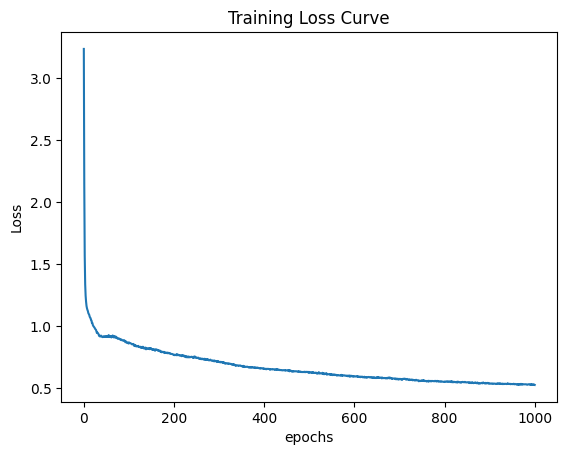

In [18]:
# plot training losses
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()